In [1]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

2024-06-28 14:30:35.562107: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [2]:
import pandas as pd
#import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#from openpyxl import load_workbook
import pickle
import random

In [3]:
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [4]:
from collections import defaultdict 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import sys
sys.path.append('./arl-eegmodels')
from EEGModels import EEGNet
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.0


In [6]:
K.set_image_data_format('channels_last')

## Assign subjects for train, validation and test sets

In [7]:
file=open('Sub_list.pkl','rb')
subjs=pickle.load(file)
#subjs

In [8]:
numsub_val= 4   # randomly select subjects for valid set
numsub_test = 1 # randomly select 1 subject for test set

In [9]:
nb_classes=2
dropoutRate=0.17 # change from 0.25 to 0.17
kernLength=64
F1=8
D=2
F2=F1*D
norm_rate=0.25
dropoutType = 'Dropout'
batch_size = 16
epoch_no=200

In [10]:
data_path='./eeg_sub_128_SWS/'

In [11]:
dropoutRate

0.17

## Deep learning modelling in loop

In [18]:
subjs1=set(subjs)-set(acc_crosssub.keys())
#subjs1

In [19]:
#acc_crosssub=defaultdict(dict)
#auc_crosssub=defaultdict(dict)

for s in subjs1:
    print(' ')
    print(f"Testing Subject {s}:")
    
    accD=[]
    aucD=[]
    accM=[]
    aucM=[]
    for tt in range(10):
###### Datasets for D night #############################################################################################   
        print('D night')
        # test subject
        XD_test=np.load(data_path+'XD_'+s+'.npy')
        y_encodedD_test=np.load(data_path+'y_encodedD_'+s+'.npy')
        print(f"X test: {XD_test.shape}")
        print(f"y test: {y_encodedD_test.shape}")
    
        subjs1=set(subjs)-set([s])
    
        #val subjects
        val_subj = random.sample(subjs1, numsub_val)
        XD_val = np.array([])
        y_encodedD_val = np.array([])
        for s_val in val_subj:
            XD=np.load(data_path+'XD_'+s_val+'.npy')
            y_encodedD=np.load(data_path+'y_encodedD_'+s_val+'.npy')
            #np.random.shuffle(y_encodedD) # shuffle
            
            XD_val=np.vstack((XD_val,XD)) if XD_val.size else XD
            y_encodedD_val=np.vstack((y_encodedD_val,y_encodedD)) if y_encodedD_val.size else y_encodedD
        print(f"X val: {XD_val.shape}")
        print(f"y val: {y_encodedD_val.shape}")

        #train subjects
        train_subj=set(subjs)-set(val_subj)-set([s])
        XD_train = np.array([])
        y_encodedD_train = np.array([])
        for s_train in train_subj:
            XD=np.load(data_path+'XD_'+s_train+'.npy')
            y_encodedD=np.load(data_path+'y_encodedD_'+s_train+'.npy')
            #np.random.shuffle(y_encodedD)  # shuffle
            
            XD_train=np.vstack((XD_train,XD)) if XD_train.size else XD
            y_encodedD_train=np.vstack((y_encodedD_train,y_encodedD)) if y_encodedD_train.size else y_encodedD
        print(f"X train: {XD_train.shape}")
        print(f"y train: {y_encodedD_train.shape}")
        
    ##### Deep learning for D night ############################################################################################
        kernels, chans, samples = 1, XD_train.shape[1], XD_train.shape[2]

        XD_train=XD_train.reshape(XD_train.shape[0], chans, samples, kernels)
        XD_val=XD_val.reshape(XD_val.shape[0], chans, samples, kernels)
        XD_test=XD_test.reshape(XD_test.shape[0], chans, samples, kernels)

        # callbacks
        early_stopping = EarlyStopping(monitor='val_loss', mode='min',patience=50,
                                       restore_best_weights=True)
        checkpointer = ModelCheckpoint(filepath='./checkpoint_model1_SWS/Model'+str(tt)+'_'+s+'D.h5', verbose=1,
                                       save_best_only=True)
        # log
        #logdir = '/cnvrg/logs/scalars/' + datetime.now().strftime("%Y%m%d-%H%M%S")
        #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

        class_weights = {0:1, 1:1}
        # EEGNet modelling
        model=EEGNet(nb_classes=nb_classes,Chans=chans,Samples=samples,dropoutRate=dropoutRate,
                    kernLength=kernLength,F1=F1,D=D,F2=F2,norm_rate=norm_rate,dropoutType=dropoutType)
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])
        model.fit(XD_train,y_encodedD_train,batch_size = batch_size, epochs=epoch_no, 
                  validation_data=(XD_val, y_encodedD_val),
                  callbacks=[checkpointer,early_stopping], class_weight = class_weights)
        model.load_weights('./checkpoint_model1_SWS/Model'+str(tt)+'_'+s+'D.h5') # load optimal weights

        y_predict=model.predict(XD_test)
        y_class=np.argmax(y_predict, axis=1)
        roc_auc_D=roc_auc_score(y_encodedD_test[:,1], y_predict[:,1])
        #acc=accuracy_score(y_encodedD_test[:,1],y_class)
        acc_D= np.mean(y_class == y_encodedD_test.argmax(axis=-1))
        #f1=f1_score(y_encodedD_test[:,1],y_class)

        # print results
        print(y_encodedD_test[:,1])
        print(y_class)
        print(f"acc= {acc_D}, auc= {roc_auc_D}")
        
        accD.append(acc_D)
        aucD.append(roc_auc_D)
        
        del XD_train
        del XD_val
        del XD_test

    ###### Datasets for M night #############################################################################################   
        # test subject
        print('M night')
        XM_test=np.load(data_path+'XM_'+s+'.npy')
        y_encodedM_test=np.load(data_path+'y_encodedM_'+s+'.npy')
        print(f"X test: {XM_test.shape}")
        print(f"y test: {y_encodedM_test.shape}")

        #subjs1=set(subjs)-set([s])

        #val subjects
        #val_subj = random.sample(subjs1, numsub_val)
        XM_val = np.array([])
        y_encodedM_val = np.array([])
        for s_val in val_subj:
            XM=np.load(data_path+'XM_'+s_val+'.npy')
            y_encodedM=np.load(data_path+'y_encodedM_'+s_val+'.npy')
            #np.random.shuffle(y_encodedM)  # shuffle
            
            XM_val=np.vstack((XM_val,XM)) if XM_val.size else XM
            y_encodedM_val=np.vstack((y_encodedM_val,y_encodedM)) if y_encodedM_val.size else y_encodedM
        print(f"X val: {XM_val.shape}")
        print(f"y val: {y_encodedM_val.shape}")

        #train subjects
        #train_subj=set(subjs)-set(val_subj)-set([s])
        XM_train = np.array([])
        y_encodedM_train = np.array([])
        for s_train in train_subj:
            XM=np.load(data_path+'XM_'+s_train+'.npy')
            y_encodedM=np.load(data_path+'y_encodedM_'+s_train+'.npy')
            #np.random.shuffle(y_encodedM)  # shuffle
            
            XM_train=np.vstack((XM_train,XM)) if XM_train.size else XM
            y_encodedM_train=np.vstack((y_encodedM_train,y_encodedM)) if y_encodedM_train.size else y_encodedM
        print(f"X train: {XM_train.shape}")
        print(f"y train: {y_encodedM_train.shape}")

    ##### Deep learning for M night ############################################################################################
        kernels, chans, samples = 1, XM_train.shape[1], XM_train.shape[2]

        XM_train=XM_train.reshape(XM_train.shape[0], chans, samples, kernels)
        XM_val=XM_val.reshape(XM_val.shape[0], chans, samples, kernels)
        XM_test=XM_test.reshape(XM_test.shape[0], chans, samples, kernels)

        # callbacks
        early_stopping = EarlyStopping(monitor='val_loss', mode='min',patience=50,
                                       restore_best_weights=True)
        checkpointer = ModelCheckpoint(filepath='./checkpoint_model1_SWS/Model'+str(tt)+'_'+s+'M.h5', verbose=1,
                                       save_best_only=True)
        # log
        #logdir = '/cnvrg/logs/scalars/' + datetime.now().strftime("%Y%m%d-%H%M%S")
        #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

        class_weights = {0:1, 1:1}
        # EEGNet modelling
        model=EEGNet(nb_classes=nb_classes,Chans=chans,Samples=samples,dropoutRate=dropoutRate,
                    kernLength=kernLength,F1=F1,D=D,F2=F2,norm_rate=norm_rate,dropoutType=dropoutType)
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])
        model.fit(XM_train,y_encodedM_train,batch_size = batch_size, epochs=epoch_no, 
                  validation_data=(XM_val, y_encodedM_val),
                  callbacks=[checkpointer,early_stopping], class_weight = class_weights)
        model.load_weights('./checkpoint_model1_SWS/Model'+str(tt)+'_'+s+'M.h5') # load optimal weights

        y_predict=model.predict(XM_test)
        y_class=np.argmax(y_predict, axis=1)
        roc_auc_M=roc_auc_score(y_encodedM_test[:,1], y_predict[:,1])
        #acc=accuracy_score(y_encodedM_test[:,1],y_class)
        acc_M= np.mean(y_class == y_encodedM_test.argmax(axis=-1))
        #f1=f1_score(y_encodedM_test[:,1],y_class)

        # print results
        print(y_encodedM_test[:,1])
        print(y_class)
        print(f"acc= {acc_M}, auc= {roc_auc_M}")
        
        accM.append(acc_M)
        aucM.append(roc_auc_M)
        
        del XM_train
        del XM_val
        del XM_test


    # save results
    acc_crosssub[s]['D']=accD
    auc_crosssub[s]['D']=aucD
    
    acc_crosssub[s]['M']=accM
    auc_crosssub[s]['M']=aucM
    f = open('Acc_crosssub1_SWS.pkl', 'wb')
    pickle.dump(acc_crosssub,f)
    f.close()

    f = open('Auc_crosssub1_SWS.pkl', 'wb')
    pickle.dump(auc_crosssub,f)
    f.close()

 
Testing Subject 16:
D night
X test: (66, 128, 897)
y test: (66, 2)
X val: (246, 128, 897)
y val: (246, 2)
X train: (1014, 128, 897)
y train: (1014, 2)
Epoch 1/200


2024-06-28 18:29:35.155480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_173/dropout_346/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.4911
Epoch 1: val_loss improved from inf to 0.69492, saving model to ./checkpoint_model1_SWS/Model0_16D.h5
64/64 [==============================] - 3s 24ms/step - loss: 0.7099 - accuracy: 0.4911 - val_loss: 0.6949 - val_accuracy: 0.5285
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6797 - accuracy: 0.5593
Epoch 2: val_loss did not improve from 0.69492
64/64 [==============================] - 1s 12ms/step - loss: 0.6821 - accuracy: 0.5562 - val_loss: 0.7061 - val_accuracy: 0.5122
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.5646
Epoch 3: val_loss did not improve from 0.69492
64/64 [==============================] - 1s 12ms/step - loss: 0.6732 - accuracy: 0.5621 - val_loss: 0.7100 - val_accuracy: 0.4837
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6622 - accuracy: 0.5858
Epoch 4: val_loss did not improve from 0.69492

2024-06-28 18:30:27.972909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_174/dropout_348/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7064 - accuracy: 0.5040
Epoch 1: val_loss improved from inf to 0.69539, saving model to ./checkpoint_model1_SWS/Model0_16M.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7064 - accuracy: 0.5047 - val_loss: 0.6954 - val_accuracy: 0.5336
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.5876
Epoch 2: val_loss did not improve from 0.69539
67/67 [==============================] - 1s 11ms/step - loss: 0.6732 - accuracy: 0.5876 - val_loss: 0.6991 - val_accuracy: 0.4832
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6023
Epoch 3: val_loss did not improve from 0.69539
67/67 [==============================] - 1s 11ms/step - loss: 0.6674 - accuracy: 0.6017 - val_loss: 0.7093 - val_accuracy: 0.5336
Epoch 4/200
65/67 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6135
Epoch 4: val_loss did not improve from 0.69539

2024-06-28 18:31:21.457501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_175/dropout_350/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/64 [============================>.] - ETA: 0s - loss: 0.7063 - accuracy: 0.4909
Epoch 1: val_loss improved from inf to 0.69676, saving model to ./checkpoint_model1_SWS/Model1_16D.h5
64/64 [==============================] - 4s 21ms/step - loss: 0.7058 - accuracy: 0.4941 - val_loss: 0.6968 - val_accuracy: 0.4467
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6821 - accuracy: 0.5413
Epoch 2: val_loss did not improve from 0.69676
64/64 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.5374 - val_loss: 0.7004 - val_accuracy: 0.4795
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.5935
Epoch 3: val_loss did not improve from 0.69676
64/64 [==============================] - 1s 19ms/step - loss: 0.6696 - accuracy: 0.5935 - val_loss: 0.7138 - val_accuracy: 0.4672
Epoch 4/200
62/64 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.5696
Epoch 4: val_loss did not improve from 0.69676

2024-06-28 18:32:13.849821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_176/dropout_352/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7187 - accuracy: 0.5010
Epoch 1: val_loss improved from inf to 0.69645, saving model to ./checkpoint_model1_SWS/Model1_16M.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7191 - accuracy: 0.4990 - val_loss: 0.6965 - val_accuracy: 0.5476
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5735
Epoch 2: val_loss did not improve from 0.69645
66/66 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.5735 - val_loss: 0.7022 - val_accuracy: 0.5397
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.5811
Epoch 3: val_loss did not improve from 0.69645
66/66 [==============================] - 1s 12ms/step - loss: 0.6766 - accuracy: 0.5811 - val_loss: 0.7018 - val_accuracy: 0.5278
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.5869
Epoch 4: val_loss did not improve from 0.69645

2024-06-28 18:33:07.389511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_177/dropout_354/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/62 [===========================>..] - ETA: 0s - loss: 0.7120 - accuracy: 0.5011
Epoch 1: val_loss improved from inf to 0.69236, saving model to ./checkpoint_model1_SWS/Model2_16D.h5
62/62 [==============================] - 3s 24ms/step - loss: 0.7122 - accuracy: 0.4960 - val_loss: 0.6924 - val_accuracy: 0.4852
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5545
Epoch 2: val_loss improved from 0.69236 to 0.68947, saving model to ./checkpoint_model1_SWS/Model2_16D.h5
62/62 [==============================] - 3s 43ms/step - loss: 0.6845 - accuracy: 0.5545 - val_loss: 0.6895 - val_accuracy: 0.5185
Epoch 3/200
61/62 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.5973
Epoch 3: val_loss did not improve from 0.68947
62/62 [==============================] - 1s 13ms/step - loss: 0.6699 - accuracy: 0.5970 - val_loss: 0.7010 - val_accuracy: 0.5148
Epoch 4/200
57/62 [==========================>...] - ETA: 0s - loss: 0.6672 - accu

2024-06-28 18:34:01.898963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_178/dropout_356/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.5078
Epoch 1: val_loss improved from inf to 0.69699, saving model to ./checkpoint_model1_SWS/Model2_16M.h5
64/64 [==============================] - 3s 17ms/step - loss: 0.7091 - accuracy: 0.5078 - val_loss: 0.6970 - val_accuracy: 0.5036
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5574
Epoch 2: val_loss improved from 0.69699 to 0.69361, saving model to ./checkpoint_model1_SWS/Model2_16M.h5
64/64 [==============================] - 1s 19ms/step - loss: 0.6834 - accuracy: 0.5596 - val_loss: 0.6936 - val_accuracy: 0.5580
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6672 - accuracy: 0.5902
Epoch 3: val_loss did not improve from 0.69361
64/64 [==============================] - 1s 11ms/step - loss: 0.6695 - accuracy: 0.5889 - val_loss: 0.7154 - val_accuracy: 0.4964
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6606 - accu

2024-06-28 18:34:53.537714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_179/dropout_358/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.4736
Epoch 1: val_loss improved from inf to 0.69456, saving model to ./checkpoint_model1_SWS/Model3_16D.h5
65/65 [==============================] - 3s 19ms/step - loss: 0.7090 - accuracy: 0.4721 - val_loss: 0.6946 - val_accuracy: 0.5090
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5530
Epoch 2: val_loss improved from 0.69456 to 0.68658, saving model to ./checkpoint_model1_SWS/Model3_16D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6848 - accuracy: 0.5530 - val_loss: 0.6866 - val_accuracy: 0.5135
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.5809
Epoch 3: val_loss did not improve from 0.68658
65/65 [==============================] - 1s 19ms/step - loss: 0.6707 - accuracy: 0.5809 - val_loss: 0.7009 - val_accuracy: 0.5000
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6675 - accu

2024-06-28 18:35:47.760292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_180/dropout_360/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7094 - accuracy: 0.5121
Epoch 1: val_loss improved from inf to 0.69394, saving model to ./checkpoint_model1_SWS/Model3_16M.h5
69/69 [==============================] - 3s 15ms/step - loss: 0.7099 - accuracy: 0.5110 - val_loss: 0.6939 - val_accuracy: 0.4905
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.5756
Epoch 2: val_loss did not improve from 0.69394
69/69 [==============================] - 1s 18ms/step - loss: 0.6764 - accuracy: 0.5743 - val_loss: 0.7046 - val_accuracy: 0.4857
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6744 - accuracy: 0.5862
Epoch 3: val_loss did not improve from 0.69394
69/69 [==============================] - 1s 12ms/step - loss: 0.6743 - accuracy: 0.5890 - val_loss: 0.7122 - val_accuracy: 0.4619
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6659 - accuracy: 0.5924
Epoch 4: val_loss did not improve from 0.69394

2024-06-28 18:36:43.901886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_181/dropout_362/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.4883
Epoch 1: val_loss improved from inf to 0.69250, saving model to ./checkpoint_model1_SWS/Model4_16D.h5
65/65 [==============================] - 3s 22ms/step - loss: 0.7105 - accuracy: 0.4883 - val_loss: 0.6925 - val_accuracy: 0.5304
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6877 - accuracy: 0.5502
Epoch 2: val_loss did not improve from 0.69250
65/65 [==============================] - 1s 11ms/step - loss: 0.6880 - accuracy: 0.5485 - val_loss: 0.6934 - val_accuracy: 0.4913
Epoch 3/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5605
Epoch 3: val_loss did not improve from 0.69250
65/65 [==============================] - 1s 11ms/step - loss: 0.6812 - accuracy: 0.5612 - val_loss: 0.6938 - val_accuracy: 0.5087
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.5847
Epoch 4: val_loss did not improve from 0.69250

2024-06-28 18:37:36.803063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_182/dropout_364/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7093 - accuracy: 0.4889
Epoch 1: val_loss improved from inf to 0.69591, saving model to ./checkpoint_model1_SWS/Model4_16M.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7115 - accuracy: 0.4887 - val_loss: 0.6959 - val_accuracy: 0.4790
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.5459
Epoch 2: val_loss improved from 0.69591 to 0.69051, saving model to ./checkpoint_model1_SWS/Model4_16M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6912 - accuracy: 0.5480 - val_loss: 0.6905 - val_accuracy: 0.5084
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6746 - accuracy: 0.5811
Epoch 3: val_loss did not improve from 0.69051
67/67 [==============================] - 1s 12ms/step - loss: 0.6756 - accuracy: 0.5782 - val_loss: 0.7020 - val_accuracy: 0.5084
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6703 - accu

2024-06-28 18:38:32.711799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_183/dropout_366/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7068 - accuracy: 0.5071
Epoch 1: val_loss improved from inf to 0.69554, saving model to ./checkpoint_model1_SWS/Model5_16D.h5
67/67 [==============================] - 3s 21ms/step - loss: 0.7066 - accuracy: 0.5094 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.5634
Epoch 2: val_loss did not improve from 0.69554
67/67 [==============================] - 1s 11ms/step - loss: 0.6786 - accuracy: 0.5658 - val_loss: 0.7039 - val_accuracy: 0.5255
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.5771
Epoch 3: val_loss did not improve from 0.69554
67/67 [==============================] - 1s 11ms/step - loss: 0.6701 - accuracy: 0.5771 - val_loss: 0.7133 - val_accuracy: 0.4898
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6051
Epoch 4: val_loss did not improve from 0.69554

2024-06-28 18:39:25.939991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_184/dropout_368/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.5093
Epoch 1: val_loss improved from inf to 0.68985, saving model to ./checkpoint_model1_SWS/Model5_16M.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.6991 - accuracy: 0.5093 - val_loss: 0.6898 - val_accuracy: 0.5391
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5488
Epoch 2: val_loss did not improve from 0.68985
67/67 [==============================] - 1s 12ms/step - loss: 0.6839 - accuracy: 0.5495 - val_loss: 0.6922 - val_accuracy: 0.5391
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.5942
Epoch 3: val_loss did not improve from 0.68985
67/67 [==============================] - 1s 19ms/step - loss: 0.6734 - accuracy: 0.5897 - val_loss: 0.6987 - val_accuracy: 0.5391
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.5869
Epoch 4: val_loss did not improve from 0.68985

2024-06-28 18:40:22.775408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_185/dropout_370/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7062 - accuracy: 0.4885
Epoch 1: val_loss improved from inf to 0.69223, saving model to ./checkpoint_model1_SWS/Model6_16D.h5
64/64 [==============================] - 3s 18ms/step - loss: 0.7055 - accuracy: 0.4892 - val_loss: 0.6922 - val_accuracy: 0.4917
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6848 - accuracy: 0.5286
Epoch 2: val_loss improved from 0.69223 to 0.68781, saving model to ./checkpoint_model1_SWS/Model6_16D.h5
64/64 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.5285 - val_loss: 0.6878 - val_accuracy: 0.5744
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.5645
Epoch 3: val_loss did not improve from 0.68781
64/64 [==============================] - 1s 19ms/step - loss: 0.6758 - accuracy: 0.5678 - val_loss: 0.7027 - val_accuracy: 0.5124
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 0.6701 - accu

2024-06-28 18:41:16.175504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_186/dropout_372/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.5205
Epoch 1: val_loss improved from inf to 0.70081, saving model to ./checkpoint_model1_SWS/Model6_16M.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7003 - accuracy: 0.5204 - val_loss: 0.7008 - val_accuracy: 0.4682
Epoch 2/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6794 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.70081
68/68 [==============================] - 1s 11ms/step - loss: 0.6803 - accuracy: 0.5639 - val_loss: 0.7080 - val_accuracy: 0.4773
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.5849
Epoch 3: val_loss did not improve from 0.70081
68/68 [==============================] - 1s 18ms/step - loss: 0.6721 - accuracy: 0.5833 - val_loss: 0.7081 - val_accuracy: 0.4409
Epoch 4/200
68/68 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6259
Epoch 4: val_loss did not improve from 0.70081

2024-06-28 18:42:10.833201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_187/dropout_374/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/63 [==========================>...] - ETA: 0s - loss: 0.7075 - accuracy: 0.4946
Epoch 1: val_loss improved from inf to 0.70072, saving model to ./checkpoint_model1_SWS/Model7_16D.h5
63/63 [==============================] - 3s 22ms/step - loss: 0.7078 - accuracy: 0.4920 - val_loss: 0.7007 - val_accuracy: 0.4570
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5392
Epoch 2: val_loss improved from 0.70072 to 0.69710, saving model to ./checkpoint_model1_SWS/Model7_16D.h5
63/63 [==============================] - 1s 15ms/step - loss: 0.6882 - accuracy: 0.5428 - val_loss: 0.6971 - val_accuracy: 0.5508
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.5802
Epoch 3: val_loss improved from 0.69710 to 0.68634, saving model to ./checkpoint_model1_SWS/Model7_16D.h5
63/63 [==============================] - 1s 12ms/step - loss: 0.6775 - accuracy: 0.5777 - val_loss: 0.6863 - val_accuracy: 0.5430
Epoch 4/200
59/63 [====

2024-06-28 18:43:06.688319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_188/dropout_376/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7044 - accuracy: 0.4873
Epoch 1: val_loss improved from inf to 0.68770, saving model to ./checkpoint_model1_SWS/Model7_16M.h5
65/65 [==============================] - 4s 24ms/step - loss: 0.7052 - accuracy: 0.4836 - val_loss: 0.6877 - val_accuracy: 0.5564
Epoch 2/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6869 - accuracy: 0.5521
Epoch 2: val_loss did not improve from 0.68770
65/65 [==============================] - 1s 12ms/step - loss: 0.6835 - accuracy: 0.5638 - val_loss: 0.7049 - val_accuracy: 0.5188
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.5801
Epoch 3: val_loss did not improve from 0.68770
65/65 [==============================] - 1s 12ms/step - loss: 0.6757 - accuracy: 0.5793 - val_loss: 0.7021 - val_accuracy: 0.5150
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.6199
Epoch 4: val_loss did not improve from 0.68770

2024-06-28 18:44:00.777068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_189/dropout_378/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/63 [===========================>..] - ETA: 0s - loss: 0.7059 - accuracy: 0.5094
Epoch 1: val_loss improved from inf to 0.69421, saving model to ./checkpoint_model1_SWS/Model8_16D.h5
63/63 [==============================] - 3s 21ms/step - loss: 0.7060 - accuracy: 0.5079 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6911 - accuracy: 0.5250
Epoch 2: val_loss did not improve from 0.69421
63/63 [==============================] - 1s 11ms/step - loss: 0.6910 - accuracy: 0.5248 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 3/200
61/63 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.5676
Epoch 3: val_loss did not improve from 0.69421
63/63 [==============================] - 1s 11ms/step - loss: 0.6763 - accuracy: 0.5655 - val_loss: 0.7021 - val_accuracy: 0.5000
Epoch 4/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.5847
Epoch 4: val_loss did not improve from 0.69421

2024-06-28 18:44:51.605195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_190/dropout_380/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7167 - accuracy: 0.4924
Epoch 1: val_loss improved from inf to 0.69396, saving model to ./checkpoint_model1_SWS/Model8_16M.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7167 - accuracy: 0.4924 - val_loss: 0.6940 - val_accuracy: 0.5203
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5694
Epoch 2: val_loss did not improve from 0.69396
66/66 [==============================] - 1s 19ms/step - loss: 0.6860 - accuracy: 0.5683 - val_loss: 0.6944 - val_accuracy: 0.5285
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.5903
Epoch 3: val_loss did not improve from 0.69396
66/66 [==============================] - 1s 12ms/step - loss: 0.6693 - accuracy: 0.5911 - val_loss: 0.6959 - val_accuracy: 0.5244
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.5988
Epoch 4: val_loss did not improve from 0.69396

2024-06-28 18:45:45.639954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_191/dropout_382/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7093 - accuracy: 0.4877
Epoch 1: val_loss improved from inf to 0.69337, saving model to ./checkpoint_model1_SWS/Model9_16D.h5
66/66 [==============================] - 3s 22ms/step - loss: 0.7081 - accuracy: 0.4924 - val_loss: 0.6934 - val_accuracy: 0.5048
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5514
Epoch 2: val_loss did not improve from 0.69337
66/66 [==============================] - 1s 12ms/step - loss: 0.6895 - accuracy: 0.5457 - val_loss: 0.7014 - val_accuracy: 0.5143
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5610
Epoch 3: val_loss did not improve from 0.69337
66/66 [==============================] - 1s 18ms/step - loss: 0.6817 - accuracy: 0.5610 - val_loss: 0.7027 - val_accuracy: 0.4571
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6624 - accuracy: 0.5994
Epoch 4: val_loss did not improve from 0.69337

2024-06-28 18:46:38.215895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_192/dropout_384/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.68491, saving model to ./checkpoint_model1_SWS/Model9_16M.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7113 - accuracy: 0.5000 - val_loss: 0.6849 - val_accuracy: 0.5488
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5466
Epoch 2: val_loss did not improve from 0.68491
66/66 [==============================] - 1s 12ms/step - loss: 0.6848 - accuracy: 0.5465 - val_loss: 0.6922 - val_accuracy: 0.5325
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.68491
66/66 [==============================] - 1s 12ms/step - loss: 0.6757 - accuracy: 0.5769 - val_loss: 0.6984 - val_accuracy: 0.5244
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6015
Epoch 4: val_loss did not improve from 0.68491

2024-06-28 18:47:35.730392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_193/dropout_386/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.4894
Epoch 1: val_loss improved from inf to 0.69836, saving model to ./checkpoint_model1_SWS/Model0_09D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7154 - accuracy: 0.4894 - val_loss: 0.6984 - val_accuracy: 0.4958
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5537
Epoch 2: val_loss did not improve from 0.69836
66/66 [==============================] - 1s 18ms/step - loss: 0.6841 - accuracy: 0.5537 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5873
Epoch 3: val_loss improved from 0.69836 to 0.69606, saving model to ./checkpoint_model1_SWS/Model0_09D.h5
66/66 [==============================] - 4s 64ms/step - loss: 0.6724 - accuracy: 0.5873 - val_loss: 0.6961 - val_accuracy: 0.5083
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6652 - accu

2024-06-28 18:48:34.164286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_194/dropout_388/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7133 - accuracy: 0.4688
Epoch 1: val_loss improved from inf to 0.68843, saving model to ./checkpoint_model1_SWS/Model0_09M.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7125 - accuracy: 0.4700 - val_loss: 0.6884 - val_accuracy: 0.5547
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5492
Epoch 2: val_loss improved from 0.68843 to 0.68825, saving model to ./checkpoint_model1_SWS/Model0_09M.h5
67/67 [==============================] - 1s 18ms/step - loss: 0.6865 - accuracy: 0.5478 - val_loss: 0.6882 - val_accuracy: 0.5195
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.5798
Epoch 3: val_loss did not improve from 0.68825
67/67 [==============================] - 1s 11ms/step - loss: 0.6767 - accuracy: 0.5826 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6720 - accu

2024-06-28 18:49:29.059596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_195/dropout_390/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/63 [===========================>..] - ETA: 0s - loss: 0.7131 - accuracy: 0.4844
Epoch 1: val_loss improved from inf to 0.68902, saving model to ./checkpoint_model1_SWS/Model1_09D.h5
63/63 [==============================] - 3s 18ms/step - loss: 0.7142 - accuracy: 0.4790 - val_loss: 0.6890 - val_accuracy: 0.5426
Epoch 2/200
61/63 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5420
Epoch 2: val_loss did not improve from 0.68902
63/63 [==============================] - 1s 12ms/step - loss: 0.6948 - accuracy: 0.5390 - val_loss: 0.6919 - val_accuracy: 0.4716
Epoch 3/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.5869
Epoch 3: val_loss improved from 0.68902 to 0.68650, saving model to ./checkpoint_model1_SWS/Model1_09D.h5
63/63 [==============================] - 1s 20ms/step - loss: 0.6756 - accuracy: 0.5790 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 4/200
61/63 [============================>.] - ETA: 0s - loss: 0.6655 - accu

2024-06-28 18:50:23.834433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_196/dropout_392/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/66 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.5264
Epoch 1: val_loss improved from inf to 0.69678, saving model to ./checkpoint_model1_SWS/Model1_09M.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7016 - accuracy: 0.5259 - val_loss: 0.6968 - val_accuracy: 0.4712
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6751 - accuracy: 0.5696
Epoch 2: val_loss did not improve from 0.69678
66/66 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5670 - val_loss: 0.7062 - val_accuracy: 0.4892
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6640 - accuracy: 0.6158
Epoch 3: val_loss did not improve from 0.69678
66/66 [==============================] - 1s 12ms/step - loss: 0.6655 - accuracy: 0.6102 - val_loss: 0.7286 - val_accuracy: 0.4496
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6240
Epoch 4: val_loss did not improve from 0.69678

2024-06-28 18:51:20.140493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_197/dropout_394/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7109 - accuracy: 0.4740
Epoch 1: val_loss improved from inf to 0.69533, saving model to ./checkpoint_model1_SWS/Model2_09D.h5
66/66 [==============================] - 3s 19ms/step - loss: 0.7109 - accuracy: 0.4741 - val_loss: 0.6953 - val_accuracy: 0.4875
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6886 - accuracy: 0.5328
Epoch 2: val_loss improved from 0.69533 to 0.69261, saving model to ./checkpoint_model1_SWS/Model2_09D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6882 - accuracy: 0.5393 - val_loss: 0.6926 - val_accuracy: 0.5125
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6786 - accuracy: 0.5655
Epoch 3: val_loss did not improve from 0.69261
66/66 [==============================] - 1s 19ms/step - loss: 0.6780 - accuracy: 0.5681 - val_loss: 0.6955 - val_accuracy: 0.5458
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6766 - accu

2024-06-28 18:52:15.514292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_198/dropout_396/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.5223
Epoch 1: val_loss improved from inf to 0.70385, saving model to ./checkpoint_model1_SWS/Model2_09M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7027 - accuracy: 0.5223 - val_loss: 0.7039 - val_accuracy: 0.4797
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5511
Epoch 2: val_loss improved from 0.70385 to 0.70248, saving model to ./checkpoint_model1_SWS/Model2_09M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6852 - accuracy: 0.5520 - val_loss: 0.7025 - val_accuracy: 0.5163
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.5779
Epoch 3: val_loss improved from 0.70248 to 0.70243, saving model to ./checkpoint_model1_SWS/Model2_09M.h5
68/68 [==============================] - 1s 19ms/step - loss: 0.6742 - accuracy: 0.5771 - val_loss: 0.7024 - val_accuracy: 0.5081
Epoch 4/200
66/68 [====

2024-06-28 18:53:11.019027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_199/dropout_398/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.5048
Epoch 1: val_loss improved from inf to 0.71458, saving model to ./checkpoint_model1_SWS/Model3_09D.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7133 - accuracy: 0.5048 - val_loss: 0.7146 - val_accuracy: 0.4454
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5508
Epoch 2: val_loss improved from 0.71458 to 0.70131, saving model to ./checkpoint_model1_SWS/Model3_09D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6882 - accuracy: 0.5508 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5713
Epoch 3: val_loss improved from 0.70131 to 0.70043, saving model to ./checkpoint_model1_SWS/Model3_09D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6818 - accuracy: 0.5738 - val_loss: 0.7004 - val_accuracy: 0.5210
Epoch 4/200
66/66 [====

2024-06-28 18:54:05.021305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_200/dropout_400/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7041 - accuracy: 0.5159
Epoch 1: val_loss improved from inf to 0.68654, saving model to ./checkpoint_model1_SWS/Model3_09M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7053 - accuracy: 0.5128 - val_loss: 0.6865 - val_accuracy: 0.5087
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5558
Epoch 2: val_loss did not improve from 0.68654
69/69 [==============================] - 1s 11ms/step - loss: 0.6844 - accuracy: 0.5559 - val_loss: 0.6944 - val_accuracy: 0.4913
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5806
Epoch 3: val_loss did not improve from 0.68654
69/69 [==============================] - 1s 18ms/step - loss: 0.6719 - accuracy: 0.5806 - val_loss: 0.7050 - val_accuracy: 0.5000
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.5962
Epoch 4: val_loss did not improve from 0.68654

2024-06-28 18:54:59.668172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_201/dropout_402/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7126 - accuracy: 0.4940
Epoch 1: val_loss improved from inf to 0.69160, saving model to ./checkpoint_model1_SWS/Model4_09D.h5
66/66 [==============================] - 4s 23ms/step - loss: 0.7130 - accuracy: 0.4962 - val_loss: 0.6916 - val_accuracy: 0.5219
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5567
Epoch 2: val_loss did not improve from 0.69160
66/66 [==============================] - 1s 12ms/step - loss: 0.6855 - accuracy: 0.5560 - val_loss: 0.6971 - val_accuracy: 0.4737
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5693
Epoch 3: val_loss did not improve from 0.69160
66/66 [==============================] - 1s 12ms/step - loss: 0.6710 - accuracy: 0.5683 - val_loss: 0.6954 - val_accuracy: 0.5219
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.5797
Epoch 4: val_loss did not improve from 0.69160

2024-06-28 18:55:54.937829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_202/dropout_404/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7019 - accuracy: 0.5154
Epoch 1: val_loss improved from inf to 0.69733, saving model to ./checkpoint_model1_SWS/Model4_09M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7030 - accuracy: 0.5139 - val_loss: 0.6973 - val_accuracy: 0.5000
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6741 - accuracy: 0.5765
Epoch 2: val_loss did not improve from 0.69733
68/68 [==============================] - 1s 18ms/step - loss: 0.6739 - accuracy: 0.5762 - val_loss: 0.7042 - val_accuracy: 0.5041
Epoch 3/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.6045
Epoch 3: val_loss did not improve from 0.69733
68/68 [==============================] - 1s 12ms/step - loss: 0.6622 - accuracy: 0.6013 - val_loss: 0.6982 - val_accuracy: 0.5041
Epoch 4/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6550 - accuracy: 0.6230
Epoch 4: val_loss did not improve from 0.69733

2024-06-28 18:56:49.669710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_203/dropout_406/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7101 - accuracy: 0.4712
Epoch 1: val_loss improved from inf to 0.69543, saving model to ./checkpoint_model1_SWS/Model5_09D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7105 - accuracy: 0.4710 - val_loss: 0.6954 - val_accuracy: 0.4907
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6914 - accuracy: 0.5205
Epoch 2: val_loss did not improve from 0.69543
67/67 [==============================] - 1s 12ms/step - loss: 0.6921 - accuracy: 0.5178 - val_loss: 0.6973 - val_accuracy: 0.5280
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.5492
Epoch 3: val_loss did not improve from 0.69543
67/67 [==============================] - 1s 19ms/step - loss: 0.6807 - accuracy: 0.5506 - val_loss: 0.7147 - val_accuracy: 0.4393
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5814
Epoch 4: val_loss did not improve from 0.69543

2024-06-28 18:57:43.588439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_204/dropout_408/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/70 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.4982
Epoch 1: val_loss improved from inf to 0.69167, saving model to ./checkpoint_model1_SWS/Model5_09M.h5
70/70 [==============================] - 3s 15ms/step - loss: 0.6995 - accuracy: 0.4991 - val_loss: 0.6917 - val_accuracy: 0.5278
Epoch 2/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6804 - accuracy: 0.5760
Epoch 2: val_loss did not improve from 0.69167
70/70 [==============================] - 1s 12ms/step - loss: 0.6788 - accuracy: 0.5778 - val_loss: 0.6950 - val_accuracy: 0.5093
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.5770
Epoch 3: val_loss did not improve from 0.69167
70/70 [==============================] - 1s 18ms/step - loss: 0.6704 - accuracy: 0.5759 - val_loss: 0.7046 - val_accuracy: 0.4907
Epoch 4/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6565 - accuracy: 0.6106
Epoch 4: val_loss did not improve from 0.69167

2024-06-28 18:58:37.903552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_205/dropout_410/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.4991
Epoch 1: val_loss improved from inf to 0.69947, saving model to ./checkpoint_model1_SWS/Model6_09D.h5
67/67 [==============================] - 3s 24ms/step - loss: 0.7051 - accuracy: 0.4991 - val_loss: 0.6995 - val_accuracy: 0.4730
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5578
Epoch 2: val_loss did not improve from 0.69947
67/67 [==============================] - 1s 12ms/step - loss: 0.6830 - accuracy: 0.5594 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.5740
Epoch 3: val_loss did not improve from 0.69947
67/67 [==============================] - 1s 12ms/step - loss: 0.6735 - accuracy: 0.5717 - val_loss: 0.7102 - val_accuracy: 0.4820
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6639 - accuracy: 0.5833
Epoch 4: val_loss did not improve from 0.69947

2024-06-28 18:59:31.765620: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_206/dropout_412/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.4897
Epoch 1: val_loss improved from inf to 0.68832, saving model to ./checkpoint_model1_SWS/Model6_09M.h5
67/67 [==============================] - 3s 20ms/step - loss: 0.7017 - accuracy: 0.4897 - val_loss: 0.6883 - val_accuracy: 0.5516
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5548
Epoch 2: val_loss improved from 0.68832 to 0.68667, saving model to ./checkpoint_model1_SWS/Model6_09M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6876 - accuracy: 0.5533 - val_loss: 0.6867 - val_accuracy: 0.5675
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.5981
Epoch 3: val_loss improved from 0.68667 to 0.68394, saving model to ./checkpoint_model1_SWS/Model6_09M.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6712 - accuracy: 0.5981 - val_loss: 0.6839 - val_accuracy: 0.5595
Epoch 4/200
66/67 [====

2024-06-28 19:00:27.121457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_207/dropout_414/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7089 - accuracy: 0.4951
Epoch 1: val_loss improved from inf to 0.69033, saving model to ./checkpoint_model1_SWS/Model7_09D.h5
69/69 [==============================] - 3s 21ms/step - loss: 0.7083 - accuracy: 0.4972 - val_loss: 0.6903 - val_accuracy: 0.5521
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6868 - accuracy: 0.5664
Epoch 2: val_loss did not improve from 0.69033
69/69 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.5596 - val_loss: 0.6984 - val_accuracy: 0.5104
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.5708
Epoch 3: val_loss did not improve from 0.69033
69/69 [==============================] - 1s 18ms/step - loss: 0.6741 - accuracy: 0.5716 - val_loss: 0.7036 - val_accuracy: 0.4948
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.5890
Epoch 4: val_loss did not improve from 0.69033

2024-06-28 19:01:21.943361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_208/dropout_416/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/70 [============================>.] - ETA: 0s - loss: 0.7079 - accuracy: 0.5054
Epoch 1: val_loss improved from inf to 0.69231, saving model to ./checkpoint_model1_SWS/Model7_09M.h5
70/70 [==============================] - 3s 15ms/step - loss: 0.7080 - accuracy: 0.5045 - val_loss: 0.6923 - val_accuracy: 0.5374
Epoch 2/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.5840
Epoch 2: val_loss improved from 0.69231 to 0.68710, saving model to ./checkpoint_model1_SWS/Model7_09M.h5
70/70 [==============================] - 1s 19ms/step - loss: 0.6822 - accuracy: 0.5803 - val_loss: 0.6871 - val_accuracy: 0.5374
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.5952
Epoch 3: val_loss did not improve from 0.68710
70/70 [==============================] - 1s 12ms/step - loss: 0.6682 - accuracy: 0.5984 - val_loss: 0.7043 - val_accuracy: 0.5374
Epoch 4/200
68/70 [============================>.] - ETA: 0s - loss: 0.6631 - accu

2024-06-28 19:02:19.096868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_209/dropout_418/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7131 - accuracy: 0.4760
Epoch 1: val_loss improved from inf to 0.69304, saving model to ./checkpoint_model1_SWS/Model8_09D.h5
64/64 [==============================] - 3s 18ms/step - loss: 0.7134 - accuracy: 0.4736 - val_loss: 0.6930 - val_accuracy: 0.5194
Epoch 2/200
62/64 [============================>.] - ETA: 0s - loss: 0.6899 - accuracy: 0.5454
Epoch 2: val_loss improved from 0.69304 to 0.68929, saving model to ./checkpoint_model1_SWS/Model8_09D.h5
64/64 [==============================] - 1s 19ms/step - loss: 0.6889 - accuracy: 0.5479 - val_loss: 0.6893 - val_accuracy: 0.5310
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.5584
Epoch 3: val_loss did not improve from 0.68929
64/64 [==============================] - 1s 11ms/step - loss: 0.6728 - accuracy: 0.5576 - val_loss: 0.7033 - val_accuracy: 0.4767
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6672 - accu

2024-06-28 19:03:11.062635: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_210/dropout_420/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.4990
Epoch 1: val_loss improved from inf to 0.69665, saving model to ./checkpoint_model1_SWS/Model8_09M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7060 - accuracy: 0.5028 - val_loss: 0.6966 - val_accuracy: 0.4961
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5837
Epoch 2: val_loss improved from 0.69665 to 0.68851, saving model to ./checkpoint_model1_SWS/Model8_09M.h5
67/67 [==============================] - 4s 57ms/step - loss: 0.6850 - accuracy: 0.5824 - val_loss: 0.6885 - val_accuracy: 0.5197
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.5936
Epoch 3: val_loss did not improve from 0.68851
67/67 [==============================] - 1s 19ms/step - loss: 0.6689 - accuracy: 0.5936 - val_loss: 0.7058 - val_accuracy: 0.4921
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6600 - accu

2024-06-28 19:04:09.661453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_211/dropout_422/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.7119 - accuracy: 0.4785
Epoch 1: val_loss improved from inf to 0.69300, saving model to ./checkpoint_model1_SWS/Model9_09D.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7111 - accuracy: 0.4773 - val_loss: 0.6930 - val_accuracy: 0.4955
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5595
Epoch 2: val_loss did not improve from 0.69300
67/67 [==============================] - 1s 13ms/step - loss: 0.6819 - accuracy: 0.5595 - val_loss: 0.7012 - val_accuracy: 0.4911
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.5635
Epoch 3: val_loss did not improve from 0.69300
67/67 [==============================] - 1s 19ms/step - loss: 0.6717 - accuracy: 0.5633 - val_loss: 0.7015 - val_accuracy: 0.4955
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.5956
Epoch 4: val_loss did not improve from 0.69300

2024-06-28 19:05:03.769633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_212/dropout_424/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69736, saving model to ./checkpoint_model1_SWS/Model9_09M.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7007 - accuracy: 0.5149 - val_loss: 0.6974 - val_accuracy: 0.5040
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5857
Epoch 2: val_loss did not improve from 0.69736
68/68 [==============================] - 1s 18ms/step - loss: 0.6777 - accuracy: 0.5857 - val_loss: 0.6987 - val_accuracy: 0.5323
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.5758
Epoch 3: val_loss did not improve from 0.69736
68/68 [==============================] - 1s 11ms/step - loss: 0.6698 - accuracy: 0.5736 - val_loss: 0.6977 - val_accuracy: 0.4960
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.5890
Epoch 4: val_loss did not improve from 0.69736

2024-06-28 19:06:01.414424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_213/dropout_426/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/64 [===========================>..] - ETA: 0s - loss: 0.7095 - accuracy: 0.4805
Epoch 1: val_loss improved from inf to 0.69854, saving model to ./checkpoint_model1_SWS/Model0_30D.h5
64/64 [==============================] - 3s 17ms/step - loss: 0.7095 - accuracy: 0.4823 - val_loss: 0.6985 - val_accuracy: 0.4771
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.5789
Epoch 2: val_loss did not improve from 0.69854
64/64 [==============================] - 1s 12ms/step - loss: 0.6739 - accuracy: 0.5768 - val_loss: 0.7054 - val_accuracy: 0.4962
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.69854
64/64 [==============================] - 1s 19ms/step - loss: 0.6673 - accuracy: 0.5817 - val_loss: 0.7138 - val_accuracy: 0.4618
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6148
Epoch 4: val_loss did not improve from 0.69854

2024-06-28 19:06:58.205045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_214/dropout_428/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7106 - accuracy: 0.4970
Epoch 1: val_loss improved from inf to 0.70264, saving model to ./checkpoint_model1_SWS/Model0_30M.h5
67/67 [==============================] - 4s 17ms/step - loss: 0.7096 - accuracy: 0.4962 - val_loss: 0.7026 - val_accuracy: 0.4574
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5566
Epoch 2: val_loss improved from 0.70264 to 0.70206, saving model to ./checkpoint_model1_SWS/Model0_30M.h5
67/67 [==============================] - 1s 17ms/step - loss: 0.6867 - accuracy: 0.5544 - val_loss: 0.7021 - val_accuracy: 0.5000
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.5675
Epoch 3: val_loss did not improve from 0.70206
67/67 [==============================] - 1s 12ms/step - loss: 0.6767 - accuracy: 0.5675 - val_loss: 0.7131 - val_accuracy: 0.5000
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6758 - accu

2024-06-28 19:07:56.334371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_215/dropout_430/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.6995 - accuracy: 0.5222
Epoch 1: val_loss improved from inf to 0.69297, saving model to ./checkpoint_model1_SWS/Model1_30D.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.6995 - accuracy: 0.5229 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6874 - accuracy: 0.5543
Epoch 2: val_loss improved from 0.69297 to 0.69172, saving model to ./checkpoint_model1_SWS/Model1_30D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6864 - accuracy: 0.5581 - val_loss: 0.6917 - val_accuracy: 0.5219
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6727 - accuracy: 0.5952
Epoch 3: val_loss did not improve from 0.69172
66/66 [==============================] - 1s 18ms/step - loss: 0.6729 - accuracy: 0.5924 - val_loss: 0.6945 - val_accuracy: 0.5263
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6635 - accu

2024-06-28 19:08:51.917636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_216/dropout_432/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/70 [==========================>...] - ETA: 0s - loss: 0.7054 - accuracy: 0.5144
Epoch 1: val_loss improved from inf to 0.68579, saving model to ./checkpoint_model1_SWS/Model1_30M.h5
70/70 [==============================] - 3s 20ms/step - loss: 0.7051 - accuracy: 0.5162 - val_loss: 0.6858 - val_accuracy: 0.5694
Epoch 2/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5784
Epoch 2: val_loss improved from 0.68579 to 0.68434, saving model to ./checkpoint_model1_SWS/Model1_30M.h5
70/70 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5785 - val_loss: 0.6843 - val_accuracy: 0.5741
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6692 - accuracy: 0.5904
Epoch 3: val_loss did not improve from 0.68434
70/70 [==============================] - 1s 18ms/step - loss: 0.6723 - accuracy: 0.5839 - val_loss: 0.6870 - val_accuracy: 0.5370
Epoch 4/200
69/70 [============================>.] - ETA: 0s - loss: 0.6674 - accu

2024-06-28 19:09:48.222270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_217/dropout_434/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.5028
Epoch 1: val_loss improved from inf to 0.69168, saving model to ./checkpoint_model1_SWS/Model2_30D.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7079 - accuracy: 0.5028 - val_loss: 0.6917 - val_accuracy: 0.5306
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6783 - accuracy: 0.5742
Epoch 2: val_loss did not improve from 0.69168
68/68 [==============================] - 1s 12ms/step - loss: 0.6795 - accuracy: 0.5675 - val_loss: 0.6949 - val_accuracy: 0.5306
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.5758
Epoch 3: val_loss did not improve from 0.69168
68/68 [==============================] - 1s 18ms/step - loss: 0.6752 - accuracy: 0.5739 - val_loss: 0.7122 - val_accuracy: 0.5102
Epoch 4/200
67/68 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.5896
Epoch 4: val_loss did not improve from 0.69168

2024-06-28 19:10:42.320080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_218/dropout_436/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7068 - accuracy: 0.5088
Epoch 1: val_loss improved from inf to 0.70005, saving model to ./checkpoint_model1_SWS/Model2_30M.h5
69/69 [==============================] - 3s 15ms/step - loss: 0.7051 - accuracy: 0.5136 - val_loss: 0.7000 - val_accuracy: 0.5091
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5652
Epoch 2: val_loss did not improve from 0.70005
69/69 [==============================] - 1s 17ms/step - loss: 0.6889 - accuracy: 0.5652 - val_loss: 0.7022 - val_accuracy: 0.5136
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.5868
Epoch 3: val_loss improved from 0.70005 to 0.69443, saving model to ./checkpoint_model1_SWS/Model2_30M.h5
69/69 [==============================] - 1s 11ms/step - loss: 0.6730 - accuracy: 0.5888 - val_loss: 0.6944 - val_accuracy: 0.5636
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6702 - accu

2024-06-28 19:11:37.613819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_219/dropout_438/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7082 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 0.69606, saving model to ./checkpoint_model1_SWS/Model3_30D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7090 - accuracy: 0.5000 - val_loss: 0.6961 - val_accuracy: 0.4558
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6786 - accuracy: 0.5857
Epoch 2: val_loss did not improve from 0.69606
66/66 [==============================] - 1s 12ms/step - loss: 0.6803 - accuracy: 0.5798 - val_loss: 0.7035 - val_accuracy: 0.4735
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.5752
Epoch 3: val_loss did not improve from 0.69606
66/66 [==============================] - 1s 18ms/step - loss: 0.6786 - accuracy: 0.5770 - val_loss: 0.7028 - val_accuracy: 0.5133
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6129
Epoch 4: val_loss did not improve from 0.69606

2024-06-28 19:12:30.887884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_220/dropout_440/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7101 - accuracy: 0.4991
Epoch 1: val_loss improved from inf to 0.68647, saving model to ./checkpoint_model1_SWS/Model3_30M.h5
69/69 [==============================] - 3s 15ms/step - loss: 0.7088 - accuracy: 0.5027 - val_loss: 0.6865 - val_accuracy: 0.5893
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5541
Epoch 2: val_loss did not improve from 0.68647
69/69 [==============================] - 1s 12ms/step - loss: 0.6866 - accuracy: 0.5536 - val_loss: 0.6948 - val_accuracy: 0.5357
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.5618
Epoch 3: val_loss did not improve from 0.68647
69/69 [==============================] - 1s 18ms/step - loss: 0.6803 - accuracy: 0.5618 - val_loss: 0.6961 - val_accuracy: 0.5223
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6020
Epoch 4: val_loss did not improve from 0.68647

2024-06-28 19:13:25.070959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_221/dropout_442/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.6958 - accuracy: 0.5337
Epoch 1: val_loss improved from inf to 0.70832, saving model to ./checkpoint_model1_SWS/Model4_30D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.6952 - accuracy: 0.5346 - val_loss: 0.7083 - val_accuracy: 0.4476
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6670 - accuracy: 0.6028
Epoch 2: val_loss did not improve from 0.70832
67/67 [==============================] - 1s 17ms/step - loss: 0.6706 - accuracy: 0.6011 - val_loss: 0.7139 - val_accuracy: 0.4238
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6032
Epoch 3: val_loss did not improve from 0.70832
67/67 [==============================] - 1s 12ms/step - loss: 0.6686 - accuracy: 0.6021 - val_loss: 0.7180 - val_accuracy: 0.4143
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6189
Epoch 4: val_loss did not improve from 0.70832

2024-06-28 19:14:19.854963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_222/dropout_444/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7148 - accuracy: 0.5067
Epoch 1: val_loss improved from inf to 0.68331, saving model to ./checkpoint_model1_SWS/Model4_30M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7135 - accuracy: 0.5091 - val_loss: 0.6833 - val_accuracy: 0.5405
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5772
Epoch 2: val_loss did not improve from 0.68331
69/69 [==============================] - 1s 12ms/step - loss: 0.6852 - accuracy: 0.5771 - val_loss: 0.6851 - val_accuracy: 0.5315
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6766 - accuracy: 0.5721
Epoch 3: val_loss did not improve from 0.68331
69/69 [==============================] - 1s 12ms/step - loss: 0.6767 - accuracy: 0.5699 - val_loss: 0.6862 - val_accuracy: 0.5586
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.5709
Epoch 4: val_loss improved from 0.68331 to 0.6

2024-06-28 19:15:16.906559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_223/dropout_446/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/65 [===========================>..] - ETA: 0s - loss: 0.7050 - accuracy: 0.4950
Epoch 1: val_loss improved from inf to 0.69279, saving model to ./checkpoint_model1_SWS/Model5_30D.h5
65/65 [==============================] - 3s 18ms/step - loss: 0.7038 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5081
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.5420
Epoch 2: val_loss did not improve from 0.69279
65/65 [==============================] - 1s 12ms/step - loss: 0.6816 - accuracy: 0.5388 - val_loss: 0.6990 - val_accuracy: 0.4959
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.5879
Epoch 3: val_loss did not improve from 0.69279
65/65 [==============================] - 1s 18ms/step - loss: 0.6677 - accuracy: 0.5872 - val_loss: 0.7031 - val_accuracy: 0.5122
Epoch 4/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6567 - accuracy: 0.5938
Epoch 4: val_loss did not improve from 0.69279

2024-06-28 19:16:09.235018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_224/dropout_448/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/70 [============================>.] - ETA: 0s - loss: 0.7032 - accuracy: 0.5027
Epoch 1: val_loss improved from inf to 0.69691, saving model to ./checkpoint_model1_SWS/Model5_30M.h5
70/70 [==============================] - 3s 22ms/step - loss: 0.7035 - accuracy: 0.5009 - val_loss: 0.6969 - val_accuracy: 0.5340
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.5689
Epoch 2: val_loss did not improve from 0.69691
70/70 [==============================] - 1s 12ms/step - loss: 0.6789 - accuracy: 0.5662 - val_loss: 0.7047 - val_accuracy: 0.5291
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.5978
Epoch 3: val_loss did not improve from 0.69691
70/70 [==============================] - 1s 12ms/step - loss: 0.6701 - accuracy: 0.6011 - val_loss: 0.7187 - val_accuracy: 0.5000
Epoch 4/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.6082
Epoch 4: val_loss did not improve from 0.69691

2024-06-28 19:17:05.186505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_225/dropout_450/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.4971
Epoch 1: val_loss improved from inf to 0.69338, saving model to ./checkpoint_model1_SWS/Model6_30D.h5
66/66 [==============================] - 3s 21ms/step - loss: 0.7089 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4871
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6826 - accuracy: 0.5615
Epoch 2: val_loss improved from 0.69338 to 0.69127, saving model to ./checkpoint_model1_SWS/Model6_30D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6797 - accuracy: 0.5707 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.5986
Epoch 3: val_loss did not improve from 0.69127
66/66 [==============================] - 1s 11ms/step - loss: 0.6652 - accuracy: 0.5956 - val_loss: 0.7051 - val_accuracy: 0.4871
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6634 - accu

2024-06-28 19:17:58.216016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_226/dropout_452/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7061 - accuracy: 0.4972
Epoch 1: val_loss improved from inf to 0.68757, saving model to ./checkpoint_model1_SWS/Model6_30M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7065 - accuracy: 0.4954 - val_loss: 0.6876 - val_accuracy: 0.5522
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.5481
Epoch 2: val_loss improved from 0.68757 to 0.68583, saving model to ./checkpoint_model1_SWS/Model6_30M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5420 - val_loss: 0.6858 - val_accuracy: 0.5696
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6835 - accuracy: 0.5558
Epoch 3: val_loss did not improve from 0.68583
69/69 [==============================] - 1s 11ms/step - loss: 0.6827 - accuracy: 0.5603 - val_loss: 0.6909 - val_accuracy: 0.5391
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6736 - accu

2024-06-28 19:19:26.108501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_227/dropout_454/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5065
Epoch 1: val_loss improved from inf to 0.69765, saving model to ./checkpoint_model1_SWS/Model7_30D.h5
68/68 [==============================] - 4s 20ms/step - loss: 0.7061 - accuracy: 0.5065 - val_loss: 0.6976 - val_accuracy: 0.5101
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5471
Epoch 2: val_loss did not improve from 0.69765
68/68 [==============================] - 1s 12ms/step - loss: 0.6843 - accuracy: 0.5519 - val_loss: 0.7022 - val_accuracy: 0.4848
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6731 - accuracy: 0.5756
Epoch 3: val_loss did not improve from 0.69765
68/68 [==============================] - 1s 19ms/step - loss: 0.6726 - accuracy: 0.5769 - val_loss: 0.7046 - val_accuracy: 0.5051
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.5909
Epoch 4: val_loss did not improve from 0.69765

2024-06-28 19:20:19.458366: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_228/dropout_456/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/70 [===========================>..] - ETA: 0s - loss: 0.7117 - accuracy: 0.4915
Epoch 1: val_loss improved from inf to 0.69738, saving model to ./checkpoint_model1_SWS/Model7_30M.h5
70/70 [==============================] - 3s 16ms/step - loss: 0.7127 - accuracy: 0.4910 - val_loss: 0.6974 - val_accuracy: 0.4481
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.6804 - accuracy: 0.5598
Epoch 2: val_loss did not improve from 0.69738
70/70 [==============================] - 1s 12ms/step - loss: 0.6811 - accuracy: 0.5594 - val_loss: 0.6985 - val_accuracy: 0.4575
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6753 - accuracy: 0.5702
Epoch 3: val_loss did not improve from 0.69738
70/70 [==============================] - 1s 18ms/step - loss: 0.6751 - accuracy: 0.5710 - val_loss: 0.6979 - val_accuracy: 0.5189
Epoch 4/200
68/70 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.6020
Epoch 4: val_loss improved from 0.69738 to 0.6

2024-06-28 19:21:17.200613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_229/dropout_458/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7007 - accuracy: 0.5111
Epoch 1: val_loss improved from inf to 0.69476, saving model to ./checkpoint_model1_SWS/Model8_30D.h5
66/66 [==============================] - 3s 22ms/step - loss: 0.7016 - accuracy: 0.5096 - val_loss: 0.6948 - val_accuracy: 0.4873
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.5752
Epoch 2: val_loss did not improve from 0.69476
66/66 [==============================] - 1s 11ms/step - loss: 0.6788 - accuracy: 0.5739 - val_loss: 0.6993 - val_accuracy: 0.4661
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6614 - accuracy: 0.6055
Epoch 3: val_loss did not improve from 0.69476
66/66 [==============================] - 1s 11ms/step - loss: 0.6645 - accuracy: 0.5969 - val_loss: 0.7082 - val_accuracy: 0.4703
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.6067
Epoch 4: val_loss did not improve from 0.69476

2024-06-28 19:22:09.002858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_230/dropout_460/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7084 - accuracy: 0.4839
Epoch 1: val_loss improved from inf to 0.69508, saving model to ./checkpoint_model1_SWS/Model8_30M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7092 - accuracy: 0.4835 - val_loss: 0.6951 - val_accuracy: 0.5128
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5365
Epoch 2: val_loss did not improve from 0.69508
69/69 [==============================] - 1s 12ms/step - loss: 0.6920 - accuracy: 0.5376 - val_loss: 0.7042 - val_accuracy: 0.4872
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6791 - accuracy: 0.5710
Epoch 3: val_loss did not improve from 0.69508
69/69 [==============================] - 1s 18ms/step - loss: 0.6788 - accuracy: 0.5716 - val_loss: 0.7085 - val_accuracy: 0.5128
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.5871
Epoch 4: val_loss did not improve from 0.69508

2024-06-28 19:23:03.456909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_231/dropout_462/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.4871
Epoch 1: val_loss improved from inf to 0.69437, saving model to ./checkpoint_model1_SWS/Model9_30D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7095 - accuracy: 0.4873 - val_loss: 0.6944 - val_accuracy: 0.5198
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.5556
Epoch 2: val_loss did not improve from 0.69437
65/65 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5585 - val_loss: 0.6963 - val_accuracy: 0.4921
Epoch 3/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.5948
Epoch 3: val_loss did not improve from 0.69437
65/65 [==============================] - 1s 12ms/step - loss: 0.6682 - accuracy: 0.5975 - val_loss: 0.6990 - val_accuracy: 0.5000
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.5887
Epoch 4: val_loss did not improve from 0.69437

2024-06-28 19:23:56.528783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_232/dropout_464/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7065 - accuracy: 0.5275
Epoch 1: val_loss improved from inf to 0.69855, saving model to ./checkpoint_model1_SWS/Model9_30M.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7050 - accuracy: 0.5317 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5812
Epoch 2: val_loss improved from 0.69855 to 0.69801, saving model to ./checkpoint_model1_SWS/Model9_30M.h5
67/67 [==============================] - 1s 11ms/step - loss: 0.6797 - accuracy: 0.5812 - val_loss: 0.6980 - val_accuracy: 0.5238
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6665 - accuracy: 0.6023
Epoch 3: val_loss did not improve from 0.69801
67/67 [==============================] - 1s 11ms/step - loss: 0.6684 - accuracy: 0.5979 - val_loss: 0.7170 - val_accuracy: 0.5079
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6577 - accu

2024-06-28 19:24:49.838720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_233/dropout_466/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7008 - accuracy: 0.5254
Epoch 1: val_loss improved from inf to 0.69898, saving model to ./checkpoint_model1_SWS/Model0_41D.h5
65/65 [==============================] - 3s 22ms/step - loss: 0.7009 - accuracy: 0.5242 - val_loss: 0.6990 - val_accuracy: 0.4538
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5703
Epoch 2: val_loss did not improve from 0.69898
65/65 [==============================] - 1s 12ms/step - loss: 0.6783 - accuracy: 0.5716 - val_loss: 0.7080 - val_accuracy: 0.4916
Epoch 3/200
63/65 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.5813
Epoch 3: val_loss did not improve from 0.69898
65/65 [==============================] - 1s 12ms/step - loss: 0.6696 - accuracy: 0.5783 - val_loss: 0.7096 - val_accuracy: 0.5210
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6079
Epoch 4: val_loss did not improve from 0.69898

2024-06-28 19:25:42.903020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_234/dropout_468/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7033 - accuracy: 0.5147
Epoch 1: val_loss improved from inf to 0.70357, saving model to ./checkpoint_model1_SWS/Model0_41M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7024 - accuracy: 0.5181 - val_loss: 0.7036 - val_accuracy: 0.4914
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6785 - accuracy: 0.5683
Epoch 2: val_loss did not improve from 0.70357
69/69 [==============================] - 1s 11ms/step - loss: 0.6776 - accuracy: 0.5652 - val_loss: 0.7121 - val_accuracy: 0.4871
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.5942
Epoch 3: val_loss did not improve from 0.70357
69/69 [==============================] - 1s 11ms/step - loss: 0.6670 - accuracy: 0.5969 - val_loss: 0.7064 - val_accuracy: 0.5345
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.6014
Epoch 4: val_loss did not improve from 0.70357

2024-06-28 19:26:36.373971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_235/dropout_470/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.4914
Epoch 1: val_loss improved from inf to 0.69701, saving model to ./checkpoint_model1_SWS/Model1_41D.h5
66/66 [==============================] - 4s 28ms/step - loss: 0.7064 - accuracy: 0.4914 - val_loss: 0.6970 - val_accuracy: 0.4909
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5476
Epoch 2: val_loss improved from 0.69701 to 0.69305, saving model to ./checkpoint_model1_SWS/Model1_41D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6848 - accuracy: 0.5494 - val_loss: 0.6931 - val_accuracy: 0.4818
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.5746
Epoch 3: val_loss did not improve from 0.69305
66/66 [==============================] - 1s 20ms/step - loss: 0.6751 - accuracy: 0.5798 - val_loss: 0.7083 - val_accuracy: 0.4364
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6635 - accu

2024-06-28 19:27:32.062253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_236/dropout_472/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7075 - accuracy: 0.5068
Epoch 1: val_loss improved from inf to 0.69768, saving model to ./checkpoint_model1_SWS/Model1_41M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7081 - accuracy: 0.5055 - val_loss: 0.6977 - val_accuracy: 0.4876
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.5721
Epoch 2: val_loss did not improve from 0.69768
69/69 [==============================] - 1s 18ms/step - loss: 0.6808 - accuracy: 0.5722 - val_loss: 0.7003 - val_accuracy: 0.4876
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6734 - accuracy: 0.5890
Epoch 3: val_loss did not improve from 0.69768
69/69 [==============================] - 1s 11ms/step - loss: 0.6741 - accuracy: 0.5878 - val_loss: 0.7053 - val_accuracy: 0.4711
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.6032
Epoch 4: val_loss did not improve from 0.69768

2024-06-28 19:28:26.545271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_237/dropout_474/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7154 - accuracy: 0.4933
Epoch 1: val_loss improved from inf to 0.69070, saving model to ./checkpoint_model1_SWS/Model2_41D.h5
67/67 [==============================] - 3s 20ms/step - loss: 0.7154 - accuracy: 0.4915 - val_loss: 0.6907 - val_accuracy: 0.5467
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.5212
Epoch 2: val_loss did not improve from 0.69070
67/67 [==============================] - 1s 11ms/step - loss: 0.6968 - accuracy: 0.5189 - val_loss: 0.6919 - val_accuracy: 0.5234
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6752 - accuracy: 0.5655
Epoch 3: val_loss did not improve from 0.69070
67/67 [==============================] - 1s 18ms/step - loss: 0.6790 - accuracy: 0.5633 - val_loss: 0.6979 - val_accuracy: 0.4860
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.5781
Epoch 4: val_loss did not improve from 0.69070

2024-06-28 19:29:19.398605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_238/dropout_476/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/70 [============================>.] - ETA: 0s - loss: 0.7129 - accuracy: 0.4909
Epoch 1: val_loss improved from inf to 0.68927, saving model to ./checkpoint_model1_SWS/Model2_41M.h5
70/70 [==============================] - 3s 21ms/step - loss: 0.7124 - accuracy: 0.4928 - val_loss: 0.6893 - val_accuracy: 0.5625
Epoch 2/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6873 - accuracy: 0.5502
Epoch 2: val_loss did not improve from 0.68927
70/70 [==============================] - 1s 11ms/step - loss: 0.6876 - accuracy: 0.5513 - val_loss: 0.6944 - val_accuracy: 0.5402
Epoch 3/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5700
Epoch 3: val_loss did not improve from 0.68927
70/70 [==============================] - 1s 19ms/step - loss: 0.6845 - accuracy: 0.5665 - val_loss: 0.6957 - val_accuracy: 0.5134
Epoch 4/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6718 - accuracy: 0.5894
Epoch 4: val_loss did not improve from 0.68927

2024-06-28 19:30:14.264439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_239/dropout_478/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7055 - accuracy: 0.5091
Epoch 1: val_loss improved from inf to 0.70043, saving model to ./checkpoint_model1_SWS/Model3_41D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7054 - accuracy: 0.5134 - val_loss: 0.7004 - val_accuracy: 0.4955
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5356
Epoch 2: val_loss did not improve from 0.70043
66/66 [==============================] - 1s 18ms/step - loss: 0.6865 - accuracy: 0.5382 - val_loss: 0.7007 - val_accuracy: 0.5223
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.5798
Epoch 3: val_loss improved from 0.70043 to 0.69932, saving model to ./checkpoint_model1_SWS/Model3_41D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6692 - accuracy: 0.5792 - val_loss: 0.6993 - val_accuracy: 0.4732
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6673 - accu

2024-06-28 19:31:08.722319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_240/dropout_480/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.4927
Epoch 1: val_loss improved from inf to 0.69595, saving model to ./checkpoint_model1_SWS/Model3_41M.h5
69/69 [==============================] - 4s 20ms/step - loss: 0.7105 - accuracy: 0.4927 - val_loss: 0.6960 - val_accuracy: 0.4957
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.5882
Epoch 2: val_loss did not improve from 0.69595
69/69 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5880 - val_loss: 0.7051 - val_accuracy: 0.4872
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6038
Epoch 3: val_loss did not improve from 0.69595
69/69 [==============================] - 1s 18ms/step - loss: 0.6661 - accuracy: 0.5998 - val_loss: 0.7170 - val_accuracy: 0.5214
Epoch 4/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.5933
Epoch 4: val_loss did not improve from 0.69595

2024-06-28 19:32:05.145519: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_241/dropout_482/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7210 - accuracy: 0.4970
Epoch 1: val_loss improved from inf to 0.70094, saving model to ./checkpoint_model1_SWS/Model4_41D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7200 - accuracy: 0.4943 - val_loss: 0.7009 - val_accuracy: 0.4685
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6920 - accuracy: 0.5451
Epoch 2: val_loss improved from 0.70094 to 0.69947, saving model to ./checkpoint_model1_SWS/Model4_41D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6928 - accuracy: 0.5419 - val_loss: 0.6995 - val_accuracy: 0.4865
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.5635
Epoch 3: val_loss did not improve from 0.69947
66/66 [==============================] - 1s 19ms/step - loss: 0.6773 - accuracy: 0.5629 - val_loss: 0.7076 - val_accuracy: 0.4685
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6592 - accu

2024-06-28 19:32:57.808685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_242/dropout_484/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/68 [===========================>..] - ETA: 0s - loss: 0.7109 - accuracy: 0.5078
Epoch 1: val_loss improved from inf to 0.69418, saving model to ./checkpoint_model1_SWS/Model4_41M.h5
68/68 [==============================] - 3s 18ms/step - loss: 0.7110 - accuracy: 0.5083 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6828 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69418
68/68 [==============================] - 1s 12ms/step - loss: 0.6847 - accuracy: 0.5590 - val_loss: 0.6996 - val_accuracy: 0.5278
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.69418
68/68 [==============================] - 1s 19ms/step - loss: 0.6715 - accuracy: 0.5978 - val_loss: 0.7028 - val_accuracy: 0.5198
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.5889
Epoch 4: val_loss did not improve from 0.69418

2024-06-28 19:33:51.333320: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_243/dropout_486/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/62 [============================>.] - ETA: 0s - loss: 0.7101 - accuracy: 0.4816
Epoch 1: val_loss improved from inf to 0.70039, saving model to ./checkpoint_model1_SWS/Model5_41D.h5
62/62 [==============================] - 3s 17ms/step - loss: 0.7103 - accuracy: 0.4798 - val_loss: 0.7004 - val_accuracy: 0.4789
Epoch 2/200
61/62 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5656
Epoch 2: val_loss improved from 0.70039 to 0.69664, saving model to ./checkpoint_model1_SWS/Model5_41D.h5
62/62 [==============================] - 1s 12ms/step - loss: 0.6848 - accuracy: 0.5648 - val_loss: 0.6966 - val_accuracy: 0.4859
Epoch 3/200
59/62 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.6017
Epoch 3: val_loss did not improve from 0.69664
62/62 [==============================] - 1s 20ms/step - loss: 0.6686 - accuracy: 0.5982 - val_loss: 0.7021 - val_accuracy: 0.4930
Epoch 4/200
58/62 [===========================>..] - ETA: 0s - loss: 0.6528 - accu

2024-06-28 19:34:43.617202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_244/dropout_488/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7053 - accuracy: 0.4899
Epoch 1: val_loss improved from inf to 0.69606, saving model to ./checkpoint_model1_SWS/Model5_41M.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7065 - accuracy: 0.4887 - val_loss: 0.6961 - val_accuracy: 0.5144
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6752 - accuracy: 0.5817
Epoch 2: val_loss improved from 0.69606 to 0.69056, saving model to ./checkpoint_model1_SWS/Model5_41M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6753 - accuracy: 0.5822 - val_loss: 0.6906 - val_accuracy: 0.5540
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.5843
Epoch 3: val_loss did not improve from 0.69056
67/67 [==============================] - 1s 19ms/step - loss: 0.6701 - accuracy: 0.5832 - val_loss: 0.6988 - val_accuracy: 0.5324
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6634 - accu

2024-06-28 19:35:38.494638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_245/dropout_490/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/65 [===========================>..] - ETA: 0s - loss: 0.7162 - accuracy: 0.4836
Epoch 1: val_loss improved from inf to 0.70110, saving model to ./checkpoint_model1_SWS/Model6_41D.h5
65/65 [==============================] - 3s 16ms/step - loss: 0.7154 - accuracy: 0.4806 - val_loss: 0.7011 - val_accuracy: 0.5289
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5635
Epoch 2: val_loss did not improve from 0.70110
65/65 [==============================] - 1s 22ms/step - loss: 0.6839 - accuracy: 0.5621 - val_loss: 0.7031 - val_accuracy: 0.4835
Epoch 3/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6723 - accuracy: 0.5885
Epoch 3: val_loss did not improve from 0.70110
65/65 [==============================] - 1s 12ms/step - loss: 0.6741 - accuracy: 0.5825 - val_loss: 0.7215 - val_accuracy: 0.4835
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.5847
Epoch 4: val_loss did not improve from 0.70110

2024-06-28 19:36:30.927249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_246/dropout_492/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7115 - accuracy: 0.4830
Epoch 1: val_loss improved from inf to 0.69812, saving model to ./checkpoint_model1_SWS/Model6_41M.h5
69/69 [==============================] - 3s 15ms/step - loss: 0.7145 - accuracy: 0.4772 - val_loss: 0.6981 - val_accuracy: 0.5125
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5538
Epoch 2: val_loss did not improve from 0.69812
69/69 [==============================] - 1s 19ms/step - loss: 0.6860 - accuracy: 0.5502 - val_loss: 0.7040 - val_accuracy: 0.5000
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.5740
Epoch 3: val_loss improved from 0.69812 to 0.69518, saving model to ./checkpoint_model1_SWS/Model6_41M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6770 - accuracy: 0.5721 - val_loss: 0.6952 - val_accuracy: 0.5042
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6631 - accu

2024-06-28 19:37:27.040340: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_247/dropout_494/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7110 - accuracy: 0.4856
Epoch 1: val_loss improved from inf to 0.69800, saving model to ./checkpoint_model1_SWS/Model7_41D.h5
66/66 [==============================] - 4s 16ms/step - loss: 0.7109 - accuracy: 0.4877 - val_loss: 0.6980 - val_accuracy: 0.5092
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6807 - accuracy: 0.5442
Epoch 2: val_loss improved from 0.69800 to 0.69336, saving model to ./checkpoint_model1_SWS/Model7_41D.h5
66/66 [==============================] - 1s 19ms/step - loss: 0.6817 - accuracy: 0.5427 - val_loss: 0.6934 - val_accuracy: 0.4954
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.5840
Epoch 3: val_loss did not improve from 0.69336
66/66 [==============================] - 1s 12ms/step - loss: 0.6683 - accuracy: 0.5854 - val_loss: 0.7002 - val_accuracy: 0.4954
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6581 - accu

2024-06-28 19:38:23.117862: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_248/dropout_496/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7103 - accuracy: 0.5055
Epoch 1: val_loss improved from inf to 0.69841, saving model to ./checkpoint_model1_SWS/Model7_41M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7099 - accuracy: 0.5064 - val_loss: 0.6984 - val_accuracy: 0.5042
Epoch 2/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6863 - accuracy: 0.5653
Epoch 2: val_loss did not improve from 0.69841
69/69 [==============================] - 1s 11ms/step - loss: 0.6870 - accuracy: 0.5601 - val_loss: 0.7069 - val_accuracy: 0.4748
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.5909
Epoch 3: val_loss did not improve from 0.69841
69/69 [==============================] - 1s 18ms/step - loss: 0.6744 - accuracy: 0.5902 - val_loss: 0.7092 - val_accuracy: 0.4790
Epoch 4/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.5779
Epoch 4: val_loss did not improve from 0.69841

2024-06-28 19:39:17.916907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_249/dropout_498/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/63 [============================>.] - ETA: 0s - loss: 0.7125 - accuracy: 0.4898
Epoch 1: val_loss improved from inf to 0.69807, saving model to ./checkpoint_model1_SWS/Model8_41D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7130 - accuracy: 0.4869 - val_loss: 0.6981 - val_accuracy: 0.4565
Epoch 2/200
61/63 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5482
Epoch 2: val_loss did not improve from 0.69807
63/63 [==============================] - 1s 12ms/step - loss: 0.6856 - accuracy: 0.5502 - val_loss: 0.7000 - val_accuracy: 0.4565
Epoch 3/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.5858
Epoch 3: val_loss did not improve from 0.69807
63/63 [==============================] - 1s 12ms/step - loss: 0.6698 - accuracy: 0.5894 - val_loss: 0.6989 - val_accuracy: 0.5326
Epoch 4/200
61/63 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.5727
Epoch 4: val_loss did not improve from 0.69807

2024-06-28 19:40:10.914154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_250/dropout_500/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7036 - accuracy: 0.5060
Epoch 1: val_loss improved from inf to 0.69986, saving model to ./checkpoint_model1_SWS/Model8_41M.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7033 - accuracy: 0.5057 - val_loss: 0.6999 - val_accuracy: 0.5138
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5462
Epoch 2: val_loss improved from 0.69986 to 0.69405, saving model to ./checkpoint_model1_SWS/Model8_41M.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6907 - accuracy: 0.5449 - val_loss: 0.6940 - val_accuracy: 0.5276
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.5635
Epoch 3: val_loss did not improve from 0.69405
66/66 [==============================] - 1s 12ms/step - loss: 0.6730 - accuracy: 0.5669 - val_loss: 0.7055 - val_accuracy: 0.5069
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6606 - accu

2024-06-28 19:41:06.112232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_251/dropout_502/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.5056
Epoch 1: val_loss improved from inf to 0.69463, saving model to ./checkpoint_model1_SWS/Model9_41D.h5
67/67 [==============================] - 3s 15ms/step - loss: 0.7071 - accuracy: 0.5056 - val_loss: 0.6946 - val_accuracy: 0.4760
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5733
Epoch 2: val_loss did not improve from 0.69463
67/67 [==============================] - 1s 18ms/step - loss: 0.6834 - accuracy: 0.5733 - val_loss: 0.7010 - val_accuracy: 0.4375
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5549
Epoch 3: val_loss did not improve from 0.69463
67/67 [==============================] - 1s 12ms/step - loss: 0.6828 - accuracy: 0.5555 - val_loss: 0.7146 - val_accuracy: 0.4615
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.5606
Epoch 4: val_loss did not improve from 0.69463

2024-06-28 19:41:59.654544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_252/dropout_504/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.5282
Epoch 1: val_loss improved from inf to 0.69773, saving model to ./checkpoint_model1_SWS/Model9_41M.h5
69/69 [==============================] - 3s 21ms/step - loss: 0.7016 - accuracy: 0.5282 - val_loss: 0.6977 - val_accuracy: 0.5212
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6801 - accuracy: 0.5723
Epoch 2: val_loss did not improve from 0.69773
69/69 [==============================] - 1s 12ms/step - loss: 0.6818 - accuracy: 0.5727 - val_loss: 0.7048 - val_accuracy: 0.5212
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6731 - accuracy: 0.5855
Epoch 3: val_loss did not improve from 0.69773
69/69 [==============================] - 1s 12ms/step - loss: 0.6724 - accuracy: 0.5855 - val_loss: 0.7099 - val_accuracy: 0.4915
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6032
Epoch 4: val_loss did not improve from 0.69773

2024-06-28 19:42:59.134396: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_253/dropout_506/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/64 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.5089
Epoch 1: val_loss improved from inf to 0.70329, saving model to ./checkpoint_model1_SWS/Model0_26D.h5
64/64 [==============================] - 4s 37ms/step - loss: 0.7143 - accuracy: 0.5078 - val_loss: 0.7033 - val_accuracy: 0.4574
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.70329
64/64 [==============================] - 1s 12ms/step - loss: 0.6878 - accuracy: 0.5597 - val_loss: 0.7049 - val_accuracy: 0.4845
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5822
Epoch 3: val_loss did not improve from 0.70329
64/64 [==============================] - 1s 21ms/step - loss: 0.6760 - accuracy: 0.5822 - val_loss: 0.7190 - val_accuracy: 0.4535
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.5982
Epoch 4: val_loss did not improve from 0.70329

2024-06-28 19:43:53.033856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_254/dropout_508/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/65 [===========================>..] - ETA: 0s - loss: 0.7175 - accuracy: 0.5081
Epoch 1: val_loss improved from inf to 0.68338, saving model to ./checkpoint_model1_SWS/Model0_26M.h5
65/65 [==============================] - 3s 16ms/step - loss: 0.7163 - accuracy: 0.5107 - val_loss: 0.6834 - val_accuracy: 0.5411
Epoch 2/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6881 - accuracy: 0.5406
Epoch 2: val_loss did not improve from 0.68338
65/65 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.5428 - val_loss: 0.6943 - val_accuracy: 0.5274
Epoch 3/200
63/65 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5992
Epoch 3: val_loss did not improve from 0.68338
65/65 [==============================] - 1s 19ms/step - loss: 0.6723 - accuracy: 0.5973 - val_loss: 0.7050 - val_accuracy: 0.4897
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.5902
Epoch 4: val_loss did not improve from 0.68338

2024-06-28 19:44:47.110365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_255/dropout_510/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7039 - accuracy: 0.4898
Epoch 1: val_loss improved from inf to 0.70026, saving model to ./checkpoint_model1_SWS/Model1_26D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7047 - accuracy: 0.4875 - val_loss: 0.7003 - val_accuracy: 0.4958
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6795 - accuracy: 0.5817
Epoch 2: val_loss improved from 0.70026 to 0.69686, saving model to ./checkpoint_model1_SWS/Model1_26D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6794 - accuracy: 0.5805 - val_loss: 0.6969 - val_accuracy: 0.5042
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5642
Epoch 3: val_loss improved from 0.69686 to 0.69522, saving model to ./checkpoint_model1_SWS/Model1_26D.h5
66/66 [==============================] - 1s 20ms/step - loss: 0.6724 - accuracy: 0.5642 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/200
65/66 [====

2024-06-28 19:45:42.833940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_256/dropout_512/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.5211
Epoch 1: val_loss improved from inf to 0.69805, saving model to ./checkpoint_model1_SWS/Model1_26M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7077 - accuracy: 0.5211 - val_loss: 0.6981 - val_accuracy: 0.4783
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6754 - accuracy: 0.5771
Epoch 2: val_loss did not improve from 0.69805
69/69 [==============================] - 1s 12ms/step - loss: 0.6748 - accuracy: 0.5734 - val_loss: 0.7151 - val_accuracy: 0.5000
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.5651
Epoch 3: val_loss did not improve from 0.69805
69/69 [==============================] - 1s 18ms/step - loss: 0.6650 - accuracy: 0.5651 - val_loss: 0.7162 - val_accuracy: 0.5087
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6023
Epoch 4: val_loss did not improve from 0.69805

2024-06-28 19:46:37.863090: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_257/dropout_514/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.4905
Epoch 1: val_loss improved from inf to 0.70005, saving model to ./checkpoint_model1_SWS/Model2_26D.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7117 - accuracy: 0.4888 - val_loss: 0.7000 - val_accuracy: 0.4953
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6832 - accuracy: 0.5566
Epoch 2: val_loss did not improve from 0.70005
67/67 [==============================] - 1s 12ms/step - loss: 0.6829 - accuracy: 0.5571 - val_loss: 0.7007 - val_accuracy: 0.4906
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.5581
Epoch 3: val_loss did not improve from 0.70005
67/67 [==============================] - 1s 11ms/step - loss: 0.6785 - accuracy: 0.5581 - val_loss: 0.7134 - val_accuracy: 0.4670
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.5996
Epoch 4: val_loss did not improve from 0.70005

2024-06-28 19:47:30.962962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_258/dropout_516/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/70 [============================>.] - ETA: 0s - loss: 0.7033 - accuracy: 0.5046
Epoch 1: val_loss improved from inf to 0.69423, saving model to ./checkpoint_model1_SWS/Model2_26M.h5
70/70 [==============================] - 3s 23ms/step - loss: 0.7028 - accuracy: 0.5054 - val_loss: 0.6942 - val_accuracy: 0.5093
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5633
Epoch 2: val_loss did not improve from 0.69423
70/70 [==============================] - 1s 11ms/step - loss: 0.6852 - accuracy: 0.5633 - val_loss: 0.6978 - val_accuracy: 0.4907
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6709 - accuracy: 0.5817
Epoch 3: val_loss did not improve from 0.69423
70/70 [==============================] - 1s 11ms/step - loss: 0.6713 - accuracy: 0.5814 - val_loss: 0.7060 - val_accuracy: 0.5047
Epoch 4/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6652 - accuracy: 0.6026
Epoch 4: val_loss did not improve from 0.69423

2024-06-28 19:48:25.216643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_259/dropout_518/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/66 [============================>.] - ETA: 0s - loss: 0.7069 - accuracy: 0.5029
Epoch 1: val_loss improved from inf to 0.69434, saving model to ./checkpoint_model1_SWS/Model3_26D.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7071 - accuracy: 0.5019 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.69434
66/66 [==============================] - 1s 12ms/step - loss: 0.6821 - accuracy: 0.5618 - val_loss: 0.7019 - val_accuracy: 0.4518
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.69434
66/66 [==============================] - 1s 19ms/step - loss: 0.6682 - accuracy: 0.5922 - val_loss: 0.7041 - val_accuracy: 0.4693
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.6067
Epoch 4: val_loss did not improve from 0.69434

2024-06-28 19:49:19.863668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_260/dropout_520/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7011 - accuracy: 0.5298
Epoch 1: val_loss improved from inf to 0.69610, saving model to ./checkpoint_model1_SWS/Model3_26M.h5
69/69 [==============================] - 4s 23ms/step - loss: 0.7014 - accuracy: 0.5293 - val_loss: 0.6961 - val_accuracy: 0.4646
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5561
Epoch 2: val_loss did not improve from 0.69610
69/69 [==============================] - 1s 12ms/step - loss: 0.6811 - accuracy: 0.5558 - val_loss: 0.6997 - val_accuracy: 0.4867
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.5914
Epoch 3: val_loss did not improve from 0.69610
69/69 [==============================] - 1s 12ms/step - loss: 0.6628 - accuracy: 0.5914 - val_loss: 0.7038 - val_accuracy: 0.4912
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6172
Epoch 4: val_loss did not improve from 0.69610

2024-06-28 19:50:14.818357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_261/dropout_522/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7085 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69883, saving model to ./checkpoint_model1_SWS/Model4_26D.h5
66/66 [==============================] - 3s 15ms/step - loss: 0.7087 - accuracy: 0.5123 - val_loss: 0.6988 - val_accuracy: 0.4688
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6799 - accuracy: 0.5635
Epoch 2: val_loss improved from 0.69883 to 0.69833, saving model to ./checkpoint_model1_SWS/Model4_26D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6818 - accuracy: 0.5549 - val_loss: 0.6983 - val_accuracy: 0.4598
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.5750
Epoch 3: val_loss did not improve from 0.69833
66/66 [==============================] - 1s 17ms/step - loss: 0.6742 - accuracy: 0.5767 - val_loss: 0.7045 - val_accuracy: 0.5045
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6581 - accu

2024-06-28 19:51:06.896050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_262/dropout_524/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7097 - accuracy: 0.5060
Epoch 1: val_loss improved from inf to 0.69333, saving model to ./checkpoint_model1_SWS/Model4_26M.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7113 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4963
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6845 - accuracy: 0.5574
Epoch 2: val_loss did not improve from 0.69333
66/66 [==============================] - 1s 11ms/step - loss: 0.6832 - accuracy: 0.5592 - val_loss: 0.6969 - val_accuracy: 0.4779
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.5889
Epoch 3: val_loss did not improve from 0.69333
66/66 [==============================] - 1s 19ms/step - loss: 0.6676 - accuracy: 0.5878 - val_loss: 0.7003 - val_accuracy: 0.5000
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6220
Epoch 4: val_loss did not improve from 0.69333

2024-06-28 19:52:01.596158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_263/dropout_526/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/64 [==========================>...] - ETA: 0s - loss: 0.7142 - accuracy: 0.4809
Epoch 1: val_loss improved from inf to 0.69290, saving model to ./checkpoint_model1_SWS/Model5_26D.h5
64/64 [==============================] - 3s 16ms/step - loss: 0.7125 - accuracy: 0.4834 - val_loss: 0.6929 - val_accuracy: 0.5388
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5523
Epoch 2: val_loss improved from 0.69290 to 0.69167, saving model to ./checkpoint_model1_SWS/Model5_26D.h5
64/64 [==============================] - 1s 19ms/step - loss: 0.6846 - accuracy: 0.5558 - val_loss: 0.6917 - val_accuracy: 0.5078
Epoch 3/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6775 - accuracy: 0.5562
Epoch 3: val_loss did not improve from 0.69167
64/64 [==============================] - 1s 12ms/step - loss: 0.6783 - accuracy: 0.5577 - val_loss: 0.6956 - val_accuracy: 0.5155
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6690 - accu

2024-06-28 19:53:04.075352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_264/dropout_528/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7109 - accuracy: 0.4970
Epoch 1: val_loss improved from inf to 0.69483, saving model to ./checkpoint_model1_SWS/Model5_26M.h5
66/66 [==============================] - 3s 25ms/step - loss: 0.7115 - accuracy: 0.4952 - val_loss: 0.6948 - val_accuracy: 0.5404
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5620
Epoch 2: val_loss did not improve from 0.69483
66/66 [==============================] - 1s 12ms/step - loss: 0.6813 - accuracy: 0.5620 - val_loss: 0.6976 - val_accuracy: 0.5147
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.5611
Epoch 3: val_loss did not improve from 0.69483
66/66 [==============================] - 1s 19ms/step - loss: 0.6759 - accuracy: 0.5611 - val_loss: 0.6958 - val_accuracy: 0.5147
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.5992
Epoch 4: val_loss did not improve from 0.69483

2024-06-28 19:54:00.242327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_265/dropout_530/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7069 - accuracy: 0.4990
Epoch 1: val_loss improved from inf to 0.69676, saving model to ./checkpoint_model1_SWS/Model6_26D.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.6968 - val_accuracy: 0.5367
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6859 - accuracy: 0.5575
Epoch 2: val_loss did not improve from 0.69676
67/67 [==============================] - 1s 12ms/step - loss: 0.6863 - accuracy: 0.5574 - val_loss: 0.7082 - val_accuracy: 0.4541
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5584
Epoch 3: val_loss did not improve from 0.69676
67/67 [==============================] - 1s 19ms/step - loss: 0.6761 - accuracy: 0.5584 - val_loss: 0.7055 - val_accuracy: 0.4954
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.6045
Epoch 4: val_loss did not improve from 0.69676

2024-06-28 19:54:55.528833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_266/dropout_532/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7088 - accuracy: 0.4856
Epoch 1: val_loss improved from inf to 0.70009, saving model to ./checkpoint_model1_SWS/Model6_26M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7090 - accuracy: 0.4842 - val_loss: 0.7001 - val_accuracy: 0.5123
Epoch 2/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6830 - accuracy: 0.5387
Epoch 2: val_loss did not improve from 0.70009
68/68 [==============================] - 1s 14ms/step - loss: 0.6854 - accuracy: 0.5381 - val_loss: 0.7033 - val_accuracy: 0.5328
Epoch 3/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6761 - accuracy: 0.5595
Epoch 3: val_loss did not improve from 0.70009
68/68 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5567 - val_loss: 0.7106 - val_accuracy: 0.5328
Epoch 4/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6639 - accuracy: 0.5962
Epoch 4: val_loss did not improve from 0.70009

2024-06-28 19:55:50.832556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_267/dropout_534/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7055 - accuracy: 0.4919
Epoch 1: val_loss improved from inf to 0.69498, saving model to ./checkpoint_model1_SWS/Model7_26D.h5
66/66 [==============================] - 4s 16ms/step - loss: 0.7062 - accuracy: 0.4896 - val_loss: 0.6950 - val_accuracy: 0.4732
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5484
Epoch 2: val_loss did not improve from 0.69498
66/66 [==============================] - 1s 18ms/step - loss: 0.6869 - accuracy: 0.5483 - val_loss: 0.6975 - val_accuracy: 0.4821
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6777 - accuracy: 0.5932
Epoch 3: val_loss did not improve from 0.69498
66/66 [==============================] - 1s 11ms/step - loss: 0.6783 - accuracy: 0.5938 - val_loss: 0.7091 - val_accuracy: 0.4866
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6647 - accuracy: 0.5963
Epoch 4: val_loss did not improve from 0.69498

2024-06-28 19:56:41.817881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_268/dropout_536/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/68 [==========================>...] - ETA: 0s - loss: 0.7063 - accuracy: 0.5198
Epoch 1: val_loss improved from inf to 0.70169, saving model to ./checkpoint_model1_SWS/Model7_26M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7073 - accuracy: 0.5185 - val_loss: 0.7017 - val_accuracy: 0.5000
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5461
Epoch 2: val_loss did not improve from 0.70169
68/68 [==============================] - 1s 12ms/step - loss: 0.6833 - accuracy: 0.5461 - val_loss: 0.7061 - val_accuracy: 0.4958
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.5756
Epoch 3: val_loss did not improve from 0.70169
68/68 [==============================] - 1s 11ms/step - loss: 0.6776 - accuracy: 0.5747 - val_loss: 0.7176 - val_accuracy: 0.4576
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6707 - accuracy: 0.5933
Epoch 4: val_loss did not improve from 0.70169

2024-06-28 19:57:35.929876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_269/dropout_538/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7069 - accuracy: 0.4981
Epoch 1: val_loss improved from inf to 0.69958, saving model to ./checkpoint_model1_SWS/Model8_26D.h5
67/67 [==============================] - 3s 18ms/step - loss: 0.7093 - accuracy: 0.4916 - val_loss: 0.6996 - val_accuracy: 0.4856
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5354
Epoch 2: val_loss improved from 0.69958 to 0.69609, saving model to ./checkpoint_model1_SWS/Model8_26D.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6846 - accuracy: 0.5354 - val_loss: 0.6961 - val_accuracy: 0.5048
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5938
Epoch 3: val_loss did not improve from 0.69609
67/67 [==============================] - 1s 17ms/step - loss: 0.6657 - accuracy: 0.5961 - val_loss: 0.7108 - val_accuracy: 0.4663
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6555 - accu

2024-06-28 19:58:27.552645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_270/dropout_540/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7098 - accuracy: 0.5288
Epoch 1: val_loss improved from inf to 0.69011, saving model to ./checkpoint_model1_SWS/Model8_26M.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7102 - accuracy: 0.5265 - val_loss: 0.6901 - val_accuracy: 0.5265
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.5587
Epoch 2: val_loss did not improve from 0.69011
66/66 [==============================] - 1s 19ms/step - loss: 0.6835 - accuracy: 0.5578 - val_loss: 0.6951 - val_accuracy: 0.5152
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.5943
Epoch 3: val_loss did not improve from 0.69011
66/66 [==============================] - 1s 11ms/step - loss: 0.6718 - accuracy: 0.5900 - val_loss: 0.6945 - val_accuracy: 0.5038
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5758
Epoch 4: val_loss did not improve from 0.69011

2024-06-28 19:59:18.577087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_271/dropout_542/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5176
Epoch 1: val_loss improved from inf to 0.69753, saving model to ./checkpoint_model1_SWS/Model9_26D.h5
64/64 [==============================] - 3s 22ms/step - loss: 0.7005 - accuracy: 0.5176 - val_loss: 0.6975 - val_accuracy: 0.4922
Epoch 2/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.5573
Epoch 2: val_loss did not improve from 0.69753
64/64 [==============================] - 1s 12ms/step - loss: 0.6796 - accuracy: 0.5607 - val_loss: 0.7056 - val_accuracy: 0.4574
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6757 - accuracy: 0.5707
Epoch 3: val_loss did not improve from 0.69753
64/64 [==============================] - 1s 12ms/step - loss: 0.6740 - accuracy: 0.5734 - val_loss: 0.7026 - val_accuracy: 0.5116
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6220
Epoch 4: val_loss did not improve from 0.69753

2024-06-28 20:00:12.885725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_272/dropout_544/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/68 [============================>.] - ETA: 0s - loss: 0.7127 - accuracy: 0.5009
Epoch 1: val_loss improved from inf to 0.69031, saving model to ./checkpoint_model1_SWS/Model9_26M.h5
68/68 [==============================] - 3s 22ms/step - loss: 0.7120 - accuracy: 0.4991 - val_loss: 0.6903 - val_accuracy: 0.5427
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6792 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.69031 to 0.68819, saving model to ./checkpoint_model1_SWS/Model9_26M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6814 - accuracy: 0.5617 - val_loss: 0.6882 - val_accuracy: 0.5513
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6691 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.68819
68/68 [==============================] - 1s 11ms/step - loss: 0.6700 - accuracy: 0.5773 - val_loss: 0.6923 - val_accuracy: 0.5427
Epoch 4/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6674 - accu

2024-06-28 20:01:10.028300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_273/dropout_546/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.4841
Epoch 1: val_loss improved from inf to 0.69542, saving model to ./checkpoint_model1_SWS/Model0_48D.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7096 - accuracy: 0.4841 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.5808
Epoch 2: val_loss did not improve from 0.69542
67/67 [==============================] - 1s 14ms/step - loss: 0.6811 - accuracy: 0.5787 - val_loss: 0.7033 - val_accuracy: 0.4898
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6707 - accuracy: 0.5723
Epoch 3: val_loss did not improve from 0.69542
67/67 [==============================] - 1s 15ms/step - loss: 0.6734 - accuracy: 0.5674 - val_loss: 0.7161 - val_accuracy: 0.4898
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.5936
Epoch 4: val_loss did not improve from 0.69542

2024-06-28 20:02:07.967620: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_274/dropout_548/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.4954
Epoch 1: val_loss improved from inf to 0.69073, saving model to ./checkpoint_model1_SWS/Model0_48M.h5
69/69 [==============================] - 4s 18ms/step - loss: 0.7065 - accuracy: 0.4954 - val_loss: 0.6907 - val_accuracy: 0.5315
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6830 - accuracy: 0.5479
Epoch 2: val_loss did not improve from 0.69073
69/69 [==============================] - 1s 12ms/step - loss: 0.6827 - accuracy: 0.5493 - val_loss: 0.6910 - val_accuracy: 0.5405
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.5858
Epoch 3: val_loss did not improve from 0.69073
69/69 [==============================] - 1s 19ms/step - loss: 0.6729 - accuracy: 0.5858 - val_loss: 0.7024 - val_accuracy: 0.5045
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.5703
Epoch 4: val_loss did not improve from 0.69073

2024-06-28 20:03:03.445259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_275/dropout_550/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7102 - accuracy: 0.4836
Epoch 1: val_loss improved from inf to 0.69211, saving model to ./checkpoint_model1_SWS/Model1_48D.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7092 - accuracy: 0.4837 - val_loss: 0.6921 - val_accuracy: 0.5360
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6813 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.69211
66/66 [==============================] - 1s 12ms/step - loss: 0.6851 - accuracy: 0.5585 - val_loss: 0.6953 - val_accuracy: 0.4910
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6704 - accuracy: 0.5857
Epoch 3: val_loss did not improve from 0.69211
66/66 [==============================] - 1s 19ms/step - loss: 0.6707 - accuracy: 0.5825 - val_loss: 0.6975 - val_accuracy: 0.5541
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6008
Epoch 4: val_loss improved from 0.69211 to 0.6

2024-06-28 20:03:59.157491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_276/dropout_552/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7035 - accuracy: 0.4923
Epoch 1: val_loss improved from inf to 0.69691, saving model to ./checkpoint_model1_SWS/Model1_48M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7030 - accuracy: 0.4945 - val_loss: 0.6969 - val_accuracy: 0.5351
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5597
Epoch 2: val_loss did not improve from 0.69691
69/69 [==============================] - 1s 11ms/step - loss: 0.6844 - accuracy: 0.5596 - val_loss: 0.7041 - val_accuracy: 0.4912
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6739 - accuracy: 0.5703
Epoch 3: val_loss did not improve from 0.69691
69/69 [==============================] - 1s 20ms/step - loss: 0.6768 - accuracy: 0.5670 - val_loss: 0.7016 - val_accuracy: 0.5614
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.5890
Epoch 4: val_loss improved from 0.69691 to 0.6

2024-06-28 20:04:56.595122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_277/dropout_554/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7119 - accuracy: 0.4901
Epoch 1: val_loss improved from inf to 0.69865, saving model to ./checkpoint_model1_SWS/Model2_48D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7128 - accuracy: 0.4878 - val_loss: 0.6986 - val_accuracy: 0.5101
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.5762
Epoch 2: val_loss did not improve from 0.69865
67/67 [==============================] - 1s 19ms/step - loss: 0.6779 - accuracy: 0.5713 - val_loss: 0.6990 - val_accuracy: 0.4899
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6759 - accuracy: 0.5806
Epoch 3: val_loss did not improve from 0.69865
67/67 [==============================] - 1s 12ms/step - loss: 0.6793 - accuracy: 0.5722 - val_loss: 0.7026 - val_accuracy: 0.4798
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6616 - accuracy: 0.6018
Epoch 4: val_loss did not improve from 0.69865

2024-06-28 20:05:49.195945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_278/dropout_556/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/70 [============================>.] - ETA: 0s - loss: 0.7068 - accuracy: 0.4954
Epoch 1: val_loss improved from inf to 0.68188, saving model to ./checkpoint_model1_SWS/Model2_48M.h5
70/70 [==============================] - 3s 16ms/step - loss: 0.7063 - accuracy: 0.4964 - val_loss: 0.6819 - val_accuracy: 0.5743
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5493
Epoch 2: val_loss did not improve from 0.68188
70/70 [==============================] - 1s 12ms/step - loss: 0.6872 - accuracy: 0.5493 - val_loss: 0.6921 - val_accuracy: 0.5594
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6777 - accuracy: 0.5894
Epoch 3: val_loss did not improve from 0.68188
70/70 [==============================] - 1s 19ms/step - loss: 0.6753 - accuracy: 0.5932 - val_loss: 0.6947 - val_accuracy: 0.5396
Epoch 4/200
70/70 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5672
Epoch 4: val_loss did not improve from 0.68188

2024-06-28 20:06:44.146329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_279/dropout_558/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69320, saving model to ./checkpoint_model1_SWS/Model3_48D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7101 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4956
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5462
Epoch 2: val_loss improved from 0.69320 to 0.69286, saving model to ./checkpoint_model1_SWS/Model3_48D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6851 - accuracy: 0.5462 - val_loss: 0.6929 - val_accuracy: 0.5133
Epoch 3/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.5768
Epoch 3: val_loss did not improve from 0.69286
65/65 [==============================] - 1s 12ms/step - loss: 0.6705 - accuracy: 0.5751 - val_loss: 0.6995 - val_accuracy: 0.4469
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6607 - accu

2024-06-28 20:07:37.427234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_280/dropout_560/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.68736, saving model to ./checkpoint_model1_SWS/Model3_48M.h5
69/69 [==============================] - 4s 34ms/step - loss: 0.7084 - accuracy: 0.4789 - val_loss: 0.6874 - val_accuracy: 0.5575
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5643
Epoch 2: val_loss did not improve from 0.68736
69/69 [==============================] - 1s 12ms/step - loss: 0.6816 - accuracy: 0.5650 - val_loss: 0.6946 - val_accuracy: 0.4823
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6730 - accuracy: 0.5869
Epoch 3: val_loss did not improve from 0.68736
69/69 [==============================] - 1s 18ms/step - loss: 0.6736 - accuracy: 0.5833 - val_loss: 0.6913 - val_accuracy: 0.5044
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6636 - accuracy: 0.5996
Epoch 4: val_loss did not improve from 0.68736

2024-06-28 20:08:33.079172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_281/dropout_562/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7104 - accuracy: 0.4942
Epoch 1: val_loss improved from inf to 0.69761, saving model to ./checkpoint_model1_SWS/Model4_48D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7101 - accuracy: 0.4962 - val_loss: 0.6976 - val_accuracy: 0.4800
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5461
Epoch 2: val_loss improved from 0.69761 to 0.69170, saving model to ./checkpoint_model1_SWS/Model4_48D.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6825 - accuracy: 0.5461 - val_loss: 0.6917 - val_accuracy: 0.5100
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6750 - accuracy: 0.5750
Epoch 3: val_loss did not improve from 0.69170
67/67 [==============================] - 1s 19ms/step - loss: 0.6746 - accuracy: 0.5733 - val_loss: 0.6925 - val_accuracy: 0.5350
Epoch 4/200
65/67 [============================>.] - ETA: 0s - loss: 0.6639 - accu

2024-06-28 20:09:26.095288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_282/dropout_564/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.4899
Epoch 1: val_loss improved from inf to 0.69247, saving model to ./checkpoint_model1_SWS/Model4_48M.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7116 - accuracy: 0.4899 - val_loss: 0.6925 - val_accuracy: 0.5043
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6825 - accuracy: 0.5588
Epoch 2: val_loss did not improve from 0.69247
68/68 [==============================] - 1s 12ms/step - loss: 0.6828 - accuracy: 0.5600 - val_loss: 0.6969 - val_accuracy: 0.5214
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6728 - accuracy: 0.5962
Epoch 3: val_loss did not improve from 0.69247
68/68 [==============================] - 1s 18ms/step - loss: 0.6726 - accuracy: 0.5969 - val_loss: 0.7019 - val_accuracy: 0.4872
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.5985
Epoch 4: val_loss did not improve from 0.69247

2024-06-28 20:10:19.634952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_283/dropout_566/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7141 - accuracy: 0.5031
Epoch 1: val_loss improved from inf to 0.69476, saving model to ./checkpoint_model1_SWS/Model5_48D.h5
64/64 [==============================] - 3s 16ms/step - loss: 0.7128 - accuracy: 0.5089 - val_loss: 0.6948 - val_accuracy: 0.4798
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6785 - accuracy: 0.5594
Epoch 2: val_loss did not improve from 0.69476
64/64 [==============================] - 1s 13ms/step - loss: 0.6817 - accuracy: 0.5522 - val_loss: 0.6954 - val_accuracy: 0.4919
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6750 - accuracy: 0.5574
Epoch 3: val_loss did not improve from 0.69476
64/64 [==============================] - 1s 19ms/step - loss: 0.6749 - accuracy: 0.5561 - val_loss: 0.7006 - val_accuracy: 0.5202
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6659 - accuracy: 0.5809
Epoch 4: val_loss did not improve from 0.69476

2024-06-28 20:11:10.758324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_284/dropout_568/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.5133
Epoch 1: val_loss improved from inf to 0.69374, saving model to ./checkpoint_model1_SWS/Model5_48M.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.6999 - accuracy: 0.5133 - val_loss: 0.6937 - val_accuracy: 0.5075
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5276
Epoch 2: val_loss improved from 0.69374 to 0.69298, saving model to ./checkpoint_model1_SWS/Model5_48M.h5
66/66 [==============================] - 1s 20ms/step - loss: 0.6807 - accuracy: 0.5276 - val_loss: 0.6930 - val_accuracy: 0.5485
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.5781
Epoch 3: val_loss did not improve from 0.69298
66/66 [==============================] - 1s 12ms/step - loss: 0.6688 - accuracy: 0.5781 - val_loss: 0.7016 - val_accuracy: 0.5261
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6641 - accu

2024-06-28 20:12:05.275219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_285/dropout_570/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.6967 - accuracy: 0.5104
Epoch 1: val_loss improved from inf to 0.70137, saving model to ./checkpoint_model1_SWS/Model6_48D.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.6969 - accuracy: 0.5104 - val_loss: 0.7014 - val_accuracy: 0.4559
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.5682
Epoch 2: val_loss did not improve from 0.70137
67/67 [==============================] - 1s 12ms/step - loss: 0.6825 - accuracy: 0.5679 - val_loss: 0.7086 - val_accuracy: 0.4314
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.6004
Epoch 3: val_loss did not improve from 0.70137
67/67 [==============================] - 1s 19ms/step - loss: 0.6685 - accuracy: 0.6000 - val_loss: 0.7154 - val_accuracy: 0.4314
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6654 - accuracy: 0.6079
Epoch 4: val_loss did not improve from 0.70137

2024-06-28 20:12:58.514880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_286/dropout_572/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7088 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69216, saving model to ./checkpoint_model1_SWS/Model6_48M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7069 - accuracy: 0.5055 - val_loss: 0.6922 - val_accuracy: 0.4773
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.5548
Epoch 2: val_loss improved from 0.69216 to 0.69019, saving model to ./checkpoint_model1_SWS/Model6_48M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6858 - accuracy: 0.5619 - val_loss: 0.6902 - val_accuracy: 0.5091
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.5902
Epoch 3: val_loss did not improve from 0.69019
69/69 [==============================] - 1s 18ms/step - loss: 0.6743 - accuracy: 0.5902 - val_loss: 0.7027 - val_accuracy: 0.4682
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6629 - accu

2024-06-28 20:13:54.331438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_287/dropout_574/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/64 [============================>.] - ETA: 0s - loss: 0.7126 - accuracy: 0.4643
Epoch 1: val_loss improved from inf to 0.69995, saving model to ./checkpoint_model1_SWS/Model7_48D.h5
64/64 [==============================] - 4s 20ms/step - loss: 0.7130 - accuracy: 0.4637 - val_loss: 0.7000 - val_accuracy: 0.5122
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6912 - accuracy: 0.5400
Epoch 2: val_loss improved from 0.69995 to 0.69668, saving model to ./checkpoint_model1_SWS/Model7_48D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6905 - accuracy: 0.5422 - val_loss: 0.6967 - val_accuracy: 0.5041
Epoch 3/200
62/64 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5454
Epoch 3: val_loss did not improve from 0.69668
64/64 [==============================] - 1s 19ms/step - loss: 0.6813 - accuracy: 0.5462 - val_loss: 0.7040 - val_accuracy: 0.5285
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 0.6713 - accu

2024-06-28 20:14:47.282723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_288/dropout_576/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7125 - accuracy: 0.4923
Epoch 1: val_loss improved from inf to 0.69758, saving model to ./checkpoint_model1_SWS/Model7_48M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7112 - accuracy: 0.4945 - val_loss: 0.6976 - val_accuracy: 0.4783
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.5765
Epoch 2: val_loss did not improve from 0.69758
68/68 [==============================] - 1s 12ms/step - loss: 0.6770 - accuracy: 0.5744 - val_loss: 0.7040 - val_accuracy: 0.5130
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6125
Epoch 3: val_loss did not improve from 0.69758
68/68 [==============================] - 1s 18ms/step - loss: 0.6609 - accuracy: 0.6112 - val_loss: 0.7143 - val_accuracy: 0.5043
Epoch 4/200
67/68 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.6073
Epoch 4: val_loss did not improve from 0.69758

2024-06-28 20:15:39.536962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_289/dropout_578/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/64 [==========================>...] - ETA: 0s - loss: 0.7008 - accuracy: 0.5053
Epoch 1: val_loss improved from inf to 0.69551, saving model to ./checkpoint_model1_SWS/Model8_48D.h5
64/64 [==============================] - 3s 23ms/step - loss: 0.7020 - accuracy: 0.5020 - val_loss: 0.6955 - val_accuracy: 0.4797
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.5543
Epoch 2: val_loss improved from 0.69551 to 0.69166, saving model to ./checkpoint_model1_SWS/Model8_48D.h5
64/64 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5511 - val_loss: 0.6917 - val_accuracy: 0.5407
Epoch 3/200
62/64 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.5766
Epoch 3: val_loss did not improve from 0.69166
64/64 [==============================] - 1s 12ms/step - loss: 0.6730 - accuracy: 0.5766 - val_loss: 0.6953 - val_accuracy: 0.5366
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6543 - accu

2024-06-28 20:16:32.874542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_290/dropout_580/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.6997 - accuracy: 0.5029
Epoch 1: val_loss improved from inf to 0.69171, saving model to ./checkpoint_model1_SWS/Model8_48M.h5
67/67 [==============================] - 3s 20ms/step - loss: 0.6989 - accuracy: 0.5028 - val_loss: 0.6917 - val_accuracy: 0.5504
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6734 - accuracy: 0.5706
Epoch 2: val_loss did not improve from 0.69171
67/67 [==============================] - 1s 13ms/step - loss: 0.6752 - accuracy: 0.5651 - val_loss: 0.6925 - val_accuracy: 0.5194
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.5958
Epoch 3: val_loss improved from 0.69171 to 0.68722, saving model to ./checkpoint_model1_SWS/Model8_48M.h5
67/67 [==============================] - 1s 20ms/step - loss: 0.6686 - accuracy: 0.5934 - val_loss: 0.6872 - val_accuracy: 0.5349
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6551 - accu

2024-06-28 20:17:28.380655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_291/dropout_582/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/60 [============================>.] - ETA: 0s - loss: 0.7042 - accuracy: 0.4926
Epoch 1: val_loss improved from inf to 0.68749, saving model to ./checkpoint_model1_SWS/Model9_48D.h5
60/60 [==============================] - 3s 24ms/step - loss: 0.7037 - accuracy: 0.4927 - val_loss: 0.6875 - val_accuracy: 0.5487
Epoch 2/200
58/60 [============================>.] - ETA: 0s - loss: 0.6792 - accuracy: 0.5722
Epoch 2: val_loss did not improve from 0.68749
60/60 [==============================] - 1s 13ms/step - loss: 0.6799 - accuracy: 0.5690 - val_loss: 0.6908 - val_accuracy: 0.5357
Epoch 3/200
55/60 [==========================>...] - ETA: 0s - loss: 0.6708 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.68749
60/60 [==============================] - 1s 19ms/step - loss: 0.6726 - accuracy: 0.5774 - val_loss: 0.6999 - val_accuracy: 0.5130
Epoch 4/200
59/60 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.5985
Epoch 4: val_loss did not improve from 0.68749

2024-06-28 20:18:18.812184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_292/dropout_584/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7049 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69764, saving model to ./checkpoint_model1_SWS/Model9_48M.h5
65/65 [==============================] - 3s 20ms/step - loss: 0.7049 - accuracy: 0.5164 - val_loss: 0.6976 - val_accuracy: 0.5106
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5556
Epoch 2: val_loss improved from 0.69764 to 0.69310, saving model to ./checkpoint_model1_SWS/Model9_48M.h5
65/65 [==============================] - 1s 13ms/step - loss: 0.6832 - accuracy: 0.5550 - val_loss: 0.6931 - val_accuracy: 0.5461
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.5703
Epoch 3: val_loss did not improve from 0.69310
65/65 [==============================] - 1s 19ms/step - loss: 0.6784 - accuracy: 0.5685 - val_loss: 0.6954 - val_accuracy: 0.5567
Epoch 4/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6646 - accu

2024-06-28 20:19:11.701201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_293/dropout_586/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7034 - accuracy: 0.5102
Epoch 1: val_loss improved from inf to 0.67970, saving model to ./checkpoint_model1_SWS/Model0_20D.h5
66/66 [==============================] - 3s 20ms/step - loss: 0.7052 - accuracy: 0.5067 - val_loss: 0.6797 - val_accuracy: 0.5673
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6834 - accuracy: 0.5686
Epoch 2: val_loss did not improve from 0.67970
66/66 [==============================] - 1s 12ms/step - loss: 0.6842 - accuracy: 0.5690 - val_loss: 0.6817 - val_accuracy: 0.5529
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6748 - accuracy: 0.5764
Epoch 3: val_loss did not improve from 0.67970
66/66 [==============================] - 1s 18ms/step - loss: 0.6736 - accuracy: 0.5805 - val_loss: 0.6928 - val_accuracy: 0.4856
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.5967
Epoch 4: val_loss did not improve from 0.67970

2024-06-28 20:20:03.768117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_294/dropout_588/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7034 - accuracy: 0.5084
Epoch 1: val_loss improved from inf to 0.69842, saving model to ./checkpoint_model1_SWS/Model0_20M.h5
69/69 [==============================] - 4s 23ms/step - loss: 0.7033 - accuracy: 0.5082 - val_loss: 0.6984 - val_accuracy: 0.5138
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6815 - accuracy: 0.5605
Epoch 2: val_loss did not improve from 0.69842
69/69 [==============================] - 1s 12ms/step - loss: 0.6799 - accuracy: 0.5675 - val_loss: 0.7081 - val_accuracy: 0.4862
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6754 - accuracy: 0.5726
Epoch 3: val_loss improved from 0.69842 to 0.69583, saving model to ./checkpoint_model1_SWS/Model0_20M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6752 - accuracy: 0.5730 - val_loss: 0.6958 - val_accuracy: 0.5229
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6592 - accu

2024-06-28 20:21:08.971096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_295/dropout_590/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.4900
Epoch 1: val_loss improved from inf to 0.69670, saving model to ./checkpoint_model1_SWS/Model1_20D.h5
63/63 [==============================] - 3s 20ms/step - loss: 0.7149 - accuracy: 0.4900 - val_loss: 0.6967 - val_accuracy: 0.4640
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6812 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.69670 to 0.69612, saving model to ./checkpoint_model1_SWS/Model1_20D.h5
63/63 [==============================] - 1s 13ms/step - loss: 0.6787 - accuracy: 0.5669 - val_loss: 0.6961 - val_accuracy: 0.4920
Epoch 3/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.5943
Epoch 3: val_loss did not improve from 0.69612
63/63 [==============================] - 1s 19ms/step - loss: 0.6640 - accuracy: 0.5898 - val_loss: 0.6982 - val_accuracy: 0.5440
Epoch 4/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6559 - accu

2024-06-28 20:22:01.640603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_296/dropout_592/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.6998 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69052, saving model to ./checkpoint_model1_SWS/Model1_20M.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.6987 - accuracy: 0.5200 - val_loss: 0.6905 - val_accuracy: 0.5114
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6756 - accuracy: 0.5575
Epoch 2: val_loss did not improve from 0.69052
66/66 [==============================] - 1s 12ms/step - loss: 0.6765 - accuracy: 0.5562 - val_loss: 0.6930 - val_accuracy: 0.5227
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.69052
66/66 [==============================] - 1s 18ms/step - loss: 0.6672 - accuracy: 0.5933 - val_loss: 0.7082 - val_accuracy: 0.4886
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.6048
Epoch 4: val_loss did not improve from 0.69052

2024-06-28 20:22:55.082174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_297/dropout_594/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.5190
Epoch 1: val_loss improved from inf to 0.69902, saving model to ./checkpoint_model1_SWS/Model2_20D.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.7037 - accuracy: 0.5190 - val_loss: 0.6990 - val_accuracy: 0.4900
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5791
Epoch 2: val_loss did not improve from 0.69902
66/66 [==============================] - 1s 11ms/step - loss: 0.6723 - accuracy: 0.5760 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.5869
Epoch 3: val_loss did not improve from 0.69902
66/66 [==============================] - 1s 18ms/step - loss: 0.6687 - accuracy: 0.5856 - val_loss: 0.7177 - val_accuracy: 0.4750
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.5894
Epoch 4: val_loss did not improve from 0.69902

2024-06-28 20:23:48.222496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_298/dropout_596/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.4991
Epoch 1: val_loss improved from inf to 0.69602, saving model to ./checkpoint_model1_SWS/Model2_20M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7068 - accuracy: 0.4991 - val_loss: 0.6960 - val_accuracy: 0.4917
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6897 - accuracy: 0.5568
Epoch 2: val_loss improved from 0.69602 to 0.69439, saving model to ./checkpoint_model1_SWS/Model2_20M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6899 - accuracy: 0.5560 - val_loss: 0.6944 - val_accuracy: 0.4917
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6777 - accuracy: 0.5605
Epoch 3: val_loss did not improve from 0.69439
67/67 [==============================] - 1s 18ms/step - loss: 0.6795 - accuracy: 0.5588 - val_loss: 0.7075 - val_accuracy: 0.4959
Epoch 4/200
65/67 [============================>.] - ETA: 0s - loss: 0.6650 - accu

2024-06-28 20:24:39.949732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_299/dropout_598/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/65 [===========================>..] - ETA: 0s - loss: 0.7026 - accuracy: 0.5266
Epoch 1: val_loss improved from inf to 0.70841, saving model to ./checkpoint_model1_SWS/Model3_20D.h5
65/65 [==============================] - 3s 22ms/step - loss: 0.7015 - accuracy: 0.5288 - val_loss: 0.7084 - val_accuracy: 0.4858
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6825 - accuracy: 0.5768
Epoch 2: val_loss improved from 0.70841 to 0.70502, saving model to ./checkpoint_model1_SWS/Model3_20D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6819 - accuracy: 0.5798 - val_loss: 0.7050 - val_accuracy: 0.4528
Epoch 3/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6652 - accuracy: 0.6025
Epoch 3: val_loss did not improve from 0.70502
65/65 [==============================] - 1s 11ms/step - loss: 0.6693 - accuracy: 0.5942 - val_loss: 0.7272 - val_accuracy: 0.4764
Epoch 4/200
64/65 [============================>.] - ETA: 0s - loss: 0.6547 - accu

2024-06-28 20:25:29.419018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_300/dropout_600/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/71 [==========================>...] - ETA: 0s - loss: 0.7149 - accuracy: 0.4858
Epoch 1: val_loss improved from inf to 0.68927, saving model to ./checkpoint_model1_SWS/Model3_20M.h5
71/71 [==============================] - 4s 27ms/step - loss: 0.7140 - accuracy: 0.4866 - val_loss: 0.6893 - val_accuracy: 0.5208
Epoch 2/200
69/71 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5480
Epoch 2: val_loss improved from 0.68927 to 0.68864, saving model to ./checkpoint_model1_SWS/Model3_20M.h5
71/71 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.5481 - val_loss: 0.6886 - val_accuracy: 0.5156
Epoch 3/200
68/71 [===========================>..] - ETA: 0s - loss: 0.6788 - accuracy: 0.5689
Epoch 3: val_loss improved from 0.68864 to 0.68725, saving model to ./checkpoint_model1_SWS/Model3_20M.h5
71/71 [==============================] - 1s 12ms/step - loss: 0.6778 - accuracy: 0.5704 - val_loss: 0.6872 - val_accuracy: 0.5521
Epoch 4/200
66/71 [====

2024-06-28 20:26:26.780683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_301/dropout_602/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7150 - accuracy: 0.4781
Epoch 1: val_loss improved from inf to 0.70067, saving model to ./checkpoint_model1_SWS/Model4_20D.h5
64/64 [==============================] - 3s 16ms/step - loss: 0.7156 - accuracy: 0.4723 - val_loss: 0.7007 - val_accuracy: 0.4833
Epoch 2/200
62/64 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.5716
Epoch 2: val_loss did not improve from 0.70067
64/64 [==============================] - 1s 12ms/step - loss: 0.6774 - accuracy: 0.5721 - val_loss: 0.7074 - val_accuracy: 0.4417
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6705 - accuracy: 0.6006
Epoch 3: val_loss did not improve from 0.70067
64/64 [==============================] - 1s 19ms/step - loss: 0.6706 - accuracy: 0.6008 - val_loss: 0.7131 - val_accuracy: 0.4333
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.6066
Epoch 4: val_loss did not improve from 0.70067

2024-06-28 20:27:17.890770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_302/dropout_604/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7036 - accuracy: 0.5050
Epoch 1: val_loss improved from inf to 0.70121, saving model to ./checkpoint_model1_SWS/Model4_20M.h5
67/67 [==============================] - 3s 15ms/step - loss: 0.7041 - accuracy: 0.5075 - val_loss: 0.7012 - val_accuracy: 0.4959
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.5767
Epoch 2: val_loss improved from 0.70121 to 0.69688, saving model to ./checkpoint_model1_SWS/Model4_20M.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6783 - accuracy: 0.5756 - val_loss: 0.6969 - val_accuracy: 0.5331
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6010
Epoch 3: val_loss did not improve from 0.69688
67/67 [==============================] - 1s 11ms/step - loss: 0.6685 - accuracy: 0.6026 - val_loss: 0.7069 - val_accuracy: 0.5207
Epoch 4/200
65/67 [============================>.] - ETA: 0s - loss: 0.6580 - accu

2024-06-28 20:28:09.162062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_303/dropout_606/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/63 [===========================>..] - ETA: 0s - loss: 0.6993 - accuracy: 0.5265
Epoch 1: val_loss improved from inf to 0.70211, saving model to ./checkpoint_model1_SWS/Model5_20D.h5
63/63 [==============================] - 3s 23ms/step - loss: 0.6976 - accuracy: 0.5350 - val_loss: 0.7021 - val_accuracy: 0.4683
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.5794
Epoch 2: val_loss improved from 0.70211 to 0.70178, saving model to ./checkpoint_model1_SWS/Model5_20D.h5
63/63 [==============================] - 1s 13ms/step - loss: 0.6735 - accuracy: 0.5760 - val_loss: 0.7018 - val_accuracy: 0.4802
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5887
Epoch 3: val_loss did not improve from 0.70178
63/63 [==============================] - 1s 19ms/step - loss: 0.6689 - accuracy: 0.5880 - val_loss: 0.7098 - val_accuracy: 0.4802
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 0.6555 - accu

2024-06-28 20:29:01.336323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_304/dropout_608/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.4875
Epoch 1: val_loss improved from inf to 0.69564, saving model to ./checkpoint_model1_SWS/Model5_20M.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7143 - accuracy: 0.4875 - val_loss: 0.6956 - val_accuracy: 0.4891
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.5685
Epoch 2: val_loss improved from 0.69564 to 0.69473, saving model to ./checkpoint_model1_SWS/Model5_20M.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6827 - accuracy: 0.5674 - val_loss: 0.6947 - val_accuracy: 0.4964
Epoch 3/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.5760
Epoch 3: val_loss did not improve from 0.69473
65/65 [==============================] - 1s 12ms/step - loss: 0.6738 - accuracy: 0.5665 - val_loss: 0.7052 - val_accuracy: 0.4928
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6648 - accu

2024-06-28 20:29:56.369485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_305/dropout_610/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7160 - accuracy: 0.4640
Epoch 1: val_loss improved from inf to 0.69061, saving model to ./checkpoint_model1_SWS/Model6_20D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7155 - accuracy: 0.4651 - val_loss: 0.6906 - val_accuracy: 0.5312
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5294
Epoch 2: val_loss did not improve from 0.69061
67/67 [==============================] - 1s 11ms/step - loss: 0.6888 - accuracy: 0.5311 - val_loss: 0.6920 - val_accuracy: 0.4896
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.5663
Epoch 3: val_loss did not improve from 0.69061
67/67 [==============================] - 1s 18ms/step - loss: 0.6766 - accuracy: 0.5679 - val_loss: 0.6942 - val_accuracy: 0.5417
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.5981
Epoch 4: val_loss did not improve from 0.69061

2024-06-28 20:30:48.497323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_306/dropout_612/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7120 - accuracy: 0.4750
Epoch 1: val_loss improved from inf to 0.68676, saving model to ./checkpoint_model1_SWS/Model6_20M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7131 - accuracy: 0.4746 - val_loss: 0.6868 - val_accuracy: 0.5524
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5756
Epoch 2: val_loss did not improve from 0.68676
69/69 [==============================] - 1s 11ms/step - loss: 0.6812 - accuracy: 0.5752 - val_loss: 0.6969 - val_accuracy: 0.5476
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6750 - accuracy: 0.5938
Epoch 3: val_loss did not improve from 0.68676
69/69 [==============================] - 1s 19ms/step - loss: 0.6760 - accuracy: 0.5942 - val_loss: 0.6896 - val_accuracy: 0.5571
Epoch 4/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.5856
Epoch 4: val_loss did not improve from 0.68676

2024-06-28 20:31:40.806657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_307/dropout_614/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.4554
Epoch 1: val_loss improved from inf to 0.69936, saving model to ./checkpoint_model1_SWS/Model7_20D.h5
65/65 [==============================] - 4s 24ms/step - loss: 0.7091 - accuracy: 0.4552 - val_loss: 0.6994 - val_accuracy: 0.4779
Epoch 2/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5524
Epoch 2: val_loss did not improve from 0.69936
65/65 [==============================] - 1s 12ms/step - loss: 0.6851 - accuracy: 0.5517 - val_loss: 0.7002 - val_accuracy: 0.4823
Epoch 3/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6763 - accuracy: 0.5719
Epoch 3: val_loss improved from 0.69936 to 0.69071, saving model to ./checkpoint_model1_SWS/Model7_20D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6775 - accuracy: 0.5673 - val_loss: 0.6907 - val_accuracy: 0.5752
Epoch 4/200
63/65 [============================>.] - ETA: 0s - loss: 0.6672 - accu

2024-06-28 20:32:35.021274: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_308/dropout_616/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/68 [==========================>...] - ETA: 0s - loss: 0.7054 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69042, saving model to ./checkpoint_model1_SWS/Model7_20M.h5
68/68 [==============================] - 3s 20ms/step - loss: 0.7065 - accuracy: 0.5157 - val_loss: 0.6904 - val_accuracy: 0.5769
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5596
Epoch 2: val_loss did not improve from 0.69042
68/68 [==============================] - 1s 12ms/step - loss: 0.6867 - accuracy: 0.5565 - val_loss: 0.6912 - val_accuracy: 0.5214
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.5924
Epoch 3: val_loss did not improve from 0.69042
68/68 [==============================] - 1s 19ms/step - loss: 0.6716 - accuracy: 0.5917 - val_loss: 0.6970 - val_accuracy: 0.5470
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.5952
Epoch 4: val_loss did not improve from 0.69042

2024-06-28 20:33:29.538313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_309/dropout_618/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7131 - accuracy: 0.4962
Epoch 1: val_loss improved from inf to 0.69922, saving model to ./checkpoint_model1_SWS/Model8_20D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7131 - accuracy: 0.4953 - val_loss: 0.6992 - val_accuracy: 0.4433
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5737
Epoch 2: val_loss improved from 0.69922 to 0.69534, saving model to ./checkpoint_model1_SWS/Model8_20D.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6835 - accuracy: 0.5737 - val_loss: 0.6953 - val_accuracy: 0.5052
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6741 - accuracy: 0.5696
Epoch 3: val_loss did not improve from 0.69534
67/67 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.5737 - val_loss: 0.6976 - val_accuracy: 0.4948
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6659 - accu

2024-06-28 20:34:23.689585: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_310/dropout_620/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.5083
Epoch 1: val_loss improved from inf to 0.69118, saving model to ./checkpoint_model1_SWS/Model8_20M.h5
68/68 [==============================] - 3s 21ms/step - loss: 0.7069 - accuracy: 0.5083 - val_loss: 0.6912 - val_accuracy: 0.4690
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5616
Epoch 2: val_loss improved from 0.69118 to 0.68660, saving model to ./checkpoint_model1_SWS/Model8_20M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6846 - accuracy: 0.5607 - val_loss: 0.6866 - val_accuracy: 0.5177
Epoch 3/200
68/68 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.5754
Epoch 3: val_loss improved from 0.68660 to 0.68618, saving model to ./checkpoint_model1_SWS/Model8_20M.h5
68/68 [==============================] - 1s 18ms/step - loss: 0.6779 - accuracy: 0.5754 - val_loss: 0.6862 - val_accuracy: 0.4956
Epoch 4/200
67/68 [====

2024-06-28 20:35:19.447407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_311/dropout_622/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/63 [==========================>...] - ETA: 0s - loss: 0.7059 - accuracy: 0.5011
Epoch 1: val_loss improved from inf to 0.69626, saving model to ./checkpoint_model1_SWS/Model9_20D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7059 - accuracy: 0.4990 - val_loss: 0.6963 - val_accuracy: 0.4959
Epoch 2/200
61/63 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5523
Epoch 2: val_loss did not improve from 0.69626
63/63 [==============================] - 1s 12ms/step - loss: 0.6847 - accuracy: 0.5477 - val_loss: 0.6968 - val_accuracy: 0.5122
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.6048
Epoch 3: val_loss did not improve from 0.69626
63/63 [==============================] - 1s 20ms/step - loss: 0.6616 - accuracy: 0.6034 - val_loss: 0.7072 - val_accuracy: 0.4919
Epoch 4/200
58/63 [==========================>...] - ETA: 0s - loss: 0.6545 - accuracy: 0.6164
Epoch 4: val_loss improved from 0.69626 to 0.6

2024-06-28 20:36:14.116446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_312/dropout_624/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.7144 - accuracy: 0.5049
Epoch 1: val_loss improved from inf to 0.69626, saving model to ./checkpoint_model1_SWS/Model9_20M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7149 - accuracy: 0.5019 - val_loss: 0.6963 - val_accuracy: 0.5122
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5586
Epoch 2: val_loss improved from 0.69626 to 0.69318, saving model to ./checkpoint_model1_SWS/Model9_20M.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6821 - accuracy: 0.5599 - val_loss: 0.6932 - val_accuracy: 0.5163
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.5837
Epoch 3: val_loss did not improve from 0.69318
67/67 [==============================] - 1s 12ms/step - loss: 0.6716 - accuracy: 0.5852 - val_loss: 0.6972 - val_accuracy: 0.5325
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6693 - accu

2024-06-28 20:37:08.825385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_313/dropout_626/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7085 - accuracy: 0.4933
Epoch 1: val_loss improved from inf to 0.69440, saving model to ./checkpoint_model1_SWS/Model0_39D.h5
66/66 [==============================] - 3s 19ms/step - loss: 0.7079 - accuracy: 0.4962 - val_loss: 0.6944 - val_accuracy: 0.4766
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6797 - accuracy: 0.5595
Epoch 2: val_loss did not improve from 0.69440
66/66 [==============================] - 1s 12ms/step - loss: 0.6805 - accuracy: 0.5574 - val_loss: 0.6954 - val_accuracy: 0.5234
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.5703
Epoch 3: val_loss did not improve from 0.69440
66/66 [==============================] - 1s 19ms/step - loss: 0.6726 - accuracy: 0.5736 - val_loss: 0.6965 - val_accuracy: 0.5280
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6544 - accuracy: 0.6091
Epoch 4: val_loss did not improve from 0.69440

2024-06-28 20:38:01.898596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_314/dropout_628/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7140 - accuracy: 0.4933
Epoch 1: val_loss improved from inf to 0.68924, saving model to ./checkpoint_model1_SWS/Model0_39M.h5
69/69 [==============================] - 4s 19ms/step - loss: 0.7145 - accuracy: 0.4917 - val_loss: 0.6892 - val_accuracy: 0.5256
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6846 - accuracy: 0.5508
Epoch 2: val_loss did not improve from 0.68924
69/69 [==============================] - 1s 12ms/step - loss: 0.6853 - accuracy: 0.5505 - val_loss: 0.6972 - val_accuracy: 0.5342
Epoch 3/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6729 - accuracy: 0.5843
Epoch 3: val_loss did not improve from 0.68924
69/69 [==============================] - 1s 19ms/step - loss: 0.6720 - accuracy: 0.5872 - val_loss: 0.7122 - val_accuracy: 0.4915
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5970
Epoch 4: val_loss did not improve from 0.68924

2024-06-28 20:38:58.241721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_315/dropout_630/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7049 - accuracy: 0.5020
Epoch 1: val_loss improved from inf to 0.69736, saving model to ./checkpoint_model1_SWS/Model1_39D.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7051 - accuracy: 0.5019 - val_loss: 0.6974 - val_accuracy: 0.5143
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5586
Epoch 2: val_loss did not improve from 0.69736
66/66 [==============================] - 1s 12ms/step - loss: 0.6846 - accuracy: 0.5552 - val_loss: 0.7073 - val_accuracy: 0.5000
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.5907
Epoch 3: val_loss did not improve from 0.69736
66/66 [==============================] - 1s 19ms/step - loss: 0.6751 - accuracy: 0.5829 - val_loss: 0.7007 - val_accuracy: 0.4762
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6683 - accuracy: 0.5903
Epoch 4: val_loss did not improve from 0.69736

2024-06-28 20:39:50.657305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_316/dropout_632/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/68 [============================>.] - ETA: 0s - loss: 0.7047 - accuracy: 0.4981
Epoch 1: val_loss improved from inf to 0.69425, saving model to ./checkpoint_model1_SWS/Model1_39M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7036 - accuracy: 0.4991 - val_loss: 0.6942 - val_accuracy: 0.4958
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.5737
Epoch 2: val_loss did not improve from 0.69425
68/68 [==============================] - 1s 11ms/step - loss: 0.6781 - accuracy: 0.5689 - val_loss: 0.6971 - val_accuracy: 0.5381
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6710 - accuracy: 0.5961
Epoch 3: val_loss did not improve from 0.69425
68/68 [==============================] - 1s 18ms/step - loss: 0.6717 - accuracy: 0.5947 - val_loss: 0.7014 - val_accuracy: 0.5381
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.5843
Epoch 4: val_loss did not improve from 0.69425

2024-06-28 20:40:43.873531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_317/dropout_634/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/63 [===========================>..] - ETA: 0s - loss: 0.7047 - accuracy: 0.5135
Epoch 1: val_loss improved from inf to 0.69783, saving model to ./checkpoint_model1_SWS/Model2_39D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7062 - accuracy: 0.5040 - val_loss: 0.6978 - val_accuracy: 0.4729
Epoch 2/200
61/63 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5635
Epoch 2: val_loss did not improve from 0.69783
63/63 [==============================] - 1s 12ms/step - loss: 0.6887 - accuracy: 0.5649 - val_loss: 0.7013 - val_accuracy: 0.4612
Epoch 3/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.5953
Epoch 3: val_loss did not improve from 0.69783
63/63 [==============================] - 1s 12ms/step - loss: 0.6700 - accuracy: 0.5968 - val_loss: 0.7069 - val_accuracy: 0.4574
Epoch 4/200
63/63 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.6168
Epoch 4: val_loss did not improve from 0.69783

2024-06-28 20:41:35.158383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_318/dropout_636/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/68 [===========================>..] - ETA: 0s - loss: 0.7036 - accuracy: 0.5107
Epoch 1: val_loss improved from inf to 0.70069, saving model to ./checkpoint_model1_SWS/Model2_39M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7018 - accuracy: 0.5148 - val_loss: 0.7007 - val_accuracy: 0.5082
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6825 - accuracy: 0.5720
Epoch 2: val_loss did not improve from 0.70069
68/68 [==============================] - 1s 11ms/step - loss: 0.6828 - accuracy: 0.5685 - val_loss: 0.7101 - val_accuracy: 0.5041
Epoch 3/200
68/68 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.5741
Epoch 3: val_loss did not improve from 0.70069
68/68 [==============================] - 1s 19ms/step - loss: 0.6715 - accuracy: 0.5741 - val_loss: 0.7462 - val_accuracy: 0.5205
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.5908
Epoch 4: val_loss did not improve from 0.70069

2024-06-28 20:42:29.333005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_319/dropout_638/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7004 - accuracy: 0.5089
Epoch 1: val_loss improved from inf to 0.70189, saving model to ./checkpoint_model1_SWS/Model3_39D.h5
65/65 [==============================] - 3s 16ms/step - loss: 0.7008 - accuracy: 0.5048 - val_loss: 0.7019 - val_accuracy: 0.5091
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5865
Epoch 2: val_loss did not improve from 0.70189
65/65 [==============================] - 1s 18ms/step - loss: 0.6800 - accuracy: 0.5865 - val_loss: 0.7053 - val_accuracy: 0.5000
Epoch 3/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.5840
Epoch 3: val_loss did not improve from 0.70189
65/65 [==============================] - 1s 11ms/step - loss: 0.6683 - accuracy: 0.5788 - val_loss: 0.7113 - val_accuracy: 0.5409
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6148
Epoch 4: val_loss did not improve from 0.70189

2024-06-28 20:43:18.360645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_320/dropout_640/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/68 [==========================>...] - ETA: 0s - loss: 0.7046 - accuracy: 0.4921
Epoch 1: val_loss improved from inf to 0.68676, saving model to ./checkpoint_model1_SWS/Model3_39M.h5
68/68 [==============================] - 3s 19ms/step - loss: 0.7027 - accuracy: 0.4963 - val_loss: 0.6868 - val_accuracy: 0.5667
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6804 - accuracy: 0.5578
Epoch 2: val_loss did not improve from 0.68676
68/68 [==============================] - 1s 11ms/step - loss: 0.6827 - accuracy: 0.5563 - val_loss: 0.6889 - val_accuracy: 0.5542
Epoch 3/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.5908
Epoch 3: val_loss did not improve from 0.68676
68/68 [==============================] - 1s 18ms/step - loss: 0.6706 - accuracy: 0.5913 - val_loss: 0.6968 - val_accuracy: 0.5667
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.5856
Epoch 4: val_loss did not improve from 0.68676

2024-06-28 20:44:11.661814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_321/dropout_642/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7073 - accuracy: 0.5079
Epoch 1: val_loss improved from inf to 0.68702, saving model to ./checkpoint_model1_SWS/Model4_39D.h5
65/65 [==============================] - 4s 17ms/step - loss: 0.7078 - accuracy: 0.5049 - val_loss: 0.6870 - val_accuracy: 0.5603
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5466
Epoch 2: val_loss did not improve from 0.68702
65/65 [==============================] - 1s 12ms/step - loss: 0.6836 - accuracy: 0.5447 - val_loss: 0.6905 - val_accuracy: 0.5172
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.5811
Epoch 3: val_loss did not improve from 0.68702
65/65 [==============================] - 1s 19ms/step - loss: 0.6742 - accuracy: 0.5807 - val_loss: 0.6938 - val_accuracy: 0.5172
Epoch 4/200
63/65 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.5774
Epoch 4: val_loss did not improve from 0.68702

2024-06-28 20:45:03.577054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_322/dropout_644/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.4963
Epoch 1: val_loss improved from inf to 0.69796, saving model to ./checkpoint_model1_SWS/Model4_39M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7078 - accuracy: 0.4963 - val_loss: 0.6980 - val_accuracy: 0.5533
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5597
Epoch 2: val_loss improved from 0.69796 to 0.69695, saving model to ./checkpoint_model1_SWS/Model4_39M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6874 - accuracy: 0.5611 - val_loss: 0.6969 - val_accuracy: 0.5328
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6828 - accuracy: 0.5596
Epoch 3: val_loss did not improve from 0.69695
68/68 [==============================] - 1s 12ms/step - loss: 0.6812 - accuracy: 0.5620 - val_loss: 0.7064 - val_accuracy: 0.5369
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6693 - accu

2024-06-28 20:45:59.359511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_323/dropout_646/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/65 [==========================>...] - ETA: 0s - loss: 0.7030 - accuracy: 0.5073
Epoch 1: val_loss improved from inf to 0.69623, saving model to ./checkpoint_model1_SWS/Model5_39D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7014 - accuracy: 0.5144 - val_loss: 0.6962 - val_accuracy: 0.4773
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6809 - accuracy: 0.5584
Epoch 2: val_loss improved from 0.69623 to 0.69024, saving model to ./checkpoint_model1_SWS/Model5_39D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6815 - accuracy: 0.5587 - val_loss: 0.6902 - val_accuracy: 0.5091
Epoch 3/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.5676
Epoch 3: val_loss improved from 0.69024 to 0.68885, saving model to ./checkpoint_model1_SWS/Model5_39D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6760 - accuracy: 0.5692 - val_loss: 0.6889 - val_accuracy: 0.5318
Epoch 4/200
65/65 [====

2024-06-28 20:46:50.203639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_324/dropout_648/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7060 - accuracy: 0.5057
Epoch 1: val_loss improved from inf to 0.69320, saving model to ./checkpoint_model1_SWS/Model5_39M.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7074 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.5039
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6802 - accuracy: 0.5766
Epoch 2: val_loss did not improve from 0.69320
67/67 [==============================] - 1s 12ms/step - loss: 0.6812 - accuracy: 0.5720 - val_loss: 0.6995 - val_accuracy: 0.4803
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.5712
Epoch 3: val_loss did not improve from 0.69320
67/67 [==============================] - 1s 19ms/step - loss: 0.6734 - accuracy: 0.5738 - val_loss: 0.7139 - val_accuracy: 0.4843
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.6112
Epoch 4: val_loss did not improve from 0.69320

2024-06-28 20:47:44.008656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_325/dropout_650/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7095 - accuracy: 0.4969
Epoch 1: val_loss improved from inf to 0.69681, saving model to ./checkpoint_model1_SWS/Model6_39D.h5
64/64 [==============================] - 3s 17ms/step - loss: 0.7077 - accuracy: 0.5020 - val_loss: 0.6968 - val_accuracy: 0.4680
Epoch 2/200
62/64 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5514
Epoch 2: val_loss did not improve from 0.69681
64/64 [==============================] - 1s 12ms/step - loss: 0.6813 - accuracy: 0.5505 - val_loss: 0.6980 - val_accuracy: 0.4840
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.5704
Epoch 3: val_loss did not improve from 0.69681
64/64 [==============================] - 1s 19ms/step - loss: 0.6756 - accuracy: 0.5713 - val_loss: 0.7083 - val_accuracy: 0.4800
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6660 - accuracy: 0.5996
Epoch 4: val_loss did not improve from 0.69681

2024-06-28 20:48:35.789688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_326/dropout_652/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7063 - accuracy: 0.5009
Epoch 1: val_loss improved from inf to 0.69464, saving model to ./checkpoint_model1_SWS/Model6_39M.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7063 - accuracy: 0.5009 - val_loss: 0.6946 - val_accuracy: 0.5654
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.5908
Epoch 2: val_loss did not improve from 0.69464
67/67 [==============================] - 1s 12ms/step - loss: 0.6779 - accuracy: 0.5855 - val_loss: 0.7025 - val_accuracy: 0.5154
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.5811
Epoch 3: val_loss did not improve from 0.69464
67/67 [==============================] - 1s 12ms/step - loss: 0.6680 - accuracy: 0.5808 - val_loss: 0.7115 - val_accuracy: 0.5346
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.5956
Epoch 4: val_loss did not improve from 0.69464

2024-06-28 20:49:28.917533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_327/dropout_654/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.4841
Epoch 1: val_loss improved from inf to 0.69420, saving model to ./checkpoint_model1_SWS/Model7_39D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7042 - accuracy: 0.4884 - val_loss: 0.6942 - val_accuracy: 0.5044
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5581
Epoch 2: val_loss did not improve from 0.69420
65/65 [==============================] - 1s 11ms/step - loss: 0.6847 - accuracy: 0.5581 - val_loss: 0.6958 - val_accuracy: 0.5044
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.5930
Epoch 3: val_loss did not improve from 0.69420
65/65 [==============================] - 1s 11ms/step - loss: 0.6715 - accuracy: 0.5930 - val_loss: 0.7013 - val_accuracy: 0.4737
Epoch 4/200
63/65 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.5923
Epoch 4: val_loss did not improve from 0.69420

2024-06-28 20:50:21.509184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_328/dropout_656/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7079 - accuracy: 0.5123
Epoch 1: val_loss improved from inf to 0.69727, saving model to ./checkpoint_model1_SWS/Model7_39M.h5
67/67 [==============================] - 4s 25ms/step - loss: 0.7081 - accuracy: 0.5132 - val_loss: 0.6973 - val_accuracy: 0.4808
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6800 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.69727
67/67 [==============================] - 1s 12ms/step - loss: 0.6820 - accuracy: 0.5583 - val_loss: 0.6991 - val_accuracy: 0.4846
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5827
Epoch 3: val_loss did not improve from 0.69727
67/67 [==============================] - 1s 12ms/step - loss: 0.6764 - accuracy: 0.5827 - val_loss: 0.7057 - val_accuracy: 0.4615
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6746 - accuracy: 0.5927
Epoch 4: val_loss did not improve from 0.69727

2024-06-28 20:51:15.036818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_329/dropout_658/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/63 [==========================>...] - ETA: 0s - loss: 0.7035 - accuracy: 0.5075
Epoch 1: val_loss improved from inf to 0.69893, saving model to ./checkpoint_model1_SWS/Model8_39D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7060 - accuracy: 0.5020 - val_loss: 0.6989 - val_accuracy: 0.4848
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5752
Epoch 2: val_loss did not improve from 0.69893
63/63 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5723 - val_loss: 0.7050 - val_accuracy: 0.4962
Epoch 3/200
61/63 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.5676
Epoch 3: val_loss did not improve from 0.69893
63/63 [==============================] - 1s 12ms/step - loss: 0.6695 - accuracy: 0.5723 - val_loss: 0.7121 - val_accuracy: 0.4773
Epoch 4/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.6156
Epoch 4: val_loss did not improve from 0.69893

2024-06-28 20:52:08.835049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_330/dropout_660/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7100 - accuracy: 0.5135
Epoch 1: val_loss improved from inf to 0.69285, saving model to ./checkpoint_model1_SWS/Model8_39M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7099 - accuracy: 0.5139 - val_loss: 0.6928 - val_accuracy: 0.5207
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5577
Epoch 2: val_loss improved from 0.69285 to 0.68998, saving model to ./checkpoint_model1_SWS/Model8_39M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.5555 - val_loss: 0.6900 - val_accuracy: 0.5207
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.5998
Epoch 3: val_loss did not improve from 0.68998
68/68 [==============================] - 1s 19ms/step - loss: 0.6699 - accuracy: 0.5980 - val_loss: 0.7038 - val_accuracy: 0.5207
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6612 - accu

2024-06-28 20:53:03.737286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_331/dropout_662/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/66 [============================>.] - ETA: 0s - loss: 0.7027 - accuracy: 0.5059
Epoch 1: val_loss improved from inf to 0.69554, saving model to ./checkpoint_model1_SWS/Model9_39D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7028 - accuracy: 0.5057 - val_loss: 0.6955 - val_accuracy: 0.5330
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5565
Epoch 2: val_loss did not improve from 0.69554
66/66 [==============================] - 1s 18ms/step - loss: 0.6857 - accuracy: 0.5534 - val_loss: 0.6998 - val_accuracy: 0.5236
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.5942
Epoch 3: val_loss did not improve from 0.69554
66/66 [==============================] - 1s 11ms/step - loss: 0.6653 - accuracy: 0.5935 - val_loss: 0.7012 - val_accuracy: 0.5047
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6552 - accuracy: 0.6117
Epoch 4: val_loss did not improve from 0.69554

2024-06-28 20:53:56.221363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_332/dropout_664/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/71 [==========================>...] - ETA: 0s - loss: 0.7124 - accuracy: 0.5066
Epoch 1: val_loss improved from inf to 0.71014, saving model to ./checkpoint_model1_SWS/Model9_39M.h5
71/71 [==============================] - 3s 15ms/step - loss: 0.7135 - accuracy: 0.5018 - val_loss: 0.7101 - val_accuracy: 0.4500
Epoch 2/200
67/71 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5560
Epoch 2: val_loss did not improve from 0.71014
71/71 [==============================] - 1s 18ms/step - loss: 0.6867 - accuracy: 0.5552 - val_loss: 0.7208 - val_accuracy: 0.4300
Epoch 3/200
71/71 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.5863
Epoch 3: val_loss did not improve from 0.71014
71/71 [==============================] - 1s 11ms/step - loss: 0.6744 - accuracy: 0.5863 - val_loss: 0.7296 - val_accuracy: 0.4650
Epoch 4/200
69/71 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.5915
Epoch 4: val_loss did not improve from 0.71014

2024-06-28 20:54:51.101003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_333/dropout_666/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/64 [===========================>..] - ETA: 0s - loss: 0.7028 - accuracy: 0.5041
Epoch 1: val_loss improved from inf to 0.69675, saving model to ./checkpoint_model1_SWS/Model0_49D.h5
64/64 [==============================] - 3s 21ms/step - loss: 0.7050 - accuracy: 0.5000 - val_loss: 0.6968 - val_accuracy: 0.4640
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5328
Epoch 2: val_loss did not improve from 0.69675
64/64 [==============================] - 1s 12ms/step - loss: 0.6856 - accuracy: 0.5336 - val_loss: 0.6986 - val_accuracy: 0.5160
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.5843
Epoch 3: val_loss did not improve from 0.69675
64/64 [==============================] - 1s 19ms/step - loss: 0.6685 - accuracy: 0.5840 - val_loss: 0.7071 - val_accuracy: 0.5320
Epoch 4/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.5656
Epoch 4: val_loss did not improve from 0.69675

2024-06-28 20:55:41.989180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_334/dropout_668/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.6997 - accuracy: 0.5221
Epoch 1: val_loss improved from inf to 0.69147, saving model to ./checkpoint_model1_SWS/Model0_49M.h5
66/66 [==============================] - 3s 28ms/step - loss: 0.6997 - accuracy: 0.5210 - val_loss: 0.6915 - val_accuracy: 0.5489
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6787 - accuracy: 0.5655
Epoch 2: val_loss did not improve from 0.69147
66/66 [==============================] - 1s 19ms/step - loss: 0.6799 - accuracy: 0.5686 - val_loss: 0.6933 - val_accuracy: 0.5263
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.5806
Epoch 3: val_loss did not improve from 0.69147
66/66 [==============================] - 1s 12ms/step - loss: 0.6722 - accuracy: 0.5752 - val_loss: 0.6965 - val_accuracy: 0.5338
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.5889
Epoch 4: val_loss did not improve from 0.69147

2024-06-28 20:56:36.532785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_335/dropout_670/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7130 - accuracy: 0.4958
Epoch 1: val_loss improved from inf to 0.69738, saving model to ./checkpoint_model1_SWS/Model1_49D.h5
64/64 [==============================] - 3s 25ms/step - loss: 0.7121 - accuracy: 0.4961 - val_loss: 0.6974 - val_accuracy: 0.4959
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6836 - accuracy: 0.5583
Epoch 2: val_loss did not improve from 0.69738
64/64 [==============================] - 1s 12ms/step - loss: 0.6858 - accuracy: 0.5531 - val_loss: 0.7046 - val_accuracy: 0.4634
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6035
Epoch 3: val_loss did not improve from 0.69738
64/64 [==============================] - 1s 12ms/step - loss: 0.6676 - accuracy: 0.6004 - val_loss: 0.7118 - val_accuracy: 0.4553
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6572 - accuracy: 0.6165
Epoch 4: val_loss did not improve from 0.69738

2024-06-28 20:57:28.921028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_336/dropout_672/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.5299
Epoch 1: val_loss improved from inf to 0.68900, saving model to ./checkpoint_model1_SWS/Model1_49M.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7023 - accuracy: 0.5299 - val_loss: 0.6890 - val_accuracy: 0.4672
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6834 - accuracy: 0.5703
Epoch 2: val_loss did not improve from 0.68900
67/67 [==============================] - 1s 18ms/step - loss: 0.6830 - accuracy: 0.5709 - val_loss: 0.7020 - val_accuracy: 0.4959
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.5868
Epoch 3: val_loss did not improve from 0.68900
67/67 [==============================] - 1s 11ms/step - loss: 0.6711 - accuracy: 0.5868 - val_loss: 0.6989 - val_accuracy: 0.5123
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.5989
Epoch 4: val_loss did not improve from 0.68900

2024-06-28 20:58:20.696085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_337/dropout_674/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/64 [============================>.] - ETA: 0s - loss: 0.7154 - accuracy: 0.4970
Epoch 1: val_loss improved from inf to 0.69390, saving model to ./checkpoint_model1_SWS/Model2_49D.h5
64/64 [==============================] - 3s 20ms/step - loss: 0.7142 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5420
Epoch 2/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5490
Epoch 2: val_loss did not improve from 0.69390
64/64 [==============================] - 1s 11ms/step - loss: 0.6838 - accuracy: 0.5537 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 3/200
62/64 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.5827
Epoch 3: val_loss improved from 0.69390 to 0.69029, saving model to ./checkpoint_model1_SWS/Model2_49D.h5
64/64 [==============================] - 1s 18ms/step - loss: 0.6660 - accuracy: 0.5840 - val_loss: 0.6903 - val_accuracy: 0.5252
Epoch 4/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6614 - accu

2024-06-28 20:59:12.325493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_338/dropout_676/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/68 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.5180
Epoch 1: val_loss improved from inf to 0.69446, saving model to ./checkpoint_model1_SWS/Model2_49M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.6987 - accuracy: 0.5158 - val_loss: 0.6945 - val_accuracy: 0.5413
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5779
Epoch 2: val_loss did not improve from 0.69446
68/68 [==============================] - 1s 18ms/step - loss: 0.6801 - accuracy: 0.5791 - val_loss: 0.6947 - val_accuracy: 0.5289
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.5865
Epoch 3: val_loss did not improve from 0.69446
68/68 [==============================] - 1s 12ms/step - loss: 0.6726 - accuracy: 0.5819 - val_loss: 0.7141 - val_accuracy: 0.5413
Epoch 4/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6696 - accuracy: 0.5982
Epoch 4: val_loss did not improve from 0.69446

2024-06-28 21:00:06.367526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_339/dropout_678/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7077 - accuracy: 0.4950
Epoch 1: val_loss improved from inf to 0.69480, saving model to ./checkpoint_model1_SWS/Model3_49D.h5
65/65 [==============================] - 3s 24ms/step - loss: 0.7075 - accuracy: 0.4923 - val_loss: 0.6948 - val_accuracy: 0.4821
Epoch 2/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5403
Epoch 2: val_loss improved from 0.69480 to 0.68981, saving model to ./checkpoint_model1_SWS/Model3_49D.h5
65/65 [==============================] - 1s 13ms/step - loss: 0.6865 - accuracy: 0.5366 - val_loss: 0.6898 - val_accuracy: 0.5179
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.5811
Epoch 3: val_loss did not improve from 0.68981
65/65 [==============================] - 1s 19ms/step - loss: 0.6702 - accuracy: 0.5800 - val_loss: 0.7029 - val_accuracy: 0.5134
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6537 - accu

2024-06-28 21:00:59.954437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_340/dropout_680/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7112 - accuracy: 0.4854
Epoch 1: val_loss improved from inf to 0.70379, saving model to ./checkpoint_model1_SWS/Model3_49M.h5
69/69 [==============================] - 3s 19ms/step - loss: 0.7109 - accuracy: 0.4853 - val_loss: 0.7038 - val_accuracy: 0.4823
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6805 - accuracy: 0.5718
Epoch 2: val_loss did not improve from 0.70379
69/69 [==============================] - 1s 12ms/step - loss: 0.6800 - accuracy: 0.5725 - val_loss: 0.7058 - val_accuracy: 0.4779
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6039
Epoch 3: val_loss improved from 0.70379 to 0.70293, saving model to ./checkpoint_model1_SWS/Model3_49M.h5
69/69 [==============================] - 1s 19ms/step - loss: 0.6671 - accuracy: 0.6037 - val_loss: 0.7029 - val_accuracy: 0.4956
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6700 - accu

2024-06-28 21:01:58.530855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_341/dropout_682/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7127 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69466, saving model to ./checkpoint_model1_SWS/Model4_49D.h5
67/67 [==============================] - 4s 19ms/step - loss: 0.7116 - accuracy: 0.5028 - val_loss: 0.6947 - val_accuracy: 0.4949
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5481
Epoch 2: val_loss did not improve from 0.69466
67/67 [==============================] - 1s 12ms/step - loss: 0.6863 - accuracy: 0.5478 - val_loss: 0.7012 - val_accuracy: 0.4898
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.5890
Epoch 3: val_loss did not improve from 0.69466
67/67 [==============================] - 1s 19ms/step - loss: 0.6714 - accuracy: 0.5891 - val_loss: 0.6954 - val_accuracy: 0.4847
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.6006
Epoch 4: val_loss did not improve from 0.69466

2024-06-28 21:02:53.316052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_342/dropout_684/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7016 - accuracy: 0.5308
Epoch 1: val_loss improved from inf to 0.69202, saving model to ./checkpoint_model1_SWS/Model4_49M.h5
69/69 [==============================] - 4s 24ms/step - loss: 0.7011 - accuracy: 0.5329 - val_loss: 0.6920 - val_accuracy: 0.5090
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6830 - accuracy: 0.5721
Epoch 2: val_loss improved from 0.69202 to 0.69194, saving model to ./checkpoint_model1_SWS/Model4_49M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6809 - accuracy: 0.5731 - val_loss: 0.6919 - val_accuracy: 0.5225
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.5892
Epoch 3: val_loss did not improve from 0.69194
69/69 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5887 - val_loss: 0.6952 - val_accuracy: 0.5090
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6752 - accu

2024-06-28 21:03:49.786200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_343/dropout_686/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7110 - accuracy: 0.4979
Epoch 1: val_loss improved from inf to 0.69877, saving model to ./checkpoint_model1_SWS/Model5_49D.h5
64/64 [==============================] - 3s 24ms/step - loss: 0.7105 - accuracy: 0.4951 - val_loss: 0.6988 - val_accuracy: 0.4959
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6813 - accuracy: 0.5636
Epoch 2: val_loss did not improve from 0.69877
64/64 [==============================] - 1s 12ms/step - loss: 0.6824 - accuracy: 0.5581 - val_loss: 0.7146 - val_accuracy: 0.4309
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.5707
Epoch 3: val_loss did not improve from 0.69877
64/64 [==============================] - 1s 12ms/step - loss: 0.6713 - accuracy: 0.5689 - val_loss: 0.7178 - val_accuracy: 0.4390
Epoch 4/200
62/64 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.5927
Epoch 4: val_loss did not improve from 0.69877

2024-06-28 21:04:42.243359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_344/dropout_688/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7010 - accuracy: 0.5075
Epoch 1: val_loss improved from inf to 0.69992, saving model to ./checkpoint_model1_SWS/Model5_49M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7003 - accuracy: 0.5128 - val_loss: 0.6999 - val_accuracy: 0.4643
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5659
Epoch 2: val_loss did not improve from 0.69992
69/69 [==============================] - 1s 18ms/step - loss: 0.6767 - accuracy: 0.5659 - val_loss: 0.7072 - val_accuracy: 0.4866
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6671 - accuracy: 0.5971
Epoch 3: val_loss did not improve from 0.69992
69/69 [==============================] - 1s 12ms/step - loss: 0.6686 - accuracy: 0.5980 - val_loss: 0.7183 - val_accuracy: 0.4375
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6536 - accuracy: 0.6278
Epoch 4: val_loss did not improve from 0.69992

2024-06-28 21:05:36.337353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_345/dropout_690/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7080 - accuracy: 0.5095
Epoch 1: val_loss improved from inf to 0.70378, saving model to ./checkpoint_model1_SWS/Model6_49D.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7084 - accuracy: 0.5103 - val_loss: 0.7038 - val_accuracy: 0.4796
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6805 - accuracy: 0.5481
Epoch 2: val_loss did not improve from 0.70378
67/67 [==============================] - 1s 12ms/step - loss: 0.6797 - accuracy: 0.5525 - val_loss: 0.7097 - val_accuracy: 0.4490
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.5694
Epoch 3: val_loss did not improve from 0.70378
67/67 [==============================] - 1s 18ms/step - loss: 0.6733 - accuracy: 0.5694 - val_loss: 0.7240 - val_accuracy: 0.4031
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.5982
Epoch 4: val_loss did not improve from 0.70378

2024-06-28 21:06:29.941835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_346/dropout_692/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.6998 - accuracy: 0.5107
Epoch 1: val_loss improved from inf to 0.69393, saving model to ./checkpoint_model1_SWS/Model6_49M.h5
69/69 [==============================] - 3s 21ms/step - loss: 0.6982 - accuracy: 0.5156 - val_loss: 0.6939 - val_accuracy: 0.4732
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5485
Epoch 2: val_loss did not improve from 0.69393
69/69 [==============================] - 1s 11ms/step - loss: 0.6802 - accuracy: 0.5485 - val_loss: 0.7046 - val_accuracy: 0.4821
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.5979
Epoch 3: val_loss did not improve from 0.69393
69/69 [==============================] - 1s 19ms/step - loss: 0.6601 - accuracy: 0.5989 - val_loss: 0.7117 - val_accuracy: 0.4554
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.5928
Epoch 4: val_loss did not improve from 0.69393

2024-06-28 21:07:23.685906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_347/dropout_694/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


58/62 [===========================>..] - ETA: 0s - loss: 0.7099 - accuracy: 0.4914
Epoch 1: val_loss improved from inf to 0.69720, saving model to ./checkpoint_model1_SWS/Model7_49D.h5
62/62 [==============================] - 3s 17ms/step - loss: 0.7118 - accuracy: 0.4839 - val_loss: 0.6972 - val_accuracy: 0.5074
Epoch 2/200
61/62 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.5430
Epoch 2: val_loss did not improve from 0.69720
62/62 [==============================] - 1s 11ms/step - loss: 0.6809 - accuracy: 0.5423 - val_loss: 0.7067 - val_accuracy: 0.5444
Epoch 3/200
60/62 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.5740
Epoch 3: val_loss did not improve from 0.69720
62/62 [==============================] - 1s 20ms/step - loss: 0.6684 - accuracy: 0.5726 - val_loss: 0.7057 - val_accuracy: 0.5185
Epoch 4/200
61/62 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6066
Epoch 4: val_loss did not improve from 0.69720

2024-06-28 21:08:12.191803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_348/dropout_696/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69360, saving model to ./checkpoint_model1_SWS/Model7_49M.h5
67/67 [==============================] - 4s 24ms/step - loss: 0.7067 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5203
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6763 - accuracy: 0.5766
Epoch 2: val_loss did not improve from 0.69360
67/67 [==============================] - 1s 13ms/step - loss: 0.6754 - accuracy: 0.5776 - val_loss: 0.7007 - val_accuracy: 0.5325
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.5966
Epoch 3: val_loss did not improve from 0.69360
67/67 [==============================] - 1s 12ms/step - loss: 0.6663 - accuracy: 0.5963 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.6309
Epoch 4: val_loss did not improve from 0.69360

2024-06-28 21:09:06.267335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_349/dropout_698/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.4840
Epoch 1: val_loss improved from inf to 0.69501, saving model to ./checkpoint_model1_SWS/Model8_49D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7100 - accuracy: 0.4840 - val_loss: 0.6950 - val_accuracy: 0.5192
Epoch 2/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5479
Epoch 2: val_loss did not improve from 0.69501
63/63 [==============================] - 1s 12ms/step - loss: 0.6860 - accuracy: 0.5479 - val_loss: 0.6989 - val_accuracy: 0.5115
Epoch 3/200
63/63 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5828
Epoch 3: val_loss did not improve from 0.69501
63/63 [==============================] - 1s 19ms/step - loss: 0.6719 - accuracy: 0.5828 - val_loss: 0.7050 - val_accuracy: 0.5308
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6028
Epoch 4: val_loss did not improve from 0.69501

2024-06-28 21:09:58.398190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_350/dropout_700/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7009 - accuracy: 0.5260
Epoch 1: val_loss improved from inf to 0.69405, saving model to ./checkpoint_model1_SWS/Model8_49M.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.7007 - accuracy: 0.5257 - val_loss: 0.6941 - val_accuracy: 0.4887
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.5914
Epoch 2: val_loss did not improve from 0.69405
66/66 [==============================] - 1s 19ms/step - loss: 0.6811 - accuracy: 0.5914 - val_loss: 0.7035 - val_accuracy: 0.4812
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6705 - accuracy: 0.5655
Epoch 3: val_loss did not improve from 0.69405
66/66 [==============================] - 1s 13ms/step - loss: 0.6704 - accuracy: 0.5686 - val_loss: 0.7109 - val_accuracy: 0.5038
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.5928
Epoch 4: val_loss did not improve from 0.69405

2024-06-28 21:10:51.495190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_351/dropout_702/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/65 [===========================>..] - ETA: 0s - loss: 0.7109 - accuracy: 0.4849
Epoch 1: val_loss improved from inf to 0.69672, saving model to ./checkpoint_model1_SWS/Model9_49D.h5
65/65 [==============================] - 3s 16ms/step - loss: 0.7099 - accuracy: 0.4856 - val_loss: 0.6967 - val_accuracy: 0.4820
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5212
Epoch 2: val_loss improved from 0.69672 to 0.69245, saving model to ./checkpoint_model1_SWS/Model9_49D.h5
65/65 [==============================] - 1s 18ms/step - loss: 0.6885 - accuracy: 0.5212 - val_loss: 0.6924 - val_accuracy: 0.5225
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5875
Epoch 3: val_loss did not improve from 0.69245
65/65 [==============================] - 1s 11ms/step - loss: 0.6724 - accuracy: 0.5875 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6607 - accu

2024-06-28 21:11:41.857406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_352/dropout_704/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7092 - accuracy: 0.4940
Epoch 1: val_loss improved from inf to 0.69581, saving model to ./checkpoint_model1_SWS/Model9_49M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7090 - accuracy: 0.4944 - val_loss: 0.6958 - val_accuracy: 0.4640
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5538
Epoch 2: val_loss improved from 0.69581 to 0.69425, saving model to ./checkpoint_model1_SWS/Model9_49M.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6822 - accuracy: 0.5525 - val_loss: 0.6943 - val_accuracy: 0.4880
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.5872
Epoch 3: val_loss did not improve from 0.69425
67/67 [==============================] - 1s 12ms/step - loss: 0.6668 - accuracy: 0.5872 - val_loss: 0.7017 - val_accuracy: 0.5080
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6710 - accu

2024-06-28 21:12:36.669424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_353/dropout_706/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.4861
Epoch 1: val_loss improved from inf to 0.70572, saving model to ./checkpoint_model1_SWS/Model0_17D.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7091 - accuracy: 0.4861 - val_loss: 0.7057 - val_accuracy: 0.4703
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5502
Epoch 2: val_loss improved from 0.70572 to 0.70252, saving model to ./checkpoint_model1_SWS/Model0_17D.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6841 - accuracy: 0.5510 - val_loss: 0.7025 - val_accuracy: 0.4703
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.5900
Epoch 3: val_loss did not improve from 0.70252
68/68 [==============================] - 1s 18ms/step - loss: 0.6716 - accuracy: 0.5853 - val_loss: 0.7071 - val_accuracy: 0.5099
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6708 - accu

2024-06-28 21:13:30.937804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_354/dropout_708/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.68925, saving model to ./checkpoint_model1_SWS/Model0_17M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7125 - accuracy: 0.5000 - val_loss: 0.6893 - val_accuracy: 0.5180
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5501
Epoch 2: val_loss did not improve from 0.68925
69/69 [==============================] - 1s 18ms/step - loss: 0.6880 - accuracy: 0.5501 - val_loss: 0.6946 - val_accuracy: 0.5090
Epoch 3/200
69/69 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.5756
Epoch 3: val_loss did not improve from 0.68925
69/69 [==============================] - 1s 12ms/step - loss: 0.6783 - accuracy: 0.5756 - val_loss: 0.6944 - val_accuracy: 0.5360
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6716 - accuracy: 0.5938
Epoch 4: val_loss did not improve from 0.68925

2024-06-28 21:14:32.532004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_355/dropout_710/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.7043 - accuracy: 0.4893
Epoch 1: val_loss improved from inf to 0.69892, saving model to ./checkpoint_model1_SWS/Model1_17D.h5
67/67 [==============================] - 4s 16ms/step - loss: 0.7043 - accuracy: 0.4907 - val_loss: 0.6989 - val_accuracy: 0.4423
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5466
Epoch 2: val_loss did not improve from 0.69892
67/67 [==============================] - 1s 19ms/step - loss: 0.6883 - accuracy: 0.5466 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5709
Epoch 3: val_loss did not improve from 0.69892
67/67 [==============================] - 1s 11ms/step - loss: 0.6772 - accuracy: 0.5709 - val_loss: 0.7087 - val_accuracy: 0.4663
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.5919
Epoch 4: val_loss did not improve from 0.69892

2024-06-28 21:15:22.680468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_356/dropout_712/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/71 [==========================>...] - ETA: 0s - loss: 0.7149 - accuracy: 0.5057
Epoch 1: val_loss improved from inf to 0.70229, saving model to ./checkpoint_model1_SWS/Model1_17M.h5
71/71 [==============================] - 3s 16ms/step - loss: 0.7162 - accuracy: 0.5036 - val_loss: 0.7023 - val_accuracy: 0.4845
Epoch 2/200
66/71 [==========================>...] - ETA: 0s - loss: 0.6838 - accuracy: 0.5682
Epoch 2: val_loss did not improve from 0.70229
71/71 [==============================] - 1s 15ms/step - loss: 0.6867 - accuracy: 0.5613 - val_loss: 0.7048 - val_accuracy: 0.4845
Epoch 3/200
69/71 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.5915
Epoch 3: val_loss did not improve from 0.70229
71/71 [==============================] - 1s 14ms/step - loss: 0.6722 - accuracy: 0.5941 - val_loss: 0.7180 - val_accuracy: 0.4639
Epoch 4/200
70/71 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.5777
Epoch 4: val_loss did not improve from 0.70229

2024-06-28 21:16:17.698045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_357/dropout_714/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/68 [===========================>..] - ETA: 0s - loss: 0.7067 - accuracy: 0.4883
Epoch 1: val_loss improved from inf to 0.69329, saving model to ./checkpoint_model1_SWS/Model2_17D.h5
68/68 [==============================] - 3s 25ms/step - loss: 0.7065 - accuracy: 0.4908 - val_loss: 0.6933 - val_accuracy: 0.4949
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6829 - accuracy: 0.5635
Epoch 2: val_loss did not improve from 0.69329
68/68 [==============================] - 1s 12ms/step - loss: 0.6836 - accuracy: 0.5655 - val_loss: 0.7038 - val_accuracy: 0.4541
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.5896
Epoch 3: val_loss did not improve from 0.69329
68/68 [==============================] - 1s 19ms/step - loss: 0.6779 - accuracy: 0.5876 - val_loss: 0.7216 - val_accuracy: 0.4490
Epoch 4/200
67/68 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.5793
Epoch 4: val_loss did not improve from 0.69329

2024-06-28 21:17:11.661333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_358/dropout_716/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/70 [============================>.] - ETA: 0s - loss: 0.7122 - accuracy: 0.4909
Epoch 1: val_loss improved from inf to 0.69549, saving model to ./checkpoint_model1_SWS/Model2_17M.h5
70/70 [==============================] - 3s 16ms/step - loss: 0.7119 - accuracy: 0.4919 - val_loss: 0.6955 - val_accuracy: 0.4953
Epoch 2/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5237
Epoch 2: val_loss improved from 0.69549 to 0.69374, saving model to ./checkpoint_model1_SWS/Model2_17M.h5
70/70 [==============================] - 1s 12ms/step - loss: 0.6911 - accuracy: 0.5298 - val_loss: 0.6937 - val_accuracy: 0.4766
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.5933
Epoch 3: val_loss improved from 0.69374 to 0.68988, saving model to ./checkpoint_model1_SWS/Model2_17M.h5
70/70 [==============================] - 1s 17ms/step - loss: 0.6707 - accuracy: 0.5931 - val_loss: 0.6899 - val_accuracy: 0.5234
Epoch 4/200
69/70 [====

2024-06-28 21:18:08.232303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_359/dropout_718/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/63 [============================>.] - ETA: 0s - loss: 0.7062 - accuracy: 0.5060
Epoch 1: val_loss improved from inf to 0.69811, saving model to ./checkpoint_model1_SWS/Model3_17D.h5
63/63 [==============================] - 3s 18ms/step - loss: 0.7057 - accuracy: 0.5080 - val_loss: 0.6981 - val_accuracy: 0.5036
Epoch 2/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6781 - accuracy: 0.5656
Epoch 2: val_loss did not improve from 0.69811
63/63 [==============================] - 1s 19ms/step - loss: 0.6778 - accuracy: 0.5637 - val_loss: 0.7016 - val_accuracy: 0.4928
Epoch 3/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6755 - accuracy: 0.5826
Epoch 3: val_loss did not improve from 0.69811
63/63 [==============================] - 1s 12ms/step - loss: 0.6762 - accuracy: 0.5827 - val_loss: 0.7098 - val_accuracy: 0.5145
Epoch 4/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6572 - accuracy: 0.6123
Epoch 4: val_loss did not improve from 0.69811

2024-06-28 21:18:59.731027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_360/dropout_720/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7041 - accuracy: 0.5192
Epoch 1: val_loss improved from inf to 0.70083, saving model to ./checkpoint_model1_SWS/Model3_17M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7039 - accuracy: 0.5195 - val_loss: 0.7008 - val_accuracy: 0.4877
Epoch 2/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6798 - accuracy: 0.5665
Epoch 2: val_loss did not improve from 0.70083
68/68 [==============================] - 1s 12ms/step - loss: 0.6793 - accuracy: 0.5669 - val_loss: 0.7078 - val_accuracy: 0.4836
Epoch 3/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6745 - accuracy: 0.5833
Epoch 3: val_loss did not improve from 0.70083
68/68 [==============================] - 1s 18ms/step - loss: 0.6752 - accuracy: 0.5809 - val_loss: 0.7221 - val_accuracy: 0.4918
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.6051
Epoch 4: val_loss did not improve from 0.70083

2024-06-28 21:19:53.740337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_361/dropout_722/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7065 - accuracy: 0.5089
Epoch 1: val_loss improved from inf to 0.69622, saving model to ./checkpoint_model1_SWS/Model4_17D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7063 - accuracy: 0.5115 - val_loss: 0.6962 - val_accuracy: 0.5043
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6887 - accuracy: 0.5400
Epoch 2: val_loss improved from 0.69622 to 0.69268, saving model to ./checkpoint_model1_SWS/Model4_17D.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6874 - accuracy: 0.5440 - val_loss: 0.6927 - val_accuracy: 0.5385
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6853 - accuracy: 0.5471
Epoch 3: val_loss did not improve from 0.69268
66/66 [==============================] - 1s 17ms/step - loss: 0.6853 - accuracy: 0.5468 - val_loss: 0.6954 - val_accuracy: 0.4915
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6722 - accu

2024-06-28 21:20:50.222415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_362/dropout_724/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7021 - accuracy: 0.5114
Epoch 1: val_loss improved from inf to 0.69790, saving model to ./checkpoint_model1_SWS/Model4_17M.h5
69/69 [==============================] - 4s 25ms/step - loss: 0.7023 - accuracy: 0.5119 - val_loss: 0.6979 - val_accuracy: 0.5219
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.5597
Epoch 2: val_loss did not improve from 0.69790
69/69 [==============================] - 1s 11ms/step - loss: 0.6778 - accuracy: 0.5577 - val_loss: 0.7089 - val_accuracy: 0.4649
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.5712
Epoch 3: val_loss did not improve from 0.69790
69/69 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5696 - val_loss: 0.7179 - val_accuracy: 0.5175
Epoch 4/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.5923
Epoch 4: val_loss did not improve from 0.69790

2024-06-28 21:21:45.950342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_363/dropout_726/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.4853
Epoch 1: val_loss improved from inf to 0.69110, saving model to ./checkpoint_model1_SWS/Model5_17D.h5
68/68 [==============================] - 3s 15ms/step - loss: 0.7158 - accuracy: 0.4853 - val_loss: 0.6911 - val_accuracy: 0.5260
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6884 - accuracy: 0.5256
Epoch 2: val_loss improved from 0.69110 to 0.69027, saving model to ./checkpoint_model1_SWS/Model5_17D.h5
68/68 [==============================] - 1s 18ms/step - loss: 0.6894 - accuracy: 0.5257 - val_loss: 0.6903 - val_accuracy: 0.5417
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.5681
Epoch 3: val_loss did not improve from 0.69027
68/68 [==============================] - 1s 11ms/step - loss: 0.6776 - accuracy: 0.5671 - val_loss: 0.6951 - val_accuracy: 0.5156
Epoch 4/200
67/68 [============================>.] - ETA: 0s - loss: 0.6651 - accu

2024-06-28 21:22:37.065352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_364/dropout_728/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/70 [============================>.] - ETA: 0s - loss: 0.7046 - accuracy: 0.5272
Epoch 1: val_loss improved from inf to 0.69786, saving model to ./checkpoint_model1_SWS/Model5_17M.h5
70/70 [==============================] - 3s 23ms/step - loss: 0.7044 - accuracy: 0.5260 - val_loss: 0.6979 - val_accuracy: 0.5049
Epoch 2/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.5843
Epoch 2: val_loss did not improve from 0.69786
70/70 [==============================] - 1s 11ms/step - loss: 0.6802 - accuracy: 0.5835 - val_loss: 0.7059 - val_accuracy: 0.4709
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6681 - accuracy: 0.5990
Epoch 3: val_loss did not improve from 0.69786
70/70 [==============================] - 1s 18ms/step - loss: 0.6722 - accuracy: 0.5925 - val_loss: 0.7068 - val_accuracy: 0.5146
Epoch 4/200
69/70 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.5815
Epoch 4: val_loss did not improve from 0.69786

2024-06-28 21:23:32.689985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_365/dropout_730/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7103 - accuracy: 0.4814
Epoch 1: val_loss improved from inf to 0.69117, saving model to ./checkpoint_model1_SWS/Model6_17D.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7132 - accuracy: 0.4725 - val_loss: 0.6912 - val_accuracy: 0.5368
Epoch 2/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6861 - accuracy: 0.5597
Epoch 2: val_loss did not improve from 0.69117
69/69 [==============================] - 1s 11ms/step - loss: 0.6864 - accuracy: 0.5587 - val_loss: 0.6929 - val_accuracy: 0.5421
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6728 - accuracy: 0.5742
Epoch 3: val_loss did not improve from 0.69117
69/69 [==============================] - 1s 11ms/step - loss: 0.6745 - accuracy: 0.5734 - val_loss: 0.6943 - val_accuracy: 0.5211
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.5892
Epoch 4: val_loss did not improve from 0.69117

2024-06-28 21:24:26.440900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_366/dropout_732/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7121 - accuracy: 0.5019
Epoch 1: val_loss improved from inf to 0.68868, saving model to ./checkpoint_model1_SWS/Model6_17M.h5
69/69 [==============================] - 3s 23ms/step - loss: 0.7138 - accuracy: 0.4982 - val_loss: 0.6887 - val_accuracy: 0.5402
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5524
Epoch 2: val_loss did not improve from 0.68868
69/69 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.5502 - val_loss: 0.6974 - val_accuracy: 0.5223
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.5662
Epoch 3: val_loss did not improve from 0.68868
69/69 [==============================] - 1s 19ms/step - loss: 0.6768 - accuracy: 0.5666 - val_loss: 0.7062 - val_accuracy: 0.4955
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.5989
Epoch 4: val_loss did not improve from 0.68868

2024-06-28 21:25:20.223441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_367/dropout_734/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7073 - accuracy: 0.5040
Epoch 1: val_loss improved from inf to 0.69364, saving model to ./checkpoint_model1_SWS/Model7_17D.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7059 - accuracy: 0.5057 - val_loss: 0.6936 - val_accuracy: 0.4915
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6809 - accuracy: 0.5840
Epoch 2: val_loss did not improve from 0.69364
66/66 [==============================] - 1s 12ms/step - loss: 0.6816 - accuracy: 0.5805 - val_loss: 0.7038 - val_accuracy: 0.5042
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6721 - accuracy: 0.5666
Epoch 3: val_loss did not improve from 0.69364
66/66 [==============================] - 1s 18ms/step - loss: 0.6744 - accuracy: 0.5565 - val_loss: 0.6978 - val_accuracy: 0.5212
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.5923
Epoch 4: val_loss did not improve from 0.69364

2024-06-28 21:26:13.576887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_368/dropout_736/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7114 - accuracy: 0.5009
Epoch 1: val_loss improved from inf to 0.69494, saving model to ./checkpoint_model1_SWS/Model7_17M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7119 - accuracy: 0.4991 - val_loss: 0.6949 - val_accuracy: 0.4955
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6785 - accuracy: 0.5558
Epoch 2: val_loss did not improve from 0.69494
69/69 [==============================] - 1s 12ms/step - loss: 0.6811 - accuracy: 0.5501 - val_loss: 0.7021 - val_accuracy: 0.5315
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.5765
Epoch 3: val_loss did not improve from 0.69494
69/69 [==============================] - 1s 20ms/step - loss: 0.6761 - accuracy: 0.5747 - val_loss: 0.7139 - val_accuracy: 0.5045
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.5910
Epoch 4: val_loss did not improve from 0.69494

2024-06-28 21:27:08.331625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_369/dropout_738/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7122 - accuracy: 0.4805
Epoch 1: val_loss improved from inf to 0.69453, saving model to ./checkpoint_model1_SWS/Model8_17D.h5
65/65 [==============================] - 3s 18ms/step - loss: 0.7119 - accuracy: 0.4815 - val_loss: 0.6945 - val_accuracy: 0.4961
Epoch 2/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5464
Epoch 2: val_loss did not improve from 0.69453
65/65 [==============================] - 1s 17ms/step - loss: 0.6848 - accuracy: 0.5478 - val_loss: 0.7028 - val_accuracy: 0.4882
Epoch 3/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.5776
Epoch 3: val_loss did not improve from 0.69453
65/65 [==============================] - 1s 12ms/step - loss: 0.6714 - accuracy: 0.5780 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.5916
Epoch 4: val_loss did not improve from 0.69453

2024-06-28 21:28:00.218573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_370/dropout_740/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/68 [===========================>..] - ETA: 0s - loss: 0.7065 - accuracy: 0.5156
Epoch 1: val_loss improved from inf to 0.69550, saving model to ./checkpoint_model1_SWS/Model8_17M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7071 - accuracy: 0.5158 - val_loss: 0.6955 - val_accuracy: 0.5164
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5762
Epoch 2: val_loss did not improve from 0.69550
68/68 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5716 - val_loss: 0.7020 - val_accuracy: 0.5287
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6026
Epoch 3: val_loss did not improve from 0.69550
68/68 [==============================] - 1s 18ms/step - loss: 0.6695 - accuracy: 0.6022 - val_loss: 0.7082 - val_accuracy: 0.5328
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.6123
Epoch 4: val_loss did not improve from 0.69550

2024-06-28 21:28:54.899564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_371/dropout_742/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7039 - accuracy: 0.4905
Epoch 1: val_loss improved from inf to 0.69757, saving model to ./checkpoint_model1_SWS/Model9_17D.h5
67/67 [==============================] - 3s 24ms/step - loss: 0.7037 - accuracy: 0.4915 - val_loss: 0.6976 - val_accuracy: 0.4730
Epoch 2/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6809 - accuracy: 0.5565
Epoch 2: val_loss did not improve from 0.69757
67/67 [==============================] - 1s 12ms/step - loss: 0.6827 - accuracy: 0.5501 - val_loss: 0.7000 - val_accuracy: 0.4730
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6811 - accuracy: 0.5645
Epoch 3: val_loss did not improve from 0.69757
67/67 [==============================] - 1s 12ms/step - loss: 0.6810 - accuracy: 0.5643 - val_loss: 0.7031 - val_accuracy: 0.4730
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.5900
Epoch 4: val_loss did not improve from 0.69757

2024-06-28 21:29:48.348827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_372/dropout_744/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7157 - accuracy: 0.4899
Epoch 1: val_loss improved from inf to 0.68723, saving model to ./checkpoint_model1_SWS/Model9_17M.h5
69/69 [==============================] - 3s 22ms/step - loss: 0.7158 - accuracy: 0.4899 - val_loss: 0.6872 - val_accuracy: 0.5395
Epoch 2/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5540
Epoch 2: val_loss did not improve from 0.68723
69/69 [==============================] - 1s 11ms/step - loss: 0.6862 - accuracy: 0.5522 - val_loss: 0.7021 - val_accuracy: 0.5263
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6741 - accuracy: 0.5840
Epoch 3: val_loss did not improve from 0.68723
69/69 [==============================] - 1s 11ms/step - loss: 0.6745 - accuracy: 0.5824 - val_loss: 0.6936 - val_accuracy: 0.5439
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6756 - accuracy: 0.5684
Epoch 4: val_loss did not improve from 0.68723

2024-06-28 21:30:42.588359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_373/dropout_746/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/65 [===========================>..] - ETA: 0s - loss: 0.7099 - accuracy: 0.5020
Epoch 1: val_loss improved from inf to 0.69438, saving model to ./checkpoint_model1_SWS/Model0_45D.h5
65/65 [==============================] - 3s 16ms/step - loss: 0.7109 - accuracy: 0.5000 - val_loss: 0.6944 - val_accuracy: 0.5285
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5379
Epoch 2: val_loss improved from 0.69438 to 0.69159, saving model to ./checkpoint_model1_SWS/Model0_45D.h5
65/65 [==============================] - 1s 11ms/step - loss: 0.6923 - accuracy: 0.5385 - val_loss: 0.6916 - val_accuracy: 0.5528
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.5859
Epoch 3: val_loss did not improve from 0.69159
65/65 [==============================] - 1s 18ms/step - loss: 0.6741 - accuracy: 0.5817 - val_loss: 0.7007 - val_accuracy: 0.5244
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6591 - accu

2024-06-28 21:31:33.650095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_374/dropout_748/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.5147
Epoch 1: val_loss improved from inf to 0.70578, saving model to ./checkpoint_model1_SWS/Model0_45M.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7065 - accuracy: 0.5147 - val_loss: 0.7058 - val_accuracy: 0.4412
Epoch 2/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6761 - accuracy: 0.5734
Epoch 2: val_loss did not improve from 0.70578
68/68 [==============================] - 1s 18ms/step - loss: 0.6785 - accuracy: 0.5717 - val_loss: 0.7154 - val_accuracy: 0.4706
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.5890
Epoch 3: val_loss did not improve from 0.70578
68/68 [==============================] - 1s 11ms/step - loss: 0.6678 - accuracy: 0.5873 - val_loss: 0.7268 - val_accuracy: 0.4328
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.5890
Epoch 4: val_loss did not improve from 0.70578

2024-06-28 21:32:24.585277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_375/dropout_750/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/63 [===========================>..] - ETA: 0s - loss: 0.7119 - accuracy: 0.5073
Epoch 1: val_loss improved from inf to 0.69437, saving model to ./checkpoint_model1_SWS/Model1_45D.h5
63/63 [==============================] - 3s 25ms/step - loss: 0.7130 - accuracy: 0.5030 - val_loss: 0.6944 - val_accuracy: 0.5035
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5477
Epoch 2: val_loss did not improve from 0.69437
63/63 [==============================] - 1s 12ms/step - loss: 0.6866 - accuracy: 0.5508 - val_loss: 0.6955 - val_accuracy: 0.5284
Epoch 3/200
58/63 [==========================>...] - ETA: 0s - loss: 0.6719 - accuracy: 0.5841
Epoch 3: val_loss did not improve from 0.69437
63/63 [==============================] - 1s 13ms/step - loss: 0.6743 - accuracy: 0.5807 - val_loss: 0.7080 - val_accuracy: 0.5355
Epoch 4/200
61/63 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.5768
Epoch 4: val_loss did not improve from 0.69437

2024-06-28 21:33:17.771697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_376/dropout_752/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7043 - accuracy: 0.4981
Epoch 1: val_loss improved from inf to 0.70144, saving model to ./checkpoint_model1_SWS/Model1_45M.h5
67/67 [==============================] - 3s 20ms/step - loss: 0.7047 - accuracy: 0.4972 - val_loss: 0.7014 - val_accuracy: 0.5115
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.5729
Epoch 2: val_loss did not improve from 0.70144
67/67 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.5713 - val_loss: 0.7217 - val_accuracy: 0.4885
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.70144
67/67 [==============================] - 1s 18ms/step - loss: 0.6758 - accuracy: 0.5769 - val_loss: 0.7140 - val_accuracy: 0.5000
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.5854
Epoch 4: val_loss did not improve from 0.70144

2024-06-28 21:34:12.697664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_377/dropout_754/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/68 [==========================>...] - ETA: 0s - loss: 0.7101 - accuracy: 0.4802
Epoch 1: val_loss improved from inf to 0.69617, saving model to ./checkpoint_model1_SWS/Model2_45D.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7113 - accuracy: 0.4731 - val_loss: 0.6962 - val_accuracy: 0.4663
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6920 - accuracy: 0.5500
Epoch 2: val_loss did not improve from 0.69617
68/68 [==============================] - 1s 19ms/step - loss: 0.6926 - accuracy: 0.5501 - val_loss: 0.7101 - val_accuracy: 0.4087
Epoch 3/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6827 - accuracy: 0.5605
Epoch 3: val_loss did not improve from 0.69617
68/68 [==============================] - 1s 12ms/step - loss: 0.6822 - accuracy: 0.5640 - val_loss: 0.7196 - val_accuracy: 0.4231
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6653 - accuracy: 0.5840
Epoch 4: val_loss did not improve from 0.69617

2024-06-28 21:35:06.434503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_378/dropout_756/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.6976 - accuracy: 0.5357
Epoch 1: val_loss improved from inf to 0.68695, saving model to ./checkpoint_model1_SWS/Model2_45M.h5
67/67 [==============================] - 3s 24ms/step - loss: 0.6990 - accuracy: 0.5311 - val_loss: 0.6869 - val_accuracy: 0.5455
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6763 - accuracy: 0.5554
Epoch 2: val_loss did not improve from 0.68695
67/67 [==============================] - 1s 12ms/step - loss: 0.6788 - accuracy: 0.5546 - val_loss: 0.6876 - val_accuracy: 0.5189
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5956
Epoch 3: val_loss did not improve from 0.68695
67/67 [==============================] - 1s 20ms/step - loss: 0.6693 - accuracy: 0.5951 - val_loss: 0.6975 - val_accuracy: 0.5076
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.5847
Epoch 4: val_loss did not improve from 0.68695

2024-06-28 21:36:01.546629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_379/dropout_758/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.70044, saving model to ./checkpoint_model1_SWS/Model3_45D.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7068 - accuracy: 0.5000 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6894 - accuracy: 0.5283
Epoch 2: val_loss improved from 0.70044 to 0.69508, saving model to ./checkpoint_model1_SWS/Model3_45D.h5
69/69 [==============================] - 1s 19ms/step - loss: 0.6921 - accuracy: 0.5255 - val_loss: 0.6951 - val_accuracy: 0.5213
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.5672
Epoch 3: val_loss did not improve from 0.69508
69/69 [==============================] - 1s 12ms/step - loss: 0.6788 - accuracy: 0.5638 - val_loss: 0.7023 - val_accuracy: 0.4681
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6707 - accu

2024-06-28 21:36:59.481947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_380/dropout_760/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7052 - accuracy: 0.5009
Epoch 1: val_loss improved from inf to 0.69049, saving model to ./checkpoint_model1_SWS/Model3_45M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7048 - accuracy: 0.5027 - val_loss: 0.6905 - val_accuracy: 0.5405
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69049
69/69 [==============================] - 1s 11ms/step - loss: 0.6886 - accuracy: 0.5589 - val_loss: 0.6946 - val_accuracy: 0.5270
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.5760
Epoch 3: val_loss did not improve from 0.69049
69/69 [==============================] - 1s 17ms/step - loss: 0.6803 - accuracy: 0.5725 - val_loss: 0.7043 - val_accuracy: 0.5090
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.5871
Epoch 4: val_loss did not improve from 0.69049

2024-06-28 21:37:51.210198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_381/dropout_762/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7090 - accuracy: 0.5195
Epoch 1: val_loss improved from inf to 0.69735, saving model to ./checkpoint_model1_SWS/Model4_45D.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7082 - accuracy: 0.5191 - val_loss: 0.6973 - val_accuracy: 0.4916
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5605
Epoch 2: val_loss did not improve from 0.69735
66/66 [==============================] - 1s 12ms/step - loss: 0.6814 - accuracy: 0.5601 - val_loss: 0.7031 - val_accuracy: 0.4412
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6682 - accuracy: 0.5962
Epoch 3: val_loss did not improve from 0.69735
66/66 [==============================] - 1s 12ms/step - loss: 0.6691 - accuracy: 0.5954 - val_loss: 0.7035 - val_accuracy: 0.4916
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6200
Epoch 4: val_loss did not improve from 0.69735

2024-06-28 21:38:44.111639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_382/dropout_764/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7051 - accuracy: 0.5010
Epoch 1: val_loss improved from inf to 0.69531, saving model to ./checkpoint_model1_SWS/Model4_45M.h5
66/66 [==============================] - 4s 37ms/step - loss: 0.7060 - accuracy: 0.4990 - val_loss: 0.6953 - val_accuracy: 0.5146
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69531
66/66 [==============================] - 1s 13ms/step - loss: 0.6780 - accuracy: 0.5608 - val_loss: 0.7023 - val_accuracy: 0.4745
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6712 - accuracy: 0.5746
Epoch 3: val_loss did not improve from 0.69531
66/66 [==============================] - 1s 19ms/step - loss: 0.6722 - accuracy: 0.5732 - val_loss: 0.7111 - val_accuracy: 0.4891
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6625 - accuracy: 0.6055
Epoch 4: val_loss did not improve from 0.69531

2024-06-28 21:39:39.236730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_383/dropout_766/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7021 - accuracy: 0.5082
Epoch 1: val_loss improved from inf to 0.69287, saving model to ./checkpoint_model1_SWS/Model5_45D.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7038 - accuracy: 0.5047 - val_loss: 0.6929 - val_accuracy: 0.5259
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6783 - accuracy: 0.5726
Epoch 2: val_loss did not improve from 0.69287
66/66 [==============================] - 1s 17ms/step - loss: 0.6789 - accuracy: 0.5683 - val_loss: 0.6969 - val_accuracy: 0.5302
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.5996
Epoch 3: val_loss did not improve from 0.69287
66/66 [==============================] - 1s 12ms/step - loss: 0.6666 - accuracy: 0.5977 - val_loss: 0.6989 - val_accuracy: 0.5259
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6072
Epoch 4: val_loss did not improve from 0.69287

2024-06-28 21:40:32.231748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_384/dropout_768/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.4962
Epoch 1: val_loss improved from inf to 0.69228, saving model to ./checkpoint_model1_SWS/Model5_45M.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7079 - accuracy: 0.4962 - val_loss: 0.6923 - val_accuracy: 0.5222
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5521
Epoch 2: val_loss did not improve from 0.69228
66/66 [==============================] - 1s 18ms/step - loss: 0.6802 - accuracy: 0.5521 - val_loss: 0.6935 - val_accuracy: 0.5333
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.5758
Epoch 3: val_loss did not improve from 0.69228
66/66 [==============================] - 1s 11ms/step - loss: 0.6708 - accuracy: 0.5758 - val_loss: 0.6977 - val_accuracy: 0.5259
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.5963
Epoch 4: val_loss did not improve from 0.69228

2024-06-28 21:41:23.250606: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_385/dropout_770/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/69 [============================>.] - ETA: 0s - loss: 0.7074 - accuracy: 0.4701
Epoch 1: val_loss improved from inf to 0.69217, saving model to ./checkpoint_model1_SWS/Model6_45D.h5
69/69 [==============================] - 3s 23ms/step - loss: 0.7076 - accuracy: 0.4707 - val_loss: 0.6922 - val_accuracy: 0.5103
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6877 - accuracy: 0.5519
Epoch 2: val_loss did not improve from 0.69217
69/69 [==============================] - 1s 12ms/step - loss: 0.6901 - accuracy: 0.5485 - val_loss: 0.6972 - val_accuracy: 0.5206
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.5784
Epoch 3: val_loss did not improve from 0.69217
69/69 [==============================] - 1s 19ms/step - loss: 0.6742 - accuracy: 0.5778 - val_loss: 0.7057 - val_accuracy: 0.5155
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.5924
Epoch 4: val_loss did not improve from 0.69217

2024-06-28 21:42:16.600763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_386/dropout_772/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/70 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.5055
Epoch 1: val_loss improved from inf to 0.69223, saving model to ./checkpoint_model1_SWS/Model6_45M.h5
70/70 [==============================] - 3s 20ms/step - loss: 0.7082 - accuracy: 0.5054 - val_loss: 0.6922 - val_accuracy: 0.4857
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.5725
Epoch 2: val_loss did not improve from 0.69223
70/70 [==============================] - 1s 12ms/step - loss: 0.6797 - accuracy: 0.5717 - val_loss: 0.6929 - val_accuracy: 0.5190
Epoch 3/200
68/70 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.5855
Epoch 3: val_loss improved from 0.69223 to 0.68880, saving model to ./checkpoint_model1_SWS/Model6_45M.h5
70/70 [==============================] - 1s 19ms/step - loss: 0.6676 - accuracy: 0.5851 - val_loss: 0.6888 - val_accuracy: 0.5571
Epoch 4/200
70/70 [==============================] - ETA: 0s - loss: 0.6688 - accu

2024-06-28 21:43:13.849397: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_387/dropout_774/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.5075
Epoch 1: val_loss improved from inf to 0.68898, saving model to ./checkpoint_model1_SWS/Model7_45D.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7116 - accuracy: 0.5075 - val_loss: 0.6890 - val_accuracy: 0.4954
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 0.6946 - accuracy: 0.5161
Epoch 2: val_loss improved from 0.68898 to 0.68425, saving model to ./checkpoint_model1_SWS/Model7_45D.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.5168 - val_loss: 0.6842 - val_accuracy: 0.5602
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5500
Epoch 3: val_loss did not improve from 0.68425
67/67 [==============================] - 1s 11ms/step - loss: 0.6806 - accuracy: 0.5486 - val_loss: 0.6858 - val_accuracy: 0.5093
Epoch 4/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6725 - accu

2024-06-28 21:44:08.269232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_388/dropout_776/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7027 - accuracy: 0.4877
Epoch 1: val_loss improved from inf to 0.69179, saving model to ./checkpoint_model1_SWS/Model7_45M.h5
69/69 [==============================] - 3s 21ms/step - loss: 0.7027 - accuracy: 0.4881 - val_loss: 0.6918 - val_accuracy: 0.5435
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5721
Epoch 2: val_loss improved from 0.69179 to 0.68954, saving model to ./checkpoint_model1_SWS/Model7_45M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6853 - accuracy: 0.5712 - val_loss: 0.6895 - val_accuracy: 0.5043
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6742 - accuracy: 0.5817
Epoch 3: val_loss did not improve from 0.68954
69/69 [==============================] - 1s 19ms/step - loss: 0.6758 - accuracy: 0.5776 - val_loss: 0.6980 - val_accuracy: 0.5261
Epoch 4/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6656 - accu

2024-06-28 21:45:04.701300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_389/dropout_778/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/64 [============================>.] - ETA: 0s - loss: 0.7140 - accuracy: 0.4839
Epoch 1: val_loss improved from inf to 0.69674, saving model to ./checkpoint_model1_SWS/Model8_45D.h5
64/64 [==============================] - 4s 18ms/step - loss: 0.7127 - accuracy: 0.4872 - val_loss: 0.6967 - val_accuracy: 0.4776
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5629
Epoch 2: val_loss did not improve from 0.69674
64/64 [==============================] - 1s 19ms/step - loss: 0.6793 - accuracy: 0.5629 - val_loss: 0.7064 - val_accuracy: 0.4925
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6811 - accuracy: 0.5657
Epoch 3: val_loss did not improve from 0.69674
64/64 [==============================] - 1s 12ms/step - loss: 0.6802 - accuracy: 0.5668 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6022
Epoch 4: val_loss did not improve from 0.69674

2024-06-28 21:45:57.616783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_390/dropout_780/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7107 - accuracy: 0.4738
Epoch 1: val_loss improved from inf to 0.69942, saving model to ./checkpoint_model1_SWS/Model8_45M.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.7108 - accuracy: 0.4753 - val_loss: 0.6994 - val_accuracy: 0.5109
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5599
Epoch 2: val_loss did not improve from 0.69942
66/66 [==============================] - 1s 19ms/step - loss: 0.6861 - accuracy: 0.5599 - val_loss: 0.6998 - val_accuracy: 0.4927
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.5846
Epoch 3: val_loss did not improve from 0.69942
66/66 [==============================] - 1s 12ms/step - loss: 0.6702 - accuracy: 0.5827 - val_loss: 0.7184 - val_accuracy: 0.5073
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6077
Epoch 4: val_loss did not improve from 0.69942

2024-06-28 21:46:52.173608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_391/dropout_782/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.5029
Epoch 1: val_loss improved from inf to 0.69854, saving model to ./checkpoint_model1_SWS/Model9_45D.h5
65/65 [==============================] - 3s 24ms/step - loss: 0.7095 - accuracy: 0.5029 - val_loss: 0.6985 - val_accuracy: 0.4600
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5307
Epoch 2: val_loss improved from 0.69854 to 0.69521, saving model to ./checkpoint_model1_SWS/Model9_45D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5376 - val_loss: 0.6952 - val_accuracy: 0.4840
Epoch 3/200
63/65 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.5665
Epoch 3: val_loss did not improve from 0.69521
65/65 [==============================] - 1s 19ms/step - loss: 0.6722 - accuracy: 0.5666 - val_loss: 0.7048 - val_accuracy: 0.4960
Epoch 4/200
64/65 [============================>.] - ETA: 0s - loss: 0.6578 - accu

2024-06-28 21:47:45.960314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_392/dropout_784/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7057 - accuracy: 0.5224
Epoch 1: val_loss improved from inf to 0.69211, saving model to ./checkpoint_model1_SWS/Model9_45M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7055 - accuracy: 0.5232 - val_loss: 0.6921 - val_accuracy: 0.5323
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5485
Epoch 2: val_loss did not improve from 0.69211
68/68 [==============================] - 1s 12ms/step - loss: 0.6855 - accuracy: 0.5492 - val_loss: 0.6979 - val_accuracy: 0.5403
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5625
Epoch 3: val_loss improved from 0.69211 to 0.68949, saving model to ./checkpoint_model1_SWS/Model9_45M.h5
68/68 [==============================] - 1s 20ms/step - loss: 0.6792 - accuracy: 0.5668 - val_loss: 0.6895 - val_accuracy: 0.5726
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6644 - accu

2024-06-28 21:48:43.161911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_393/dropout_786/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/65 [===========================>..] - ETA: 0s - loss: 0.7113 - accuracy: 0.4846
Epoch 1: val_loss improved from inf to 0.69495, saving model to ./checkpoint_model1_SWS/Model0_05D.h5
65/65 [==============================] - 3s 28ms/step - loss: 0.7105 - accuracy: 0.4855 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.6876 - accuracy: 0.5420
Epoch 2: val_loss improved from 0.69495 to 0.69416, saving model to ./checkpoint_model1_SWS/Model0_05D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6889 - accuracy: 0.5417 - val_loss: 0.6942 - val_accuracy: 0.5214
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5514
Epoch 3: val_loss did not improve from 0.69416
65/65 [==============================] - 1s 12ms/step - loss: 0.6762 - accuracy: 0.5514 - val_loss: 0.6978 - val_accuracy: 0.4872
Epoch 4/200
63/65 [============================>.] - ETA: 0s - loss: 0.6642 - accu

2024-06-28 21:49:38.397759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_394/dropout_788/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7020 - accuracy: 0.5482
Epoch 1: val_loss improved from inf to 0.69859, saving model to ./checkpoint_model1_SWS/Model0_05M.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.7019 - accuracy: 0.5451 - val_loss: 0.6986 - val_accuracy: 0.4926
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6692 - accuracy: 0.5932
Epoch 2: val_loss did not improve from 0.69859
66/66 [==============================] - 1s 20ms/step - loss: 0.6708 - accuracy: 0.5940 - val_loss: 0.7019 - val_accuracy: 0.5185
Epoch 3/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6048
Epoch 3: val_loss did not improve from 0.69859
66/66 [==============================] - 1s 12ms/step - loss: 0.6568 - accuracy: 0.6017 - val_loss: 0.7164 - val_accuracy: 0.4778
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6172
Epoch 4: val_loss did not improve from 0.69859

2024-06-28 21:50:31.530546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_395/dropout_790/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/65 [===========================>..] - ETA: 0s - loss: 0.7078 - accuracy: 0.4849
Epoch 1: val_loss improved from inf to 0.70094, saving model to ./checkpoint_model1_SWS/Model1_05D.h5
65/65 [==============================] - 3s 17ms/step - loss: 0.7088 - accuracy: 0.4854 - val_loss: 0.7009 - val_accuracy: 0.4875
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.5605
Epoch 2: val_loss did not improve from 0.70094
65/65 [==============================] - 1s 19ms/step - loss: 0.6778 - accuracy: 0.5604 - val_loss: 0.7113 - val_accuracy: 0.4667
Epoch 3/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6754 - accuracy: 0.5698
Epoch 3: val_loss did not improve from 0.70094
65/65 [==============================] - 1s 11ms/step - loss: 0.6751 - accuracy: 0.5731 - val_loss: 0.7219 - val_accuracy: 0.5000
Epoch 4/200
64/65 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.5918
Epoch 4: val_loss did not improve from 0.70094

2024-06-28 21:51:24.262796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_396/dropout_792/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.6995 - accuracy: 0.5186
Epoch 1: val_loss improved from inf to 0.69801, saving model to ./checkpoint_model1_SWS/Model1_05M.h5
67/67 [==============================] - 5s 25ms/step - loss: 0.6990 - accuracy: 0.5188 - val_loss: 0.6980 - val_accuracy: 0.5121
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6677 - accuracy: 0.5776
Epoch 2: val_loss improved from 0.69801 to 0.69259, saving model to ./checkpoint_model1_SWS/Model1_05M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6692 - accuracy: 0.5705 - val_loss: 0.6926 - val_accuracy: 0.5444
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6752 - accuracy: 0.5853
Epoch 3: val_loss did not improve from 0.69259
67/67 [==============================] - 1s 12ms/step - loss: 0.6747 - accuracy: 0.5827 - val_loss: 0.7129 - val_accuracy: 0.5081
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6634 - accu

2024-06-28 21:52:20.561663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_397/dropout_794/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/63 [===========================>..] - ETA: 0s - loss: 0.7133 - accuracy: 0.4799
Epoch 1: val_loss improved from inf to 0.69166, saving model to ./checkpoint_model1_SWS/Model2_05D.h5
63/63 [==============================] - 3s 24ms/step - loss: 0.7127 - accuracy: 0.4851 - val_loss: 0.6917 - val_accuracy: 0.5233
Epoch 2/200
61/63 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5584
Epoch 2: val_loss did not improve from 0.69166
63/63 [==============================] - 1s 11ms/step - loss: 0.6827 - accuracy: 0.5585 - val_loss: 0.6952 - val_accuracy: 0.5233
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.5958
Epoch 3: val_loss did not improve from 0.69166
63/63 [==============================] - 1s 11ms/step - loss: 0.6728 - accuracy: 0.5873 - val_loss: 0.7080 - val_accuracy: 0.4806
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.5827
Epoch 4: val_loss did not improve from 0.69166

2024-06-28 21:53:09.978995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_398/dropout_796/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7164 - accuracy: 0.4879
Epoch 1: val_loss improved from inf to 0.69478, saving model to ./checkpoint_model1_SWS/Model2_05M.h5
66/66 [==============================] - 3s 18ms/step - loss: 0.7160 - accuracy: 0.4847 - val_loss: 0.6948 - val_accuracy: 0.5038
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69478
66/66 [==============================] - 1s 17ms/step - loss: 0.6804 - accuracy: 0.5602 - val_loss: 0.6975 - val_accuracy: 0.5188
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6711 - accuracy: 0.5779
Epoch 3: val_loss did not improve from 0.69478
66/66 [==============================] - 1s 12ms/step - loss: 0.6722 - accuracy: 0.5765 - val_loss: 0.7002 - val_accuracy: 0.4962
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.5893
Epoch 4: val_loss did not improve from 0.69478

2024-06-28 21:54:03.602483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_399/dropout_798/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.4732
Epoch 1: val_loss improved from inf to 0.69611, saving model to ./checkpoint_model1_SWS/Model3_05D.h5
63/63 [==============================] - 3s 25ms/step - loss: 0.7136 - accuracy: 0.4732 - val_loss: 0.6961 - val_accuracy: 0.4885
Epoch 2/200
63/63 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5696
Epoch 2: val_loss did not improve from 0.69611
63/63 [==============================] - 1s 12ms/step - loss: 0.6810 - accuracy: 0.5696 - val_loss: 0.7032 - val_accuracy: 0.4808
Epoch 3/200
58/63 [==========================>...] - ETA: 0s - loss: 0.6705 - accuracy: 0.5830
Epoch 3: val_loss did not improve from 0.69611
63/63 [==============================] - 1s 12ms/step - loss: 0.6707 - accuracy: 0.5865 - val_loss: 0.7102 - val_accuracy: 0.4615
Epoch 4/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6031
Epoch 4: val_loss did not improve from 0.69611

2024-06-28 21:54:55.515959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_400/dropout_800/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.5048
Epoch 1: val_loss improved from inf to 0.69883, saving model to ./checkpoint_model1_SWS/Model3_05M.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7092 - accuracy: 0.5048 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5784
Epoch 2: val_loss did not improve from 0.69883
66/66 [==============================] - 1s 19ms/step - loss: 0.6807 - accuracy: 0.5784 - val_loss: 0.7041 - val_accuracy: 0.4962
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6674 - accuracy: 0.6066
Epoch 3: val_loss did not improve from 0.69883
66/66 [==============================] - 1s 12ms/step - loss: 0.6646 - accuracy: 0.6099 - val_loss: 0.7191 - val_accuracy: 0.5075
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6596 - accuracy: 0.6199
Epoch 4: val_loss did not improve from 0.69883

2024-06-28 21:55:49.247464: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_401/dropout_802/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/66 [==========================>...] - ETA: 0s - loss: 0.7116 - accuracy: 0.5133
Epoch 1: val_loss improved from inf to 0.69429, saving model to ./checkpoint_model1_SWS/Model4_05D.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7113 - accuracy: 0.5105 - val_loss: 0.6943 - val_accuracy: 0.4954
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5490
Epoch 2: val_loss did not improve from 0.69429
66/66 [==============================] - 1s 12ms/step - loss: 0.6909 - accuracy: 0.5457 - val_loss: 0.7050 - val_accuracy: 0.4722
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.69429
66/66 [==============================] - 1s 12ms/step - loss: 0.6705 - accuracy: 0.5876 - val_loss: 0.7142 - val_accuracy: 0.4444
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6653 - accuracy: 0.5891
Epoch 4: val_loss did not improve from 0.69429

2024-06-28 21:56:42.319616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_402/dropout_804/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.7041 - accuracy: 0.5225
Epoch 1: val_loss improved from inf to 0.69530, saving model to ./checkpoint_model1_SWS/Model4_05M.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7051 - accuracy: 0.5178 - val_loss: 0.6953 - val_accuracy: 0.5537
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6751 - accuracy: 0.5850
Epoch 2: val_loss improved from 0.69530 to 0.68964, saving model to ./checkpoint_model1_SWS/Model4_05M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6753 - accuracy: 0.5841 - val_loss: 0.6896 - val_accuracy: 0.5207
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.5913
Epoch 3: val_loss did not improve from 0.68964
67/67 [==============================] - 1s 20ms/step - loss: 0.6701 - accuracy: 0.5888 - val_loss: 0.6987 - val_accuracy: 0.5207
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6635 - accu

2024-06-28 21:57:37.832542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_403/dropout_806/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.4808
Epoch 1: val_loss improved from inf to 0.69884, saving model to ./checkpoint_model1_SWS/Model5_05D.h5
66/66 [==============================] - 4s 36ms/step - loss: 0.7118 - accuracy: 0.4808 - val_loss: 0.6988 - val_accuracy: 0.4820
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5421
Epoch 2: val_loss did not improve from 0.69884
66/66 [==============================] - 1s 12ms/step - loss: 0.6894 - accuracy: 0.5421 - val_loss: 0.7004 - val_accuracy: 0.4775
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.5875
Epoch 3: val_loss did not improve from 0.69884
66/66 [==============================] - 1s 19ms/step - loss: 0.6718 - accuracy: 0.5891 - val_loss: 0.7067 - val_accuracy: 0.5180
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6548 - accuracy: 0.6154
Epoch 4: val_loss did not improve from 0.69884

2024-06-28 21:58:31.751472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_404/dropout_808/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/68 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5498
Epoch 1: val_loss improved from inf to 0.68932, saving model to ./checkpoint_model1_SWS/Model5_05M.h5
68/68 [==============================] - 3s 20ms/step - loss: 0.6963 - accuracy: 0.5460 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6756 - accuracy: 0.5645
Epoch 2: val_loss did not improve from 0.68932
68/68 [==============================] - 1s 12ms/step - loss: 0.6755 - accuracy: 0.5626 - val_loss: 0.6978 - val_accuracy: 0.4956
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.5985
Epoch 3: val_loss did not improve from 0.68932
68/68 [==============================] - 1s 19ms/step - loss: 0.6692 - accuracy: 0.5994 - val_loss: 0.7015 - val_accuracy: 0.5619
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.5871
Epoch 4: val_loss did not improve from 0.68932

2024-06-28 21:59:26.845494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_405/dropout_810/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/64 [===========================>..] - ETA: 0s - loss: 0.7077 - accuracy: 0.5051
Epoch 1: val_loss improved from inf to 0.69307, saving model to ./checkpoint_model1_SWS/Model6_05D.h5
64/64 [==============================] - 3s 24ms/step - loss: 0.7085 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5469
Epoch 2: val_loss improved from 0.69307 to 0.68998, saving model to ./checkpoint_model1_SWS/Model6_05D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6877 - accuracy: 0.5471 - val_loss: 0.6900 - val_accuracy: 0.5366
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6724 - accuracy: 0.5879
Epoch 3: val_loss did not improve from 0.68998
64/64 [==============================] - 1s 20ms/step - loss: 0.6753 - accuracy: 0.5833 - val_loss: 0.7041 - val_accuracy: 0.5041
Epoch 4/200
62/64 [============================>.] - ETA: 0s - loss: 0.6625 - accu

2024-06-28 22:00:20.394238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_406/dropout_812/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7053 - accuracy: 0.4925
Epoch 1: val_loss improved from inf to 0.69082, saving model to ./checkpoint_model1_SWS/Model6_05M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7054 - accuracy: 0.4926 - val_loss: 0.6908 - val_accuracy: 0.5551
Epoch 2/200
67/68 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5634
Epoch 2: val_loss did not improve from 0.69082
68/68 [==============================] - 1s 12ms/step - loss: 0.6829 - accuracy: 0.5641 - val_loss: 0.6911 - val_accuracy: 0.5424
Epoch 3/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6681 - accuracy: 0.6062
Epoch 3: val_loss did not improve from 0.69082
68/68 [==============================] - 1s 18ms/step - loss: 0.6704 - accuracy: 0.5985 - val_loss: 0.7068 - val_accuracy: 0.5339
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6080
Epoch 4: val_loss did not improve from 0.69082

2024-06-28 22:01:13.650471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_407/dropout_814/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/63 [===========================>..] - ETA: 0s - loss: 0.7104 - accuracy: 0.4989
Epoch 1: val_loss improved from inf to 0.69414, saving model to ./checkpoint_model1_SWS/Model7_05D.h5
63/63 [==============================] - 3s 18ms/step - loss: 0.7095 - accuracy: 0.5020 - val_loss: 0.6941 - val_accuracy: 0.4886
Epoch 2/200
59/63 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5328
Epoch 2: val_loss did not improve from 0.69414
63/63 [==============================] - 1s 17ms/step - loss: 0.6880 - accuracy: 0.5389 - val_loss: 0.7027 - val_accuracy: 0.4621
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6720 - accuracy: 0.5802
Epoch 3: val_loss did not improve from 0.69414
63/63 [==============================] - 1s 14ms/step - loss: 0.6735 - accuracy: 0.5758 - val_loss: 0.7061 - val_accuracy: 0.5114
Epoch 4/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.5948
Epoch 4: val_loss did not improve from 0.69414

2024-06-28 22:02:05.153466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_408/dropout_816/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/68 [==========================>...] - ETA: 0s - loss: 0.7070 - accuracy: 0.4891
Epoch 1: val_loss improved from inf to 0.69372, saving model to ./checkpoint_model1_SWS/Model7_05M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7041 - accuracy: 0.4944 - val_loss: 0.6937 - val_accuracy: 0.4873
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5623
Epoch 2: val_loss did not improve from 0.69372
68/68 [==============================] - 1s 12ms/step - loss: 0.6805 - accuracy: 0.5623 - val_loss: 0.7034 - val_accuracy: 0.4492
Epoch 3/200
67/68 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.5896
Epoch 3: val_loss did not improve from 0.69372
68/68 [==============================] - 1s 12ms/step - loss: 0.6681 - accuracy: 0.5901 - val_loss: 0.7152 - val_accuracy: 0.4746
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6643 - accuracy: 0.5702
Epoch 4: val_loss did not improve from 0.69372

2024-06-28 22:02:59.460753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_409/dropout_818/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7101 - accuracy: 0.4841
Epoch 1: val_loss improved from inf to 0.70023, saving model to ./checkpoint_model1_SWS/Model8_05D.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7102 - accuracy: 0.4818 - val_loss: 0.7002 - val_accuracy: 0.4732
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6804 - accuracy: 0.5586
Epoch 2: val_loss did not improve from 0.70023
66/66 [==============================] - 1s 12ms/step - loss: 0.6803 - accuracy: 0.5585 - val_loss: 0.7059 - val_accuracy: 0.4554
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.6032
Epoch 3: val_loss did not improve from 0.70023
66/66 [==============================] - 1s 19ms/step - loss: 0.6639 - accuracy: 0.5988 - val_loss: 0.7182 - val_accuracy: 0.4196
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6555 - accuracy: 0.6230
Epoch 4: val_loss did not improve from 0.70023

2024-06-28 22:03:51.280403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_410/dropout_820/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7067 - accuracy: 0.5154
Epoch 1: val_loss improved from inf to 0.69284, saving model to ./checkpoint_model1_SWS/Model8_05M.h5
68/68 [==============================] - 3s 22ms/step - loss: 0.7070 - accuracy: 0.5139 - val_loss: 0.6928 - val_accuracy: 0.5565
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.5548
Epoch 2: val_loss did not improve from 0.69284
68/68 [==============================] - 1s 12ms/step - loss: 0.6793 - accuracy: 0.5564 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.5846
Epoch 3: val_loss improved from 0.69284 to 0.69090, saving model to ./checkpoint_model1_SWS/Model8_05M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6681 - accuracy: 0.5841 - val_loss: 0.6909 - val_accuracy: 0.5478
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6589 - accu

2024-06-28 22:04:47.976390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_411/dropout_822/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/66 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.4951
Epoch 1: val_loss improved from inf to 0.69826, saving model to ./checkpoint_model1_SWS/Model9_05D.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7085 - accuracy: 0.4962 - val_loss: 0.6983 - val_accuracy: 0.5190
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5558
Epoch 2: val_loss did not improve from 0.69826
66/66 [==============================] - 1s 11ms/step - loss: 0.6872 - accuracy: 0.5559 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6725 - accuracy: 0.5574
Epoch 3: val_loss did not improve from 0.69826
66/66 [==============================] - 1s 18ms/step - loss: 0.6748 - accuracy: 0.5549 - val_loss: 0.7043 - val_accuracy: 0.4810
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6716 - accuracy: 0.5809
Epoch 4: val_loss did not improve from 0.69826

2024-06-28 22:05:38.827365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_412/dropout_824/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7052 - accuracy: 0.5028
Epoch 1: val_loss improved from inf to 0.68949, saving model to ./checkpoint_model1_SWS/Model9_05M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7048 - accuracy: 0.5046 - val_loss: 0.6895 - val_accuracy: 0.5654
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5847
Epoch 2: val_loss did not improve from 0.68949
69/69 [==============================] - 1s 17ms/step - loss: 0.6816 - accuracy: 0.5847 - val_loss: 0.6942 - val_accuracy: 0.5794
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6646 - accuracy: 0.6055
Epoch 3: val_loss did not improve from 0.68949
69/69 [==============================] - 1s 12ms/step - loss: 0.6668 - accuracy: 0.5984 - val_loss: 0.6979 - val_accuracy: 0.5561
Epoch 4/200
69/69 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6075
Epoch 4: val_loss did not improve from 0.68949

2024-06-28 22:06:38.016204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_413/dropout_826/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/65 [============================>.] - ETA: 0s - loss: 0.7166 - accuracy: 0.4922
Epoch 1: val_loss improved from inf to 0.69749, saving model to ./checkpoint_model1_SWS/Model0_44D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7164 - accuracy: 0.4904 - val_loss: 0.6975 - val_accuracy: 0.4690
Epoch 2/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6825 - accuracy: 0.5594
Epoch 2: val_loss improved from 0.69749 to 0.69250, saving model to ./checkpoint_model1_SWS/Model0_44D.h5
65/65 [==============================] - 1s 12ms/step - loss: 0.6849 - accuracy: 0.5548 - val_loss: 0.6925 - val_accuracy: 0.5177
Epoch 3/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6755 - accuracy: 0.5771
Epoch 3: val_loss did not improve from 0.69250
65/65 [==============================] - 1s 11ms/step - loss: 0.6781 - accuracy: 0.5731 - val_loss: 0.7032 - val_accuracy: 0.4956
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6693 - accu

2024-06-28 22:07:28.833114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_414/dropout_828/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7070 - accuracy: 0.5144
Epoch 1: val_loss improved from inf to 0.70724, saving model to ./checkpoint_model1_SWS/Model0_44M.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7071 - accuracy: 0.5124 - val_loss: 0.7072 - val_accuracy: 0.5238
Epoch 2/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6914 - accuracy: 0.5272
Epoch 2: val_loss improved from 0.70724 to 0.70243, saving model to ./checkpoint_model1_SWS/Model0_44M.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6885 - accuracy: 0.5314 - val_loss: 0.7024 - val_accuracy: 0.4841
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.5694
Epoch 3: val_loss did not improve from 0.70243
66/66 [==============================] - 1s 19ms/step - loss: 0.6705 - accuracy: 0.5713 - val_loss: 0.7129 - val_accuracy: 0.4762
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6652 - accu

2024-06-28 22:08:24.684144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_415/dropout_830/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7083 - accuracy: 0.5060
Epoch 1: val_loss improved from inf to 0.69277, saving model to ./checkpoint_model1_SWS/Model1_44D.h5
65/65 [==============================] - 3s 20ms/step - loss: 0.7084 - accuracy: 0.5058 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5547
Epoch 2: val_loss did not improve from 0.69277
65/65 [==============================] - 1s 12ms/step - loss: 0.6830 - accuracy: 0.5546 - val_loss: 0.7023 - val_accuracy: 0.4750
Epoch 3/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6659 - accuracy: 0.5927
Epoch 3: val_loss did not improve from 0.69277
65/65 [==============================] - 1s 19ms/step - loss: 0.6669 - accuracy: 0.5906 - val_loss: 0.7125 - val_accuracy: 0.4833
Epoch 4/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6567 - accuracy: 0.6146
Epoch 4: val_loss did not improve from 0.69277

2024-06-28 22:09:16.905006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_416/dropout_832/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7031 - accuracy: 0.5050
Epoch 1: val_loss improved from inf to 0.69184, saving model to ./checkpoint_model1_SWS/Model1_44M.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7036 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5207
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6836 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69184
67/67 [==============================] - 1s 13ms/step - loss: 0.6831 - accuracy: 0.5612 - val_loss: 0.6959 - val_accuracy: 0.5289
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6729 - accuracy: 0.5766
Epoch 3: val_loss did not improve from 0.69184
67/67 [==============================] - 1s 19ms/step - loss: 0.6764 - accuracy: 0.5716 - val_loss: 0.7058 - val_accuracy: 0.5124
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.5843
Epoch 4: val_loss did not improve from 0.69184

2024-06-28 22:10:11.328489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_417/dropout_834/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.4990
Epoch 1: val_loss improved from inf to 0.69951, saving model to ./checkpoint_model1_SWS/Model2_44D.h5
64/64 [==============================] - 4s 30ms/step - loss: 0.7126 - accuracy: 0.4990 - val_loss: 0.6995 - val_accuracy: 0.4959
Epoch 2/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5646
Epoch 2: val_loss did not improve from 0.69951
64/64 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.5676 - val_loss: 0.7002 - val_accuracy: 0.4959
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5635
Epoch 3: val_loss improved from 0.69951 to 0.68737, saving model to ./checkpoint_model1_SWS/Model2_44D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6841 - accuracy: 0.5667 - val_loss: 0.6874 - val_accuracy: 0.5650
Epoch 4/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6639 - accu

2024-06-28 22:11:06.111772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_418/dropout_836/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7027 - accuracy: 0.5154
Epoch 1: val_loss improved from inf to 0.69231, saving model to ./checkpoint_model1_SWS/Model2_44M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7040 - accuracy: 0.5093 - val_loss: 0.6923 - val_accuracy: 0.5217
Epoch 2/200
66/68 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5587
Epoch 2: val_loss did not improve from 0.69231
68/68 [==============================] - 1s 12ms/step - loss: 0.6813 - accuracy: 0.5568 - val_loss: 0.6973 - val_accuracy: 0.5043
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.5710
Epoch 3: val_loss did not improve from 0.69231
68/68 [==============================] - 1s 18ms/step - loss: 0.6739 - accuracy: 0.5698 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 4/200
67/68 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6091
Epoch 4: val_loss did not improve from 0.69231

2024-06-28 22:12:00.977633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_419/dropout_838/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7055 - accuracy: 0.5144
Epoch 1: val_loss improved from inf to 0.70761, saving model to ./checkpoint_model1_SWS/Model3_44D.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7052 - accuracy: 0.5163 - val_loss: 0.7076 - val_accuracy: 0.4820
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6799 - accuracy: 0.5538
Epoch 2: val_loss improved from 0.70761 to 0.69714, saving model to ./checkpoint_model1_SWS/Model3_44D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6793 - accuracy: 0.5556 - val_loss: 0.6971 - val_accuracy: 0.5450
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6569 - accuracy: 0.6014
Epoch 3: val_loss did not improve from 0.69714
66/66 [==============================] - 1s 18ms/step - loss: 0.6558 - accuracy: 0.5977 - val_loss: 0.7017 - val_accuracy: 0.5045
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6549 - accu

2024-06-28 22:12:54.823932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_420/dropout_840/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7120 - accuracy: 0.5095
Epoch 1: val_loss improved from inf to 0.68944, saving model to ./checkpoint_model1_SWS/Model3_44M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7122 - accuracy: 0.5075 - val_loss: 0.6894 - val_accuracy: 0.5256
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5548
Epoch 2: val_loss improved from 0.68944 to 0.68190, saving model to ./checkpoint_model1_SWS/Model3_44M.h5
67/67 [==============================] - 1s 16ms/step - loss: 0.6863 - accuracy: 0.5570 - val_loss: 0.6819 - val_accuracy: 0.5470
Epoch 3/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6693 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.68190
67/67 [==============================] - 1s 13ms/step - loss: 0.6695 - accuracy: 0.5935 - val_loss: 0.6889 - val_accuracy: 0.5470
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6654 - accu

2024-06-28 22:13:49.007662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_421/dropout_842/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.5078
Epoch 1: val_loss improved from inf to 0.69961, saving model to ./checkpoint_model1_SWS/Model4_44D.h5
65/65 [==============================] - 3s 24ms/step - loss: 0.7081 - accuracy: 0.5078 - val_loss: 0.6996 - val_accuracy: 0.4328
Epoch 2/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6840 - accuracy: 0.5542
Epoch 2: val_loss did not improve from 0.69961
65/65 [==============================] - 1s 11ms/step - loss: 0.6864 - accuracy: 0.5467 - val_loss: 0.7073 - val_accuracy: 0.4832
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.5798
Epoch 3: val_loss did not improve from 0.69961
65/65 [==============================] - 1s 12ms/step - loss: 0.6680 - accuracy: 0.5798 - val_loss: 0.7125 - val_accuracy: 0.4706
Epoch 4/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6569 - accuracy: 0.6119
Epoch 4: val_loss did not improve from 0.69961

2024-06-28 22:14:41.569702: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_422/dropout_844/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7007 - accuracy: 0.5152
Epoch 1: val_loss improved from inf to 0.69351, saving model to ./checkpoint_model1_SWS/Model4_44M.h5
67/67 [==============================] - 3s 21ms/step - loss: 0.7004 - accuracy: 0.5140 - val_loss: 0.6935 - val_accuracy: 0.5259
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5494
Epoch 2: val_loss did not improve from 0.69351
67/67 [==============================] - 1s 11ms/step - loss: 0.6797 - accuracy: 0.5494 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5896
Epoch 3: val_loss did not improve from 0.69351
67/67 [==============================] - 1s 11ms/step - loss: 0.6724 - accuracy: 0.5896 - val_loss: 0.6982 - val_accuracy: 0.5345
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6098
Epoch 4: val_loss did not improve from 0.69351

2024-06-28 22:15:31.715729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_423/dropout_846/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.4854
Epoch 1: val_loss improved from inf to 0.69392, saving model to ./checkpoint_model1_SWS/Model5_44D.h5
65/65 [==============================] - 3s 23ms/step - loss: 0.7102 - accuracy: 0.4854 - val_loss: 0.6939 - val_accuracy: 0.4833
Epoch 2/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6825 - accuracy: 0.5510
Epoch 2: val_loss did not improve from 0.69392
65/65 [==============================] - 1s 12ms/step - loss: 0.6841 - accuracy: 0.5487 - val_loss: 0.6981 - val_accuracy: 0.4875
Epoch 3/200
62/65 [===========================>..] - ETA: 0s - loss: 0.6765 - accuracy: 0.5867
Epoch 3: val_loss did not improve from 0.69392
65/65 [==============================] - 1s 12ms/step - loss: 0.6757 - accuracy: 0.5858 - val_loss: 0.7093 - val_accuracy: 0.4333
Epoch 4/200
64/65 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.5811
Epoch 4: val_loss did not improve from 0.69392

2024-06-28 22:16:23.408337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_424/dropout_848/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7033 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 0.69534, saving model to ./checkpoint_model1_SWS/Model5_44M.h5
66/66 [==============================] - 3s 16ms/step - loss: 0.7042 - accuracy: 0.5124 - val_loss: 0.6953 - val_accuracy: 0.4921
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5742
Epoch 2: val_loss did not improve from 0.69534
66/66 [==============================] - 1s 19ms/step - loss: 0.6797 - accuracy: 0.5771 - val_loss: 0.6963 - val_accuracy: 0.4724
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5838
Epoch 3: val_loss did not improve from 0.69534
66/66 [==============================] - 1s 12ms/step - loss: 0.6720 - accuracy: 0.5838 - val_loss: 0.6984 - val_accuracy: 0.5394
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6702 - accuracy: 0.5738
Epoch 4: val_loss did not improve from 0.69534

2024-06-28 22:17:29.623313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_425/dropout_850/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/64 [===========================>..] - ETA: 0s - loss: 0.7071 - accuracy: 0.4980
Epoch 1: val_loss improved from inf to 0.69366, saving model to ./checkpoint_model1_SWS/Model6_44D.h5
64/64 [==============================] - 3s 18ms/step - loss: 0.7075 - accuracy: 0.4971 - val_loss: 0.6937 - val_accuracy: 0.5122
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5431
Epoch 2: val_loss improved from 0.69366 to 0.69072, saving model to ./checkpoint_model1_SWS/Model6_44D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6875 - accuracy: 0.5431 - val_loss: 0.6907 - val_accuracy: 0.5244
Epoch 3/200
62/64 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.6058
Epoch 3: val_loss did not improve from 0.69072
64/64 [==============================] - 1s 19ms/step - loss: 0.6699 - accuracy: 0.6059 - val_loss: 0.6932 - val_accuracy: 0.5488
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6650 - accu

2024-06-28 22:18:23.156328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_426/dropout_852/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7059 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69320, saving model to ./checkpoint_model1_SWS/Model6_44M.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7058 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5038
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.5754
Epoch 2: val_loss did not improve from 0.69320
66/66 [==============================] - 1s 19ms/step - loss: 0.6806 - accuracy: 0.5738 - val_loss: 0.7195 - val_accuracy: 0.4731
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6038
Epoch 3: val_loss did not improve from 0.69320
66/66 [==============================] - 1s 12ms/step - loss: 0.6691 - accuracy: 0.6044 - val_loss: 0.7341 - val_accuracy: 0.4423
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6572 - accuracy: 0.6042
Epoch 4: val_loss did not improve from 0.69320

2024-06-28 22:19:16.529342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_427/dropout_854/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/63 [===========================>..] - ETA: 0s - loss: 0.7072 - accuracy: 0.4969
Epoch 1: val_loss improved from inf to 0.69709, saving model to ./checkpoint_model1_SWS/Model7_44D.h5
63/63 [==============================] - 3s 18ms/step - loss: 0.7085 - accuracy: 0.4930 - val_loss: 0.6971 - val_accuracy: 0.5115
Epoch 2/200
63/63 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5497
Epoch 2: val_loss improved from 0.69709 to 0.69683, saving model to ./checkpoint_model1_SWS/Model7_44D.h5
63/63 [==============================] - 1s 20ms/step - loss: 0.6794 - accuracy: 0.5497 - val_loss: 0.6968 - val_accuracy: 0.4846
Epoch 3/200
60/63 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6042
Epoch 3: val_loss did not improve from 0.69683
63/63 [==============================] - 1s 13ms/step - loss: 0.6636 - accuracy: 0.5994 - val_loss: 0.6996 - val_accuracy: 0.4962
Epoch 4/200
63/63 [==============================] - ETA: 0s - loss: 0.6612 - accu

2024-06-28 22:20:08.950371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_428/dropout_856/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.7179 - accuracy: 0.4688
Epoch 1: val_loss improved from inf to 0.69526, saving model to ./checkpoint_model1_SWS/Model7_44M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7171 - accuracy: 0.4700 - val_loss: 0.6953 - val_accuracy: 0.5042
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5449
Epoch 2: val_loss improved from 0.69526 to 0.69151, saving model to ./checkpoint_model1_SWS/Model7_44M.h5
67/67 [==============================] - 1s 20ms/step - loss: 0.6855 - accuracy: 0.5449 - val_loss: 0.6915 - val_accuracy: 0.5212
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.5957
Epoch 3: val_loss did not improve from 0.69151
67/67 [==============================] - 1s 12ms/step - loss: 0.6714 - accuracy: 0.5899 - val_loss: 0.6958 - val_accuracy: 0.5297
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6653 - accu

2024-06-28 22:21:03.793490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_429/dropout_858/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/64 [===========================>..] - ETA: 0s - loss: 0.7094 - accuracy: 0.5051
Epoch 1: val_loss improved from inf to 0.69269, saving model to ./checkpoint_model1_SWS/Model8_44D.h5
64/64 [==============================] - 3s 25ms/step - loss: 0.7085 - accuracy: 0.5069 - val_loss: 0.6927 - val_accuracy: 0.5120
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.5768
Epoch 2: val_loss did not improve from 0.69269
64/64 [==============================] - 1s 12ms/step - loss: 0.6790 - accuracy: 0.5758 - val_loss: 0.6997 - val_accuracy: 0.4840
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.5778
Epoch 3: val_loss did not improve from 0.69269
64/64 [==============================] - 1s 19ms/step - loss: 0.6662 - accuracy: 0.5778 - val_loss: 0.7043 - val_accuracy: 0.4920
Epoch 4/200
60/64 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.5969
Epoch 4: val_loss did not improve from 0.69269

2024-06-28 22:21:55.673724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_430/dropout_860/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.4829
Epoch 1: val_loss improved from inf to 0.69434, saving model to ./checkpoint_model1_SWS/Model8_44M.h5
66/66 [==============================] - 3s 17ms/step - loss: 0.7153 - accuracy: 0.4829 - val_loss: 0.6943 - val_accuracy: 0.5278
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.5646
Epoch 2: val_loss did not improve from 0.69434
66/66 [==============================] - 1s 19ms/step - loss: 0.6809 - accuracy: 0.5646 - val_loss: 0.7005 - val_accuracy: 0.5079
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6699 - accuracy: 0.5943
Epoch 3: val_loss did not improve from 0.69434
66/66 [==============================] - 1s 11ms/step - loss: 0.6708 - accuracy: 0.5932 - val_loss: 0.7075 - val_accuracy: 0.5278
Epoch 4/200
65/66 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6125
Epoch 4: val_loss did not improve from 0.69434

2024-06-28 22:22:49.371469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_431/dropout_862/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7066 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 0.70720, saving model to ./checkpoint_model1_SWS/Model9_44D.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7068 - accuracy: 0.5010 - val_loss: 0.7072 - val_accuracy: 0.4907
Epoch 2/200
65/66 [============================>.] - ETA: 0s - loss: 0.6894 - accuracy: 0.5346
Epoch 2: val_loss did not improve from 0.70720
66/66 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.5343 - val_loss: 0.7080 - val_accuracy: 0.4954
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.5508
Epoch 3: val_loss improved from 0.70720 to 0.70224, saving model to ./checkpoint_model1_SWS/Model9_44D.h5
66/66 [==============================] - 1s 20ms/step - loss: 0.6790 - accuracy: 0.5486 - val_loss: 0.7022 - val_accuracy: 0.5231
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6729 - accu

2024-06-28 22:23:45.435151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_432/dropout_864/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/69 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.5257
Epoch 1: val_loss improved from inf to 0.70271, saving model to ./checkpoint_model1_SWS/Model9_44M.h5
69/69 [==============================] - 4s 17ms/step - loss: 0.7010 - accuracy: 0.5265 - val_loss: 0.7027 - val_accuracy: 0.4810
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5561
Epoch 2: val_loss did not improve from 0.70271
69/69 [==============================] - 1s 12ms/step - loss: 0.6870 - accuracy: 0.5558 - val_loss: 0.7130 - val_accuracy: 0.4571
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6645 - accuracy: 0.6067
Epoch 3: val_loss did not improve from 0.70271
69/69 [==============================] - 1s 18ms/step - loss: 0.6663 - accuracy: 0.6033 - val_loss: 0.7201 - val_accuracy: 0.4667
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6569 - accuracy: 0.6023
Epoch 4: val_loss did not improve from 0.70271

2024-06-28 22:24:40.816981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_433/dropout_866/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7050 - accuracy: 0.4960
Epoch 1: val_loss improved from inf to 0.69064, saving model to ./checkpoint_model1_SWS/Model0_29D.h5
66/66 [==============================] - 3s 24ms/step - loss: 0.7060 - accuracy: 0.4914 - val_loss: 0.6906 - val_accuracy: 0.5435
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5479
Epoch 2: val_loss did not improve from 0.69064
66/66 [==============================] - 1s 12ms/step - loss: 0.6878 - accuracy: 0.5480 - val_loss: 0.6916 - val_accuracy: 0.5261
Epoch 3/200
64/66 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.5723
Epoch 3: val_loss did not improve from 0.69064
66/66 [==============================] - 1s 13ms/step - loss: 0.6730 - accuracy: 0.5729 - val_loss: 0.6922 - val_accuracy: 0.5304
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6591 - accuracy: 0.6042
Epoch 4: val_loss did not improve from 0.69064

2024-06-28 22:25:33.734240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_434/dropout_868/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/69 [==========================>...] - ETA: 0s - loss: 0.7060 - accuracy: 0.5166
Epoch 1: val_loss improved from inf to 0.69934, saving model to ./checkpoint_model1_SWS/Model0_29M.h5
69/69 [==============================] - 3s 23ms/step - loss: 0.7059 - accuracy: 0.5156 - val_loss: 0.6993 - val_accuracy: 0.4955
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6785 - accuracy: 0.5654
Epoch 2: val_loss did not improve from 0.69934
69/69 [==============================] - 1s 12ms/step - loss: 0.6798 - accuracy: 0.5623 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.5983
Epoch 3: val_loss improved from 0.69934 to 0.69495, saving model to ./checkpoint_model1_SWS/Model0_29M.h5
69/69 [==============================] - 1s 18ms/step - loss: 0.6628 - accuracy: 0.5971 - val_loss: 0.6949 - val_accuracy: 0.5357
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6639 - accu

2024-06-28 22:26:30.621868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_435/dropout_870/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


61/65 [===========================>..] - ETA: 0s - loss: 0.6964 - accuracy: 0.5174
Epoch 1: val_loss improved from inf to 0.70074, saving model to ./checkpoint_model1_SWS/Model1_29D.h5
65/65 [==============================] - 3s 17ms/step - loss: 0.6966 - accuracy: 0.5156 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 2/200
63/65 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.5823
Epoch 2: val_loss did not improve from 0.70074
65/65 [==============================] - 1s 12ms/step - loss: 0.6776 - accuracy: 0.5819 - val_loss: 0.7057 - val_accuracy: 0.4756
Epoch 3/200
63/65 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.5833
Epoch 3: val_loss did not improve from 0.70074
65/65 [==============================] - 1s 18ms/step - loss: 0.6717 - accuracy: 0.5858 - val_loss: 0.7224 - val_accuracy: 0.5000
Epoch 4/200
61/65 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.6096
Epoch 4: val_loss did not improve from 0.70074

2024-06-28 22:27:22.901844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_436/dropout_872/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7044 - accuracy: 0.5202
Epoch 1: val_loss improved from inf to 0.70088, saving model to ./checkpoint_model1_SWS/Model1_29M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7061 - accuracy: 0.5166 - val_loss: 0.7009 - val_accuracy: 0.4655
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6781 - accuracy: 0.5817
Epoch 2: val_loss did not improve from 0.70088
68/68 [==============================] - 1s 12ms/step - loss: 0.6787 - accuracy: 0.5793 - val_loss: 0.7130 - val_accuracy: 0.4353
Epoch 3/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6659 - accuracy: 0.5938
Epoch 3: val_loss did not improve from 0.70088
68/68 [==============================] - 1s 18ms/step - loss: 0.6680 - accuracy: 0.5932 - val_loss: 0.7255 - val_accuracy: 0.4095
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6152
Epoch 4: val_loss did not improve from 0.70088

2024-06-28 22:28:17.926203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_437/dropout_874/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/64 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.5171
Epoch 1: val_loss improved from inf to 0.69667, saving model to ./checkpoint_model1_SWS/Model2_29D.h5
64/64 [==============================] - 3s 24ms/step - loss: 0.7070 - accuracy: 0.5198 - val_loss: 0.6967 - val_accuracy: 0.4731
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6915 - accuracy: 0.5424
Epoch 2: val_loss improved from 0.69667 to 0.69344, saving model to ./checkpoint_model1_SWS/Model2_29D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6893 - accuracy: 0.5455 - val_loss: 0.6934 - val_accuracy: 0.5077
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6671 - accuracy: 0.5799
Epoch 3: val_loss improved from 0.69344 to 0.69249, saving model to ./checkpoint_model1_SWS/Model2_29D.h5
64/64 [==============================] - 1s 13ms/step - loss: 0.6676 - accuracy: 0.5810 - val_loss: 0.6925 - val_accuracy: 0.5308
Epoch 4/200
59/64 [====

2024-06-28 22:29:11.428610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_438/dropout_876/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.4886
Epoch 1: val_loss improved from inf to 0.69320, saving model to ./checkpoint_model1_SWS/Model2_29M.h5
66/66 [==============================] - 3s 21ms/step - loss: 0.7113 - accuracy: 0.4886 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6870 - accuracy: 0.5492
Epoch 2: val_loss improved from 0.69320 to 0.69062, saving model to ./checkpoint_model1_SWS/Model2_29M.h5
66/66 [==============================] - 1s 12ms/step - loss: 0.6860 - accuracy: 0.5541 - val_loss: 0.6906 - val_accuracy: 0.5344
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5787
Epoch 3: val_loss did not improve from 0.69062
66/66 [==============================] - 1s 18ms/step - loss: 0.6793 - accuracy: 0.5787 - val_loss: 0.6970 - val_accuracy: 0.5115
Epoch 4/200
64/66 [============================>.] - ETA: 0s - loss: 0.6694 - accu

2024-06-28 22:30:07.334270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_439/dropout_878/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


59/64 [==========================>...] - ETA: 0s - loss: 0.7114 - accuracy: 0.4841
Epoch 1: val_loss improved from inf to 0.69435, saving model to ./checkpoint_model1_SWS/Model3_29D.h5
64/64 [==============================] - 4s 18ms/step - loss: 0.7097 - accuracy: 0.4872 - val_loss: 0.6944 - val_accuracy: 0.4651
Epoch 2/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6773 - accuracy: 0.5572
Epoch 2: val_loss did not improve from 0.69435
64/64 [==============================] - 1s 12ms/step - loss: 0.6816 - accuracy: 0.5552 - val_loss: 0.6952 - val_accuracy: 0.5194
Epoch 3/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6718 - accuracy: 0.5667
Epoch 3: val_loss did not improve from 0.69435
64/64 [==============================] - 1s 19ms/step - loss: 0.6721 - accuracy: 0.5680 - val_loss: 0.7010 - val_accuracy: 0.5194
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6642 - accuracy: 0.5900
Epoch 4: val_loss did not improve from 0.69435

2024-06-28 22:31:00.214716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_440/dropout_880/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7100 - accuracy: 0.4962
Epoch 1: val_loss improved from inf to 0.69044, saving model to ./checkpoint_model1_SWS/Model3_29M.h5
68/68 [==============================] - 3s 23ms/step - loss: 0.7096 - accuracy: 0.4963 - val_loss: 0.6904 - val_accuracy: 0.5391
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5737
Epoch 2: val_loss improved from 0.69044 to 0.68799, saving model to ./checkpoint_model1_SWS/Model3_29M.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6816 - accuracy: 0.5737 - val_loss: 0.6880 - val_accuracy: 0.5565
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.5691
Epoch 3: val_loss did not improve from 0.68799
68/68 [==============================] - 1s 19ms/step - loss: 0.6752 - accuracy: 0.5672 - val_loss: 0.6916 - val_accuracy: 0.5652
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6672 - accu

2024-06-28 22:31:56.310834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_441/dropout_882/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.5208
Epoch 1: val_loss improved from inf to 0.69525, saving model to ./checkpoint_model1_SWS/Model4_29D.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7021 - accuracy: 0.5187 - val_loss: 0.6952 - val_accuracy: 0.4802
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5477
Epoch 2: val_loss did not improve from 0.69525
67/67 [==============================] - 1s 12ms/step - loss: 0.6874 - accuracy: 0.5477 - val_loss: 0.6993 - val_accuracy: 0.4802
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.5865
Epoch 3: val_loss did not improve from 0.69525
67/67 [==============================] - 1s 19ms/step - loss: 0.6746 - accuracy: 0.5813 - val_loss: 0.7082 - val_accuracy: 0.5099
Epoch 4/200
66/67 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.6108
Epoch 4: val_loss did not improve from 0.69525

2024-06-28 22:32:49.666047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_442/dropout_884/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7080 - accuracy: 0.5308
Epoch 1: val_loss improved from inf to 0.68932, saving model to ./checkpoint_model1_SWS/Model4_29M.h5
68/68 [==============================] - 3s 17ms/step - loss: 0.7081 - accuracy: 0.5304 - val_loss: 0.6893 - val_accuracy: 0.5522
Epoch 2/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6877 - accuracy: 0.5423
Epoch 2: val_loss did not improve from 0.68932
68/68 [==============================] - 1s 12ms/step - loss: 0.6893 - accuracy: 0.5368 - val_loss: 0.6953 - val_accuracy: 0.5174
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6747 - accuracy: 0.5824
Epoch 3: val_loss did not improve from 0.68932
68/68 [==============================] - 1s 19ms/step - loss: 0.6744 - accuracy: 0.5838 - val_loss: 0.6960 - val_accuracy: 0.5304
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.5760
Epoch 4: val_loss did not improve from 0.68932

2024-06-28 22:33:44.545682: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_443/dropout_886/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/67 [===========================>..] - ETA: 0s - loss: 0.7067 - accuracy: 0.5127
Epoch 1: val_loss improved from inf to 0.70444, saving model to ./checkpoint_model1_SWS/Model5_29D.h5
67/67 [==============================] - 3s 23ms/step - loss: 0.7048 - accuracy: 0.5150 - val_loss: 0.7044 - val_accuracy: 0.4554
Epoch 2/200
65/67 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5760
Epoch 2: val_loss did not improve from 0.70444
67/67 [==============================] - 1s 12ms/step - loss: 0.6828 - accuracy: 0.5748 - val_loss: 0.7145 - val_accuracy: 0.4505
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.5962
Epoch 3: val_loss did not improve from 0.70444
67/67 [==============================] - 1s 19ms/step - loss: 0.6682 - accuracy: 0.6000 - val_loss: 0.7284 - val_accuracy: 0.5050
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6556 - accuracy: 0.6111
Epoch 4: val_loss did not improve from 0.70444

2024-06-28 22:34:38.135892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_444/dropout_888/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7062 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69609, saving model to ./checkpoint_model1_SWS/Model5_29M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7049 - accuracy: 0.5028 - val_loss: 0.6961 - val_accuracy: 0.5398
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.5625
Epoch 2: val_loss did not improve from 0.69609
69/69 [==============================] - 1s 12ms/step - loss: 0.6766 - accuracy: 0.5624 - val_loss: 0.7034 - val_accuracy: 0.4690
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6677 - accuracy: 0.5879
Epoch 3: val_loss did not improve from 0.69609
69/69 [==============================] - 1s 18ms/step - loss: 0.6691 - accuracy: 0.5844 - val_loss: 0.7111 - val_accuracy: 0.5000
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.5970
Epoch 4: val_loss did not improve from 0.69609

2024-06-28 22:35:32.853113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_445/dropout_890/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5038
Epoch 1: val_loss improved from inf to 0.69994, saving model to ./checkpoint_model1_SWS/Model6_29D.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7059 - accuracy: 0.5038 - val_loss: 0.6999 - val_accuracy: 0.4955
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.5575
Epoch 2: val_loss did not improve from 0.69994
66/66 [==============================] - 1s 12ms/step - loss: 0.6817 - accuracy: 0.5600 - val_loss: 0.7036 - val_accuracy: 0.4595
Epoch 3/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.5953
Epoch 3: val_loss improved from 0.69994 to 0.69805, saving model to ./checkpoint_model1_SWS/Model6_29D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6681 - accuracy: 0.5914 - val_loss: 0.6980 - val_accuracy: 0.5631
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6563 - accu

2024-06-28 22:36:28.611954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_446/dropout_892/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/66 [============================>.] - ETA: 0s - loss: 0.7055 - accuracy: 0.5250
Epoch 1: val_loss improved from inf to 0.69516, saving model to ./checkpoint_model1_SWS/Model6_29M.h5
66/66 [==============================] - 5s 26ms/step - loss: 0.7061 - accuracy: 0.5239 - val_loss: 0.6952 - val_accuracy: 0.5149
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5556
Epoch 2: val_loss improved from 0.69516 to 0.68988, saving model to ./checkpoint_model1_SWS/Model6_29M.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6843 - accuracy: 0.5573 - val_loss: 0.6899 - val_accuracy: 0.5485
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.5933
Epoch 3: val_loss did not improve from 0.68988
66/66 [==============================] - 1s 19ms/step - loss: 0.6688 - accuracy: 0.5945 - val_loss: 0.6914 - val_accuracy: 0.5410
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6639 - accu

2024-06-28 22:37:24.607497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_447/dropout_894/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/67 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.5077
Epoch 1: val_loss improved from inf to 0.70253, saving model to ./checkpoint_model1_SWS/Model7_29D.h5
67/67 [==============================] - 3s 22ms/step - loss: 0.7007 - accuracy: 0.5094 - val_loss: 0.7025 - val_accuracy: 0.4461
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.5646
Epoch 2: val_loss improved from 0.70253 to 0.69832, saving model to ./checkpoint_model1_SWS/Model7_29D.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6808 - accuracy: 0.5646 - val_loss: 0.6983 - val_accuracy: 0.4461
Epoch 3/200
66/67 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5919
Epoch 3: val_loss did not improve from 0.69832
67/67 [==============================] - 1s 19ms/step - loss: 0.6689 - accuracy: 0.5918 - val_loss: 0.7089 - val_accuracy: 0.4706
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6631 - accu

2024-06-28 22:38:18.571543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_448/dropout_896/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.6998 - accuracy: 0.5170
Epoch 1: val_loss improved from inf to 0.69595, saving model to ./checkpoint_model1_SWS/Model7_29M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.6983 - accuracy: 0.5192 - val_loss: 0.6960 - val_accuracy: 0.5045
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5521
Epoch 2: val_loss improved from 0.69595 to 0.69289, saving model to ./checkpoint_model1_SWS/Model7_29M.h5
69/69 [==============================] - 1s 18ms/step - loss: 0.6866 - accuracy: 0.5521 - val_loss: 0.6929 - val_accuracy: 0.4955
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6743 - accuracy: 0.5820
Epoch 3: val_loss did not improve from 0.69289
69/69 [==============================] - 1s 12ms/step - loss: 0.6746 - accuracy: 0.5804 - val_loss: 0.7034 - val_accuracy: 0.4775
Epoch 4/200
66/69 [===========================>..] - ETA: 0s - loss: 0.6642 - accu

2024-06-28 22:39:13.576804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_449/dropout_898/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/64 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.4861
Epoch 1: val_loss improved from inf to 0.69411, saving model to ./checkpoint_model1_SWS/Model8_29D.h5
64/64 [==============================] - 3s 19ms/step - loss: 0.7114 - accuracy: 0.4843 - val_loss: 0.6941 - val_accuracy: 0.5159
Epoch 2/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6829 - accuracy: 0.5584
Epoch 2: val_loss did not improve from 0.69411
64/64 [==============================] - 1s 12ms/step - loss: 0.6841 - accuracy: 0.5520 - val_loss: 0.6976 - val_accuracy: 0.5278
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5814
Epoch 3: val_loss did not improve from 0.69411
64/64 [==============================] - 1s 19ms/step - loss: 0.6772 - accuracy: 0.5814 - val_loss: 0.6989 - val_accuracy: 0.4921
Epoch 4/200
59/64 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.5911
Epoch 4: val_loss did not improve from 0.69411

2024-06-28 22:40:05.747373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_450/dropout_900/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/65 [============================>.] - ETA: 0s - loss: 0.7032 - accuracy: 0.4931
Epoch 1: val_loss improved from inf to 0.69861, saving model to ./checkpoint_model1_SWS/Model8_29M.h5
65/65 [==============================] - 3s 24ms/step - loss: 0.7031 - accuracy: 0.4932 - val_loss: 0.6986 - val_accuracy: 0.4858
Epoch 2/200
60/65 [==========================>...] - ETA: 0s - loss: 0.6847 - accuracy: 0.5604
Epoch 2: val_loss did not improve from 0.69861
65/65 [==============================] - 1s 12ms/step - loss: 0.6858 - accuracy: 0.5619 - val_loss: 0.7099 - val_accuracy: 0.4787
Epoch 3/200
64/65 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.5781
Epoch 3: val_loss did not improve from 0.69861
65/65 [==============================] - 1s 12ms/step - loss: 0.6741 - accuracy: 0.5764 - val_loss: 0.7072 - val_accuracy: 0.5213
Epoch 4/200
64/65 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.5713
Epoch 4: val_loss did not improve from 0.69861

2024-06-28 22:40:58.776113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_451/dropout_902/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/68 [============================>.] - ETA: 0s - loss: 0.7030 - accuracy: 0.5066
Epoch 1: val_loss improved from inf to 0.69591, saving model to ./checkpoint_model1_SWS/Model9_29D.h5
68/68 [==============================] - 3s 22ms/step - loss: 0.7029 - accuracy: 0.5056 - val_loss: 0.6959 - val_accuracy: 0.4949
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5706
Epoch 2: val_loss improved from 0.69591 to 0.69394, saving model to ./checkpoint_model1_SWS/Model9_29D.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6857 - accuracy: 0.5706 - val_loss: 0.6939 - val_accuracy: 0.4847
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.5672
Epoch 3: val_loss did not improve from 0.69394
68/68 [==============================] - 1s 18ms/step - loss: 0.6769 - accuracy: 0.5651 - val_loss: 0.7043 - val_accuracy: 0.4694
Epoch 4/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6668 - accu

2024-06-28 22:41:53.386533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_452/dropout_904/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/68 [===========================>..] - ETA: 0s - loss: 0.7009 - accuracy: 0.5250
Epoch 1: val_loss improved from inf to 0.70068, saving model to ./checkpoint_model1_SWS/Model9_29M.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7002 - accuracy: 0.5241 - val_loss: 0.7007 - val_accuracy: 0.4958
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6896 - accuracy: 0.5518
Epoch 2: val_loss improved from 0.70068 to 0.69577, saving model to ./checkpoint_model1_SWS/Model9_29M.h5
68/68 [==============================] - 1s 19ms/step - loss: 0.6895 - accuracy: 0.5537 - val_loss: 0.6958 - val_accuracy: 0.5085
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6711 - accuracy: 0.5956
Epoch 3: val_loss did not improve from 0.69577
68/68 [==============================] - 1s 12ms/step - loss: 0.6713 - accuracy: 0.5944 - val_loss: 0.7108 - val_accuracy: 0.5085
Epoch 4/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6660 - accu

2024-06-28 22:42:49.633899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_453/dropout_906/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/67 [==========================>...] - ETA: 0s - loss: 0.6968 - accuracy: 0.5141
Epoch 1: val_loss improved from inf to 0.69288, saving model to ./checkpoint_model1_SWS/Model0_12D.h5
67/67 [==============================] - 4s 24ms/step - loss: 0.6991 - accuracy: 0.5057 - val_loss: 0.6929 - val_accuracy: 0.5088
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5371
Epoch 2: val_loss did not improve from 0.69288
67/67 [==============================] - 1s 12ms/step - loss: 0.6850 - accuracy: 0.5416 - val_loss: 0.7007 - val_accuracy: 0.5044
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5567
Epoch 3: val_loss did not improve from 0.69288
67/67 [==============================] - 1s 19ms/step - loss: 0.6750 - accuracy: 0.5567 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 4/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6637 - accuracy: 0.5903
Epoch 4: val_loss did not improve from 0.69288

2024-06-28 22:43:43.710622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_454/dropout_908/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/70 [==========================>...] - ETA: 0s - loss: 0.7090 - accuracy: 0.4952
Epoch 1: val_loss improved from inf to 0.70448, saving model to ./checkpoint_model1_SWS/Model0_12M.h5
70/70 [==============================] - 3s 17ms/step - loss: 0.7088 - accuracy: 0.4937 - val_loss: 0.7045 - val_accuracy: 0.5000
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5643
Epoch 2: val_loss improved from 0.70448 to 0.70101, saving model to ./checkpoint_model1_SWS/Model0_12M.h5
70/70 [==============================] - 1s 12ms/step - loss: 0.6793 - accuracy: 0.5641 - val_loss: 0.7010 - val_accuracy: 0.4823
Epoch 3/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.5875
Epoch 3: val_loss did not improve from 0.70101
70/70 [==============================] - 1s 18ms/step - loss: 0.6695 - accuracy: 0.5857 - val_loss: 0.7050 - val_accuracy: 0.4558
Epoch 4/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6613 - accu

2024-06-28 22:44:39.673081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_455/dropout_910/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/68 [============================>.] - ETA: 0s - loss: 0.7073 - accuracy: 0.4972
Epoch 1: val_loss improved from inf to 0.69174, saving model to ./checkpoint_model1_SWS/Model1_12D.h5
68/68 [==============================] - 3s 16ms/step - loss: 0.7073 - accuracy: 0.4972 - val_loss: 0.6917 - val_accuracy: 0.5354
Epoch 2/200
64/68 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5537
Epoch 2: val_loss did not improve from 0.69174
68/68 [==============================] - 1s 19ms/step - loss: 0.6846 - accuracy: 0.5571 - val_loss: 0.6946 - val_accuracy: 0.5707
Epoch 3/200
65/68 [===========================>..] - ETA: 0s - loss: 0.6709 - accuracy: 0.5933
Epoch 3: val_loss improved from 0.69174 to 0.68631, saving model to ./checkpoint_model1_SWS/Model1_12D.h5
68/68 [==============================] - 1s 12ms/step - loss: 0.6724 - accuracy: 0.5939 - val_loss: 0.6863 - val_accuracy: 0.5707
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 0.6662 - accu

2024-06-28 22:45:49.860332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_456/dropout_912/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7057 - accuracy: 0.5106
Epoch 1: val_loss improved from inf to 0.69042, saving model to ./checkpoint_model1_SWS/Model1_12M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7060 - accuracy: 0.5073 - val_loss: 0.6904 - val_accuracy: 0.5462
Epoch 2/200
69/69 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5456
Epoch 2: val_loss improved from 0.69042 to 0.69036, saving model to ./checkpoint_model1_SWS/Model1_12M.h5
69/69 [==============================] - 1s 19ms/step - loss: 0.6882 - accuracy: 0.5456 - val_loss: 0.6904 - val_accuracy: 0.5084
Epoch 3/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6804 - accuracy: 0.5762
Epoch 3: val_loss did not improve from 0.69036
69/69 [==============================] - 1s 12ms/step - loss: 0.6804 - accuracy: 0.5712 - val_loss: 0.6982 - val_accuracy: 0.5210
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6662 - accu

2024-06-28 22:46:46.045845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_457/dropout_914/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/66 [===========================>..] - ETA: 0s - loss: 0.7099 - accuracy: 0.4889
Epoch 1: val_loss improved from inf to 0.69342, saving model to ./checkpoint_model1_SWS/Model2_12D.h5
66/66 [==============================] - 3s 23ms/step - loss: 0.7100 - accuracy: 0.4866 - val_loss: 0.6934 - val_accuracy: 0.4916
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5698
Epoch 2: val_loss did not improve from 0.69342
66/66 [==============================] - 1s 12ms/step - loss: 0.6761 - accuracy: 0.5698 - val_loss: 0.6936 - val_accuracy: 0.5210
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.5731
Epoch 3: val_loss did not improve from 0.69342
66/66 [==============================] - 1s 12ms/step - loss: 0.6685 - accuracy: 0.5727 - val_loss: 0.7112 - val_accuracy: 0.4412
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6061
Epoch 4: val_loss did not improve from 0.69342

2024-06-28 22:47:39.448937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_458/dropout_916/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/71 [============================>.] - ETA: 0s - loss: 0.7079 - accuracy: 0.5027
Epoch 1: val_loss improved from inf to 0.69200, saving model to ./checkpoint_model1_SWS/Model2_12M.h5
71/71 [==============================] - 3s 19ms/step - loss: 0.7080 - accuracy: 0.5027 - val_loss: 0.6920 - val_accuracy: 0.5095
Epoch 2/200
70/71 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5536
Epoch 2: val_loss improved from 0.69200 to 0.69138, saving model to ./checkpoint_model1_SWS/Model2_12M.h5
71/71 [==============================] - 1s 12ms/step - loss: 0.6844 - accuracy: 0.5534 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/200
70/71 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.5741
Epoch 3: val_loss did not improve from 0.69138
71/71 [==============================] - 1s 18ms/step - loss: 0.6827 - accuracy: 0.5738 - val_loss: 0.6985 - val_accuracy: 0.5190
Epoch 4/200
70/71 [============================>.] - ETA: 0s - loss: 0.6754 - accu

2024-06-28 22:48:36.296657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_459/dropout_918/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.5152
Epoch 1: val_loss improved from inf to 0.69649, saving model to ./checkpoint_model1_SWS/Model3_12D.h5
66/66 [==============================] - 4s 30ms/step - loss: 0.7063 - accuracy: 0.5152 - val_loss: 0.6965 - val_accuracy: 0.5598
Epoch 2/200
64/66 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5508
Epoch 2: val_loss did not improve from 0.69649
66/66 [==============================] - 1s 12ms/step - loss: 0.6866 - accuracy: 0.5486 - val_loss: 0.7042 - val_accuracy: 0.4487
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.5733
Epoch 3: val_loss did not improve from 0.69649
66/66 [==============================] - 1s 12ms/step - loss: 0.6700 - accuracy: 0.5733 - val_loss: 0.7063 - val_accuracy: 0.4487
Epoch 4/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6628 - accuracy: 0.5871
Epoch 4: val_loss did not improve from 0.69649

2024-06-28 22:49:29.688360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_460/dropout_920/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7084 - accuracy: 0.4885
Epoch 1: val_loss improved from inf to 0.69187, saving model to ./checkpoint_model1_SWS/Model3_12M.h5
69/69 [==============================] - 3s 23ms/step - loss: 0.7073 - accuracy: 0.4918 - val_loss: 0.6919 - val_accuracy: 0.5504
Epoch 2/200
68/69 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5561
Epoch 2: val_loss improved from 0.69187 to 0.69059, saving model to ./checkpoint_model1_SWS/Model3_12M.h5
69/69 [==============================] - 1s 13ms/step - loss: 0.6849 - accuracy: 0.5557 - val_loss: 0.6906 - val_accuracy: 0.5546
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.5965
Epoch 3: val_loss did not improve from 0.69059
69/69 [==============================] - 1s 19ms/step - loss: 0.6790 - accuracy: 0.5949 - val_loss: 0.7027 - val_accuracy: 0.5294
Epoch 4/200
67/69 [============================>.] - ETA: 0s - loss: 0.6621 - accu

2024-06-28 22:50:30.355976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_461/dropout_922/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


68/68 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.5186
Epoch 1: val_loss improved from inf to 0.69491, saving model to ./checkpoint_model1_SWS/Model4_12D.h5
68/68 [==============================] - 3s 15ms/step - loss: 0.7048 - accuracy: 0.5186 - val_loss: 0.6949 - val_accuracy: 0.5096
Epoch 2/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6824 - accuracy: 0.5754
Epoch 2: val_loss did not improve from 0.69491
68/68 [==============================] - 1s 18ms/step - loss: 0.6832 - accuracy: 0.5743 - val_loss: 0.7035 - val_accuracy: 0.5096
Epoch 3/200
66/68 [============================>.] - ETA: 0s - loss: 0.6749 - accuracy: 0.5758
Epoch 3: val_loss did not improve from 0.69491
68/68 [==============================] - 1s 12ms/step - loss: 0.6761 - accuracy: 0.5716 - val_loss: 0.7162 - val_accuracy: 0.5000
Epoch 4/200
63/68 [==========================>...] - ETA: 0s - loss: 0.6578 - accuracy: 0.6071
Epoch 4: val_loss did not improve from 0.69491

2024-06-28 22:51:24.342093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_462/dropout_924/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/71 [============================>.] - ETA: 0s - loss: 0.7069 - accuracy: 0.4964
Epoch 1: val_loss improved from inf to 0.68707, saving model to ./checkpoint_model1_SWS/Model4_12M.h5
71/71 [==============================] - 3s 23ms/step - loss: 0.7069 - accuracy: 0.4938 - val_loss: 0.6871 - val_accuracy: 0.5613
Epoch 2/200
70/71 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5527
Epoch 2: val_loss did not improve from 0.68707
71/71 [==============================] - 1s 12ms/step - loss: 0.6839 - accuracy: 0.5526 - val_loss: 0.6899 - val_accuracy: 0.5519
Epoch 3/200
66/71 [==========================>...] - ETA: 0s - loss: 0.6769 - accuracy: 0.5653
Epoch 3: val_loss did not improve from 0.68707
71/71 [==============================] - 1s 12ms/step - loss: 0.6748 - accuracy: 0.5722 - val_loss: 0.6917 - val_accuracy: 0.5283
Epoch 4/200
66/71 [==========================>...] - ETA: 0s - loss: 0.6661 - accuracy: 0.6013
Epoch 4: val_loss did not improve from 0.68707

2024-06-28 22:52:21.170579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_463/dropout_926/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7124 - accuracy: 0.4830
Epoch 1: val_loss improved from inf to 0.69326, saving model to ./checkpoint_model1_SWS/Model5_12D.h5
67/67 [==============================] - 3s 20ms/step - loss: 0.7123 - accuracy: 0.4831 - val_loss: 0.6933 - val_accuracy: 0.4864
Epoch 2/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6816 - accuracy: 0.5565
Epoch 2: val_loss did not improve from 0.69326
67/67 [==============================] - 1s 12ms/step - loss: 0.6799 - accuracy: 0.5602 - val_loss: 0.6973 - val_accuracy: 0.5136
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.5827
Epoch 3: val_loss did not improve from 0.69326
67/67 [==============================] - 1s 19ms/step - loss: 0.6712 - accuracy: 0.5827 - val_loss: 0.6984 - val_accuracy: 0.5409
Epoch 4/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6621 - accuracy: 0.6038
Epoch 4: val_loss did not improve from 0.69326

2024-06-28 22:53:14.605998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_464/dropout_928/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/69 [===========================>..] - ETA: 0s - loss: 0.7140 - accuracy: 0.5009
Epoch 1: val_loss improved from inf to 0.70207, saving model to ./checkpoint_model1_SWS/Model5_12M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7132 - accuracy: 0.5018 - val_loss: 0.7021 - val_accuracy: 0.4583
Epoch 2/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5596
Epoch 2: val_loss did not improve from 0.70207
69/69 [==============================] - 1s 19ms/step - loss: 0.6851 - accuracy: 0.5576 - val_loss: 0.7049 - val_accuracy: 0.5042
Epoch 3/200
67/69 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.5802
Epoch 3: val_loss did not improve from 0.70207
69/69 [==============================] - 1s 12ms/step - loss: 0.6740 - accuracy: 0.5777 - val_loss: 0.7179 - val_accuracy: 0.4792
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6652 - accuracy: 0.5898
Epoch 4: val_loss improved from 0.70207 to 0.7

2024-06-28 22:54:12.185059: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_465/dropout_930/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7030 - accuracy: 0.5317
Epoch 1: val_loss improved from inf to 0.69326, saving model to ./checkpoint_model1_SWS/Model6_12D.h5
66/66 [==============================] - 3s 22ms/step - loss: 0.7020 - accuracy: 0.5296 - val_loss: 0.6933 - val_accuracy: 0.5127
Epoch 2/200
61/66 [==========================>...] - ETA: 0s - loss: 0.6882 - accuracy: 0.5492
Epoch 2: val_loss improved from 0.69326 to 0.68807, saving model to ./checkpoint_model1_SWS/Model6_12D.h5
66/66 [==============================] - 1s 13ms/step - loss: 0.6889 - accuracy: 0.5448 - val_loss: 0.6881 - val_accuracy: 0.5424
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6702 - accuracy: 0.5675
Epoch 3: val_loss did not improve from 0.68807
66/66 [==============================] - 1s 19ms/step - loss: 0.6703 - accuracy: 0.5706 - val_loss: 0.6936 - val_accuracy: 0.5212
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6635 - accu

2024-06-28 22:55:05.726224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_466/dropout_932/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/67 [===========================>..] - ETA: 0s - loss: 0.7079 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.70551, saving model to ./checkpoint_model1_SWS/Model6_12M.h5
67/67 [==============================] - 3s 17ms/step - loss: 0.7068 - accuracy: 0.5028 - val_loss: 0.7055 - val_accuracy: 0.4816
Epoch 2/200
64/67 [===========================>..] - ETA: 0s - loss: 0.6833 - accuracy: 0.5664
Epoch 2: val_loss improved from 0.70551 to 0.70219, saving model to ./checkpoint_model1_SWS/Model6_12M.h5
67/67 [==============================] - 1s 12ms/step - loss: 0.6829 - accuracy: 0.5697 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 3/200
62/67 [==========================>...] - ETA: 0s - loss: 0.6715 - accuracy: 0.5867
Epoch 3: val_loss improved from 0.70219 to 0.69347, saving model to ./checkpoint_model1_SWS/Model6_12M.h5
67/67 [==============================] - 1s 19ms/step - loss: 0.6728 - accuracy: 0.5876 - val_loss: 0.6935 - val_accuracy: 0.5257
Epoch 4/200
66/67 [====

2024-06-28 22:56:01.642113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_467/dropout_934/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/64 [===========================>..] - ETA: 0s - loss: 0.7140 - accuracy: 0.4969
Epoch 1: val_loss improved from inf to 0.68820, saving model to ./checkpoint_model1_SWS/Model7_12D.h5
64/64 [==============================] - 3s 18ms/step - loss: 0.7138 - accuracy: 0.5010 - val_loss: 0.6882 - val_accuracy: 0.5496
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.5568
Epoch 2: val_loss did not improve from 0.68820
64/64 [==============================] - 1s 19ms/step - loss: 0.6824 - accuracy: 0.5568 - val_loss: 0.6912 - val_accuracy: 0.5496
Epoch 3/200
61/64 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.5973
Epoch 3: val_loss did not improve from 0.68820
64/64 [==============================] - 1s 12ms/step - loss: 0.6784 - accuracy: 0.5910 - val_loss: 0.6994 - val_accuracy: 0.4885
Epoch 4/200
62/64 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6200
Epoch 4: val_loss did not improve from 0.68820

2024-06-28 22:56:54.246289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_468/dropout_936/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7069 - accuracy: 0.5038
Epoch 1: val_loss improved from inf to 0.69599, saving model to ./checkpoint_model1_SWS/Model7_12M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7060 - accuracy: 0.5046 - val_loss: 0.6960 - val_accuracy: 0.5082
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.5476
Epoch 2: val_loss did not improve from 0.69599
69/69 [==============================] - 1s 19ms/step - loss: 0.6895 - accuracy: 0.5477 - val_loss: 0.7049 - val_accuracy: 0.4713
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.5942
Epoch 3: val_loss did not improve from 0.69599
69/69 [==============================] - 1s 12ms/step - loss: 0.6708 - accuracy: 0.5991 - val_loss: 0.7029 - val_accuracy: 0.5164
Epoch 4/200
68/69 [============================>.] - ETA: 0s - loss: 0.6641 - accuracy: 0.6029
Epoch 4: val_loss did not improve from 0.69599

2024-06-28 22:57:49.074922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_469/dropout_938/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/66 [===========================>..] - ETA: 0s - loss: 0.7055 - accuracy: 0.5089
Epoch 1: val_loss improved from inf to 0.69548, saving model to ./checkpoint_model1_SWS/Model8_12D.h5
66/66 [==============================] - 3s 20ms/step - loss: 0.7050 - accuracy: 0.5086 - val_loss: 0.6955 - val_accuracy: 0.5043
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5629
Epoch 2: val_loss did not improve from 0.69548
66/66 [==============================] - 1s 12ms/step - loss: 0.6819 - accuracy: 0.5629 - val_loss: 0.7030 - val_accuracy: 0.4872
Epoch 3/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6670 - accuracy: 0.5873
Epoch 3: val_loss did not improve from 0.69548
66/66 [==============================] - 1s 19ms/step - loss: 0.6675 - accuracy: 0.5829 - val_loss: 0.6991 - val_accuracy: 0.4829
Epoch 4/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6071
Epoch 4: val_loss did not improve from 0.69548

2024-06-28 22:58:42.112515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_470/dropout_940/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.4854
Epoch 1: val_loss improved from inf to 0.69568, saving model to ./checkpoint_model1_SWS/Model8_12M.h5
69/69 [==============================] - 3s 17ms/step - loss: 0.7035 - accuracy: 0.4854 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.5560
Epoch 2: val_loss improved from 0.69568 to 0.69198, saving model to ./checkpoint_model1_SWS/Model8_12M.h5
69/69 [==============================] - 1s 12ms/step - loss: 0.6906 - accuracy: 0.5575 - val_loss: 0.6920 - val_accuracy: 0.5546
Epoch 3/200
68/69 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.5754
Epoch 3: val_loss did not improve from 0.69198
69/69 [==============================] - 1s 18ms/step - loss: 0.6814 - accuracy: 0.5739 - val_loss: 0.7037 - val_accuracy: 0.4958
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6692 - accu

2024-06-28 22:59:37.939539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_471/dropout_942/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/67 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.4924
Epoch 1: val_loss improved from inf to 0.69058, saving model to ./checkpoint_model1_SWS/Model9_12D.h5
67/67 [==============================] - 3s 16ms/step - loss: 0.7086 - accuracy: 0.4924 - val_loss: 0.6906 - val_accuracy: 0.5752
Epoch 2/200
63/67 [===========================>..] - ETA: 0s - loss: 0.6791 - accuracy: 0.5724
Epoch 2: val_loss did not improve from 0.69058
67/67 [==============================] - 1s 19ms/step - loss: 0.6795 - accuracy: 0.5699 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 3/200
65/67 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5673
Epoch 3: val_loss did not improve from 0.69058
67/67 [==============================] - 1s 12ms/step - loss: 0.6716 - accuracy: 0.5690 - val_loss: 0.6991 - val_accuracy: 0.5177
Epoch 4/200
65/67 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.5865
Epoch 4: val_loss did not improve from 0.69058

2024-06-28 23:00:30.307449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_472/dropout_944/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/69 [===========================>..] - ETA: 0s - loss: 0.7135 - accuracy: 0.5212
Epoch 1: val_loss improved from inf to 0.69023, saving model to ./checkpoint_model1_SWS/Model9_12M.h5
69/69 [==============================] - 3s 16ms/step - loss: 0.7113 - accuracy: 0.5236 - val_loss: 0.6902 - val_accuracy: 0.5603
Epoch 2/200
67/69 [============================>.] - ETA: 0s - loss: 0.6750 - accuracy: 0.5700
Epoch 2: val_loss did not improve from 0.69023
69/69 [==============================] - 1s 11ms/step - loss: 0.6760 - accuracy: 0.5672 - val_loss: 0.6922 - val_accuracy: 0.5345
Epoch 3/200
65/69 [===========================>..] - ETA: 0s - loss: 0.6707 - accuracy: 0.6058
Epoch 3: val_loss did not improve from 0.69023
69/69 [==============================] - 1s 18ms/step - loss: 0.6722 - accuracy: 0.6016 - val_loss: 0.7010 - val_accuracy: 0.4828
Epoch 4/200
64/69 [==========================>...] - ETA: 0s - loss: 0.6547 - accuracy: 0.6084
Epoch 4: val_loss did not improve from 0.69023

In [23]:
len(acc_crosssub.keys())

23

In [15]:
acc_crosssub.keys()

dict_keys(['25', '14', '47', '28', '13', '24', '51', '46'])

In [14]:
acc_crosssub

defaultdict(dict,
            {'25': {'D': [0.47435897435897434,
               0.4358974358974359,
               0.5256410256410257,
               0.5128205128205128,
               0.47435897435897434,
               0.4358974358974359,
               0.38461538461538464,
               0.44871794871794873,
               0.5512820512820513,
               0.47435897435897434],
              'M': [0.4666666666666667,
               0.48333333333333334,
               0.4166666666666667,
               0.5166666666666667,
               0.45,
               0.45,
               0.4166666666666667,
               0.43333333333333335,
               0.5166666666666667,
               0.45]},
             '14': {'D': [0.4090909090909091,
               0.36363636363636365,
               0.4090909090909091,
               0.5,
               0.38636363636363635,
               0.5,
               0.5,
               0.4318181818181818,
               0.5,
               0.4090909090909

In [29]:
acc_crosssub['41']

{'D': [0.5185185185185185,
  0.5370370370370371,
  0.6296296296296297,
  0.5185185185185185,
  0.5555555555555556,
  0.5925925925925926,
  0.5370370370370371,
  0.5555555555555556,
  0.5740740740740741,
  0.5925925925925926],
 'M': [0.4523809523809524,
  0.5,
  0.4523809523809524,
  0.4523809523809524,
  0.4523809523809524,
  0.42857142857142855,
  0.5238095238095238,
  0.47619047619047616,
  0.38095238095238093,
  0.47619047619047616]}

## Downstream Analysis

In [15]:
Dacchigh_df=pd.DataFrame(columns=['sub','accD','accM'])
Macchigh_df=pd.DataFrame(columns=['sub','accD','accM'])
for s in subjs:
    accD=np.mean(acc_crosssub[s]['D'])
    accM=np.mean(acc_crosssub[s]['M'])
    if accD>0.5 or accM>0.5:
        if accD>accM:
            df=pd.DataFrame(data={'sub':[s],'accD':[accD],'accM':[accM]})
            Dacchigh_df=Dacchigh_df.append(df)
        elif accD<accM:
            df=pd.DataFrame(data={'sub':[s],'accD':[accD],'accM':[accM]})
            Macchigh_df=Macchigh_df.append(df)

In [16]:
Dacchigh_df['acc_diff']=Dacchigh_df['accD']-Dacchigh_df['accM']
Dacchigh_df

sub      accD      accM  acc_diff
0  47  0.539744  0.475000  0.064744
0  28  0.529487  0.489744  0.039744
0  46  0.525926  0.496000  0.029926
0  30  0.545833  0.525926  0.019907
0  48  0.508065  0.501667  0.006398
0  41  0.520370  0.492857  0.027513
0  44  0.503333  0.490541  0.012793
0  29  0.516667  0.500000  0.016667
0  12  0.535714  0.513636  0.022078
0  09  0.509091  0.480357  0.028734
0  20  0.518919  0.498437  0.020481
0  05  0.530000  0.521212  0.008788
0  45  0.532500  0.501923  0.030577

In [17]:
Dacchigh_df['acc_diff'].mean()

0.025257612180844175

In [18]:
Macchigh_df['acc_diff']=Macchigh_df['accD']-Macchigh_df['accM']
Macchigh_df

sub      accD      accM  acc_diff
0  13  0.505263  0.510714 -0.005451
0  24  0.470690  0.511765 -0.041075
0  51  0.479167  0.510000 -0.030833
0  17  0.510870  0.536207 -0.025337

In [19]:
Macchigh_df['acc_diff'].mean()

-0.025674210799288513

([<matplotlib.axis.XTick at 0x7f6a9847f670>,
 [Text(1, 0, 'D night'), Text(2, 0, 'M night')])

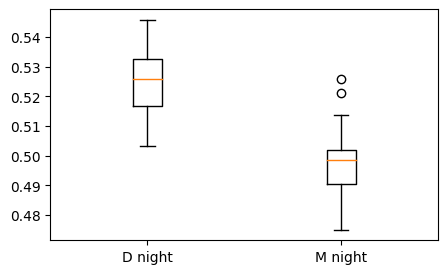

In [20]:
# boxplot for higher acc on D night
xlabel=['D night','M night']
data=[Dacchigh_df['accD'].values,Dacchigh_df['accM'].values]
fig = plt.figure(figsize =(5, 3))
plt.boxplot(data)
plt.xticks([1,2],xlabel)

([<matplotlib.axis.XTick at 0x7f6a9065f460>,
 [Text(1, 0, 'D night'), Text(2, 0, 'M night')])

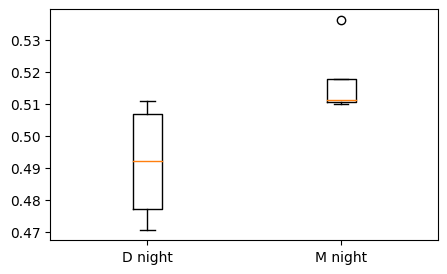

In [21]:
# boxplot for higher acc on M night
xlabel=['D night','M night']
data=[Macchigh_df['accD'].values,Macchigh_df['accM'].values]
fig = plt.figure(figsize =(5, 3))
plt.boxplot(data)
plt.xticks([1,2],xlabel)

In [22]:
list(Dacchigh_df['sub'].values)

['47', '28', '46', '30', '48', '41', '44', '29', '12', '09', '20', '05', '45']

In [25]:
list(Dacchigh_df['sub'].values)

['25', '14', '47', '24', '30', '48', '41', '44', '29', '09']

In [23]:
list(Dacchigh_df['sub'].values)

['14', '46', '30', '48', '41', '26', '09', '20', '45']

In [24]:
list(Dacchigh_df['sub'].values)

['25', '14', '47', '24', '30', '41', '44', '26', '29', '09']

In [26]:
# save results of subjects with higher D accuracy
Dacchigh_df.to_pickle('./Dacchigh_df1.pkl')